# Analysis of DeepFace Predictions

In [1]:
`import itertools
import json
import os
from pathlib import Path
from pprint import pprint
from typing import List, Optional, Tuple


from tqdm import tqdm

import cv2 as cv
import joblib
import numpy as np
import pandas as pd
import sklearn
from sklearn import base, calibration, metrics, model_selection

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

In [2]:
def quadrant_bboxes(img_size: Tuple[int, int]) -> List[List[int]]:
    width, height = [d // 2 for d in img_size]
    bboxes = [[x0, y0, x0+width, y0+height] for x0 in [0, width] for y0 in [0, height]]
    return bboxes

def crop_bbox(image: np.ndarray, bbox: np.array) -> np.ndarray:
    x0, y0, x1, y1 = bbox
    return image[y0:y1, x0:x1]

def prompt_extract(path: str) -> str:
    return ' '.join(path.split('_')[1:-1])

In [3]:
def image_equalize(
    image: np.ndarray,
    clipLimit: float=2.0,
    grid_size: int = 8
) -> np.ndarray:
    img_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    img_l, img_a, img_b = cv.split(img_lab)
    
    clahe = cv.createCLAHE(
        clipLimit=clipLimit,
        tileGridSize=(grid_size, grid_size)
    )
    img_l = clahe.apply(img_l)
    
    img_lab = cv.merge((img_l, img_a, img_b))
    img_cl = cv.cvtColor(img_lab, cv.COLOR_LAB2BGR)
    return img_cl

In [4]:
def df_bbox(region) -> List[int]:
    bbox = [
        region['x'],
        region['y'],
        region['x'] + region['w'],
        region['y'] + region['h']
    ]
    return bbox

df_actions = (
    'age',
    'gender',
    'race',
    'emotion'
)

def df_predictions(analysis: List[int], actions: Tuple[int]) -> dict:
    predictions = {action: analysis[action] for action in actions}
    predictions['bbox'] = df_bbox(analysis['region'])
    return predictions

In [5]:
df_backends = [
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
]

all_actions = df_actions + ('skin',)

df_default_models = {
    'age': DeepFace.build_model('Age'),
    'gender': DeepFace.build_model('Gender'),
    'emotion': DeepFace.build_model('Emotion'),
    'race': DeepFace.build_model('Race')
}

def image_predictions(
    image: np.ndarray,
    actions: Tuple[str] = ('gender', 'skin'),
    models: Optional[dict] = None,
    detector_backend: str = 'mtcnn',
    min_size: int = 20,
    equalize: bool = False
) -> Optional[dict]:
    
    assert(all(action in all_actions for action in actions))
    assert(detector_backend in df_backends)
    
    if equalize:
        image = image_equalize(image)
    
    predictions = None
    try:
        r = DeepFace.analyze(
            img_path=image,
            actions=(a for a in actions if a in df_actions),
            models=models,
            detector_backend=detector_backend,
            enforce_detection=True,
            prog_bar=False
        )
        if r['region']['w'] >= min_size and r['region']['h'] >= min_size:
            predictions = df_predictions(r, (a for a in actions if a in df_actions))
        
        if 'skin' in actions:
            color, _ = skin_color(crop_bbox(image, predictions['bbox']))
            predictions['skin color'] = color
    except ValueError:
        pass
        
    return predictions

In [6]:
midjourney_root = Path('C:/Users/edeprit/Downloads/SAAC/Midjourney/gender')

labels = sorted(list(map(lambda p: p.stem, midjourney_root.glob('*'))))
print(f'Labels: {labels}')

midjourney_ds = list(itertools.chain.from_iterable([zip((midjourney_root / Path(label)).glob('*.png'), itertools.repeat(idx)) for idx, label in enumerate(labels)]))

print('Midjourney Dataset:')
for idx, label in enumerate(labels):
    count = len(list(filter(lambda ex: ex[1] == idx, midjourney_ds)))
    print(f'{label}: {count}')

Labels: ['female', 'male']
Midjourney Dataset:
female: 453
male: 404


In [54]:
kwargs = {
    'equalize': True,
    'detector_backend': 'mtcnn',
    'actions': ('gender',),
    'models': { 'gender': df_default_models['gender'] }
}

all_predictions = []

for image_path, label in tqdm(midjourney_ds):
    image = cv.imread(str(image_path))
    assert(image.shape == (256, 256, 3))
    predictions =  image_predictions(image, **kwargs)
    if predictions is None:
        predictions = {}
    predictions['image'] = image_path
    predictions['label'] = label
    all_predictions.append(predictions)

  0%|                                                                                                                   | 0/857 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|                                                                                                           | 1/857 [00:02<40:38,  2.85s/it]

1/1 [==============================] - 2s 2s/step


  0%|▏                                                                                                          | 2/857 [00:05<39:29,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  0%|▎                                                                                                          | 3/857 [00:08<38:59,  2.74s/it]

1/1 [==============================] - 2s 2s/step


  0%|▍                                                                                                          | 4/857 [00:11<38:55,  2.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|▌                                                                                                          | 5/857 [00:13<38:28,  2.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▋                                                                                                          | 6/857 [00:16<38:22,  2.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▊                                                                                                          | 7/857 [00:19<38:27,  2.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|▉                                                                                                          | 8/857 [00:21<38:16,  2.71s/it]

1/1 [==============================] - 2s 2s/step


  1%|█                                                                                                          | 9/857 [00:24<37:32,  2.66s/it]

1/1 [==============================] - 2s 2s/step


  1%|█▏                                                                                                        | 10/857 [00:27<37:40,  2.67s/it]

1/1 [==============================] - 2s 2s/step


  1%|█▎                                                                                                        | 11/857 [00:29<37:25,  2.65s/it]

1/1 [==============================] - 2s 2s/step


  1%|█▍                                                                                                        | 12/857 [00:32<37:44,  2.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|█▌                                                                                                        | 13/857 [00:35<38:03,  2.70s/it]

1/1 [==============================] - 2s 2s/step


  2%|█▋                                                                                                        | 14/857 [00:38<38:59,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  2%|█▊                                                                                                        | 15/857 [00:40<38:34,  2.75s/it]

1/1 [==============================] - 2s 2s/step


  2%|█▉                                                                                                        | 16/857 [00:43<38:10,  2.72s/it]

1/1 [==============================] - 2s 2s/step


  2%|██                                                                                                        | 17/857 [00:46<38:15,  2.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|██▏                                                                                                       | 18/857 [00:48<38:09,  2.73s/it]

1/1 [==============================] - 2s 2s/step


  2%|██▎                                                                                                       | 19/857 [00:51<39:03,  2.80s/it]

1/1 [==============================] - 2s 2s/step


  2%|██▍                                                                                                       | 20/857 [00:54<39:01,  2.80s/it]

1/1 [==============================] - 2s 2s/step


  2%|██▌                                                                                                       | 21/857 [00:57<39:16,  2.82s/it]

1/1 [==============================] - 2s 2s/step


  3%|██▋                                                                                                       | 22/857 [01:00<38:39,  2.78s/it]

1/1 [==============================] - 2s 2s/step


  3%|██▊                                                                                                       | 23/857 [01:02<38:06,  2.74s/it]

1/1 [==============================] - 2s 2s/step


  3%|██▉                                                                                                       | 24/857 [01:05<37:46,  2.72s/it]

1/1 [==============================] - 2s 2s/step


  3%|███                                                                                                       | 25/857 [01:08<39:11,  2.83s/it]

1/1 [==============================] - 2s 2s/step


  3%|███▏                                                                                                      | 26/857 [01:11<39:49,  2.88s/it]

1/1 [==============================] - 2s 2s/step


  3%|███▎                                                                                                      | 27/857 [01:14<39:57,  2.89s/it]

1/1 [==============================] - 2s 2s/step


  3%|███▍                                                                                                      | 28/857 [01:17<39:32,  2.86s/it]

1/1 [==============================] - 2s 2s/step


  3%|███▌                                                                                                      | 29/857 [01:19<38:32,  2.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|███▋                                                                                                      | 30/857 [01:22<38:53,  2.82s/it]

1/1 [==============================] - 2s 2s/step


  4%|███▊                                                                                                      | 31/857 [01:25<38:43,  2.81s/it]

1/1 [==============================] - 2s 2s/step


  4%|███▉                                                                                                      | 32/857 [01:28<38:35,  2.81s/it]

1/1 [==============================] - 2s 2s/step


  4%|████                                                                                                      | 33/857 [01:31<39:00,  2.84s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▏                                                                                                     | 34/857 [01:34<39:57,  2.91s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▎                                                                                                     | 35/857 [01:37<38:49,  2.83s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▍                                                                                                     | 36/857 [01:39<38:09,  2.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▌                                                                                                     | 37/857 [01:42<38:07,  2.79s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▋                                                                                                     | 38/857 [01:45<37:50,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|████▊                                                                                                     | 39/857 [01:48<37:54,  2.78s/it]

1/1 [==============================] - 2s 2s/step


  5%|████▉                                                                                                     | 40/857 [01:50<37:35,  2.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████                                                                                                     | 41/857 [01:53<37:40,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▏                                                                                                    | 42/857 [01:56<38:38,  2.84s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▎                                                                                                    | 43/857 [01:59<37:54,  2.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▍                                                                                                    | 44/857 [02:02<37:56,  2.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▌                                                                                                    | 45/857 [02:04<37:20,  2.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▋                                                                                                    | 46/857 [02:07<37:51,  2.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▊                                                                                                    | 47/857 [02:10<37:54,  2.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|█████▉                                                                                                    | 48/857 [02:13<37:26,  2.78s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████                                                                                                    | 49/857 [02:16<38:03,  2.83s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████▏                                                                                                   | 50/857 [02:18<37:41,  2.80s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████▎                                                                                                   | 51/857 [02:21<38:06,  2.84s/it]

2/2 [==============================] - 0s 17ms/step


  6%|██████▍                                                                                                   | 52/857 [02:22<29:47,  2.22s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████▌                                                                                                   | 53/857 [02:25<32:07,  2.40s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████▋                                                                                                   | 54/857 [02:28<34:19,  2.56s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████▊                                                                                                   | 55/857 [02:31<35:45,  2.67s/it]

1/1 [==============================] - 2s 2s/step


  7%|██████▉                                                                                                   | 56/857 [02:34<36:13,  2.71s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████                                                                                                   | 57/857 [02:36<36:56,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▏                                                                                                  | 58/857 [02:39<36:55,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▎                                                                                                  | 59/857 [02:42<36:51,  2.77s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▍                                                                                                  | 60/857 [02:45<36:53,  2.78s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▌                                                                                                  | 61/857 [02:48<36:59,  2.79s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▋                                                                                                  | 62/857 [02:50<37:11,  2.81s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▊                                                                                                  | 63/857 [02:53<37:51,  2.86s/it]

1/1 [==============================] - 2s 2s/step


  7%|███████▉                                                                                                  | 64/857 [02:56<37:54,  2.87s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████                                                                                                  | 65/857 [02:59<37:22,  2.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▏                                                                                                 | 66/857 [03:02<37:08,  2.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▎                                                                                                 | 67/857 [03:05<36:45,  2.79s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▍                                                                                                 | 68/857 [03:08<37:05,  2.82s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▌                                                                                                 | 69/857 [03:10<37:31,  2.86s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▋                                                                                                 | 70/857 [03:13<36:47,  2.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▊                                                                                                 | 71/857 [03:16<37:21,  2.85s/it]

1/1 [==============================] - 2s 2s/step


  8%|████████▉                                                                                                 | 72/857 [03:19<36:50,  2.82s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████                                                                                                 | 73/857 [03:22<37:10,  2.84s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▏                                                                                                | 74/857 [03:25<37:12,  2.85s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▎                                                                                                | 75/857 [03:28<37:42,  2.89s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▍                                                                                                | 76/857 [03:30<37:40,  2.89s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▌                                                                                                | 77/857 [03:33<36:50,  2.83s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▋                                                                                                | 78/857 [03:36<37:04,  2.86s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▊                                                                                                | 79/857 [03:39<38:26,  2.97s/it]

1/1 [==============================] - 2s 2s/step


  9%|█████████▉                                                                                                | 80/857 [03:42<38:03,  2.94s/it]

1/1 [==============================] - 2s 2s/step


  9%|██████████                                                                                                | 81/857 [03:45<37:21,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▏                                                                                               | 82/857 [03:48<36:52,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▎                                                                                               | 83/857 [03:50<35:37,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▍                                                                                               | 84/857 [03:53<35:21,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▌                                                                                               | 85/857 [03:56<35:01,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▋                                                                                               | 86/857 [03:58<34:41,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▊                                                                                               | 87/857 [04:01<34:06,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 10%|██████████▉                                                                                               | 88/857 [04:04<34:53,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 10%|███████████                                                                                               | 89/857 [04:07<36:08,  2.82s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▏                                                                                              | 90/857 [04:10<36:45,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▎                                                                                              | 91/857 [04:13<36:37,  2.87s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▍                                                                                              | 92/857 [04:16<37:13,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▌                                                                                              | 93/857 [04:19<37:29,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▋                                                                                              | 94/857 [04:22<37:16,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▊                                                                                              | 95/857 [04:25<37:39,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▊                                                                                              | 96/857 [04:27<36:43,  2.90s/it]

1/1 [==============================] - 2s 2s/step


 11%|███████████▉                                                                                              | 97/857 [04:30<36:33,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 11%|████████████                                                                                              | 98/857 [04:33<37:29,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▏                                                                                             | 99/857 [04:36<37:36,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▎                                                                                            | 100/857 [04:39<37:45,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▎                                                                                            | 101/857 [04:42<37:48,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▍                                                                                            | 102/857 [04:45<37:50,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▌                                                                                            | 103/857 [04:48<37:39,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▋                                                                                            | 104/857 [04:51<37:28,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▊                                                                                            | 105/857 [04:55<37:56,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 12%|████████████▉                                                                                            | 106/857 [04:58<38:07,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 12%|█████████████                                                                                            | 107/857 [05:00<37:25,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▏                                                                                           | 108/857 [05:04<37:42,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▎                                                                                           | 109/857 [05:07<37:49,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▍                                                                                           | 110/857 [05:10<37:24,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▌                                                                                           | 111/857 [05:13<37:39,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▋                                                                                           | 112/857 [05:16<37:50,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▊                                                                                           | 113/857 [05:19<37:47,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 13%|█████████████▉                                                                                           | 114/857 [05:22<37:39,  3.04s/it]

1/1 [==============================] - 2s 2s/step


 13%|██████████████                                                                                           | 115/857 [05:25<37:48,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 14%|██████████████▏                                                                                          | 116/857 [05:28<37:24,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 14%|██████████████▎                                                                                          | 117/857 [05:31<36:28,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 14%|██████████████▍                                                                                          | 118/857 [05:34<37:04,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 14%|██████████████▌                                                                                          | 119/857 [05:37<36:29,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 14%|██████████████▋                                                                                          | 120/857 [05:40<36:00,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 14%|██████████████▊                                                                                          | 121/857 [05:43<36:12,  2.95s/it]

1/1 [==============================] - 0s 54ms/step


 14%|██████████████▉                                                                                          | 122/857 [05:43<28:27,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 14%|███████████████                                                                                          | 123/857 [05:46<30:52,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 14%|███████████████▏                                                                                         | 124/857 [05:50<33:16,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████▎                                                                                         | 125/857 [05:53<34:39,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████▍                                                                                         | 126/857 [05:56<35:48,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████▌                                                                                         | 127/857 [05:59<36:08,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████▋                                                                                         | 128/857 [06:02<36:40,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████▊                                                                                         | 129/857 [06:05<36:03,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████▉                                                                                         | 130/857 [06:08<36:12,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 15%|████████████████                                                                                         | 131/857 [06:11<37:06,  3.07s/it]

1/1 [==============================] - 2s 2s/step


 15%|████████████████▏                                                                                        | 132/857 [06:14<37:22,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 16%|████████████████▎                                                                                        | 133/857 [06:18<37:51,  3.14s/it]

1/1 [==============================] - 2s 2s/step


 16%|████████████████▍                                                                                        | 134/857 [06:21<37:19,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 16%|████████████████▌                                                                                        | 135/857 [06:24<37:30,  3.12s/it]

1/1 [==============================] - 2s 2s/step


 16%|████████████████▋                                                                                        | 136/857 [06:27<37:20,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 16%|████████████████▊                                                                                        | 137/857 [06:30<35:58,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 16%|████████████████▉                                                                                        | 138/857 [06:32<35:04,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 16%|█████████████████                                                                                        | 139/857 [06:35<35:29,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 16%|█████████████████▏                                                                                       | 140/857 [06:38<34:55,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 16%|█████████████████▎                                                                                       | 141/857 [06:41<34:26,  2.89s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████████▍                                                                                       | 142/857 [06:44<34:20,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████████▌                                                                                       | 143/857 [06:47<34:52,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████████▋                                                                                       | 144/857 [06:50<35:44,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████████▊                                                                                       | 145/857 [06:53<36:11,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████████▉                                                                                       | 146/857 [06:57<37:05,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 17%|██████████████████                                                                                       | 147/857 [07:00<37:56,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 17%|██████████████████▏                                                                                      | 148/857 [07:03<37:10,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 17%|██████████████████▎                                                                                      | 149/857 [07:06<36:39,  3.11s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████▍                                                                                      | 150/857 [07:09<36:29,  3.10s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████▌                                                                                      | 151/857 [07:12<37:41,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████▌                                                                                      | 152/857 [07:16<38:06,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████▋                                                                                      | 153/857 [07:19<38:11,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████▊                                                                                      | 154/857 [07:22<38:32,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████▉                                                                                      | 155/857 [07:26<37:49,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 18%|███████████████████                                                                                      | 156/857 [07:29<37:37,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 18%|███████████████████▏                                                                                     | 157/857 [07:32<37:34,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 18%|███████████████████▎                                                                                     | 158/857 [07:35<36:56,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████▍                                                                                     | 159/857 [07:38<37:38,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████▌                                                                                     | 160/857 [07:42<38:03,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████▋                                                                                     | 161/857 [07:45<37:41,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████▊                                                                                     | 162/857 [07:48<37:46,  3.26s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████▉                                                                                     | 163/857 [07:51<37:00,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 19%|████████████████████                                                                                     | 164/857 [07:55<37:36,  3.26s/it]

1/1 [==============================] - 2s 2s/step


 19%|████████████████████▏                                                                                    | 165/857 [07:58<37:59,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 19%|████████████████████▎                                                                                    | 166/857 [08:01<37:30,  3.26s/it]

1/1 [==============================] - 2s 2s/step


 19%|████████████████████▍                                                                                    | 167/857 [08:04<37:18,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████▌                                                                                    | 168/857 [08:08<37:02,  3.23s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████▋                                                                                    | 169/857 [08:11<36:32,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████▊                                                                                    | 170/857 [08:14<36:09,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████▉                                                                                    | 171/857 [08:17<37:32,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████                                                                                    | 172/857 [08:21<39:03,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████▏                                                                                   | 173/857 [08:24<38:29,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████▎                                                                                   | 174/857 [08:28<38:00,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████▍                                                                                   | 175/857 [08:31<38:14,  3.36s/it]

1/1 [==============================] - 2s 2s/step


 21%|█████████████████████▌                                                                                   | 176/857 [08:34<37:27,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 21%|█████████████████████▋                                                                                   | 177/857 [08:38<37:51,  3.34s/it]

1/1 [==============================] - 2s 2s/step


 21%|█████████████████████▊                                                                                   | 178/857 [08:41<37:09,  3.28s/it]

1/1 [==============================] - 2s 2s/step


 21%|█████████████████████▉                                                                                   | 179/857 [08:44<36:24,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████                                                                                   | 180/857 [08:47<35:52,  3.18s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████▏                                                                                  | 181/857 [08:50<36:01,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████▎                                                                                  | 182/857 [08:53<35:57,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████▍                                                                                  | 183/857 [08:57<35:33,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████▌                                                                                  | 184/857 [09:00<35:58,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 22%|██████████████████████▋                                                                                  | 185/857 [09:03<35:54,  3.21s/it]

1/1 [==============================] - 2s 2s/step


 22%|██████████████████████▊                                                                                  | 186/857 [09:06<35:50,  3.20s/it]

1/1 [==============================] - 2s 2s/step


 22%|██████████████████████▉                                                                                  | 187/857 [09:10<36:11,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████                                                                                  | 188/857 [09:13<36:05,  3.24s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████▏                                                                                 | 189/857 [09:16<36:45,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████▎                                                                                 | 190/857 [09:19<35:28,  3.19s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████▍                                                                                 | 191/857 [09:22<34:53,  3.14s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████▌                                                                                 | 192/857 [09:25<34:06,  3.08s/it]

1/1 [==============================] - 2s 2s/step


 23%|███████████████████████▋                                                                                 | 193/857 [09:28<33:48,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 23%|███████████████████████▊                                                                                 | 194/857 [09:31<33:16,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 23%|███████████████████████▉                                                                                 | 195/857 [09:34<33:07,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████                                                                                 | 196/857 [09:37<33:01,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████▏                                                                                | 197/857 [09:40<32:54,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████▎                                                                                | 198/857 [09:43<33:30,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████▍                                                                                | 199/857 [09:46<32:57,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████▌                                                                                | 200/857 [09:49<33:06,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████▋                                                                                | 201/857 [09:52<33:04,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 24%|████████████████████████▋                                                                                | 202/857 [09:55<33:09,  3.04s/it]

1/1 [==============================] - 2s 2s/step


 24%|████████████████████████▊                                                                                | 203/857 [09:59<34:27,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 24%|████████████████████████▉                                                                                | 204/857 [10:02<35:58,  3.30s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████                                                                                | 205/857 [10:06<36:21,  3.35s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████▏                                                                               | 206/857 [10:09<36:38,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████▎                                                                               | 207/857 [10:13<37:12,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████▍                                                                               | 208/857 [10:16<37:20,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████▌                                                                               | 209/857 [10:20<36:59,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 25%|█████████████████████████▋                                                                               | 210/857 [10:23<36:47,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 25%|█████████████████████████▊                                                                               | 211/857 [10:26<36:43,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 25%|█████████████████████████▉                                                                               | 212/857 [10:30<36:22,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 25%|██████████████████████████                                                                               | 213/857 [10:33<36:44,  3.42s/it]

1/1 [==============================] - 2s 2s/step


 25%|██████████████████████████▏                                                                              | 214/857 [10:37<36:47,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 25%|██████████████████████████▎                                                                              | 215/857 [10:40<36:36,  3.42s/it]

1/1 [==============================] - 3s 3s/step


 25%|██████████████████████████▍                                                                              | 216/857 [10:44<36:55,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 25%|██████████████████████████▌                                                                              | 217/857 [10:47<36:38,  3.44s/it]

1/1 [==============================] - 3s 3s/step


 25%|██████████████████████████▋                                                                              | 218/857 [10:51<36:48,  3.46s/it]

1/1 [==============================] - 3s 3s/step


 26%|██████████████████████████▊                                                                              | 219/857 [10:54<37:08,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 26%|██████████████████████████▉                                                                              | 220/857 [10:58<36:50,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 26%|███████████████████████████                                                                              | 221/857 [11:01<36:11,  3.41s/it]

1/1 [==============================] - 2s 2s/step


 26%|███████████████████████████▏                                                                             | 222/857 [11:04<35:44,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 26%|███████████████████████████▎                                                                             | 223/857 [11:07<35:39,  3.38s/it]

1/1 [==============================] - 3s 3s/step


 26%|███████████████████████████▍                                                                             | 224/857 [11:11<36:20,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 26%|███████████████████████████▌                                                                             | 225/857 [11:15<36:23,  3.46s/it]

1/1 [==============================] - 3s 3s/step


 26%|███████████████████████████▋                                                                             | 226/857 [11:18<36:38,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 26%|███████████████████████████▊                                                                             | 227/857 [11:22<36:28,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 27%|███████████████████████████▉                                                                             | 228/857 [11:25<36:09,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 27%|████████████████████████████                                                                             | 229/857 [11:28<36:18,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 27%|████████████████████████████▏                                                                            | 230/857 [11:32<36:17,  3.47s/it]

1/1 [==============================] - 3s 3s/step


 27%|████████████████████████████▎                                                                            | 231/857 [11:36<37:08,  3.56s/it]

1/1 [==============================] - 2s 2s/step


 27%|████████████████████████████▍                                                                            | 232/857 [11:39<36:28,  3.50s/it]

1/1 [==============================] - 2s 2s/step


 27%|████████████████████████████▌                                                                            | 233/857 [11:43<36:19,  3.49s/it]

1/1 [==============================] - 2s 2s/step


 27%|████████████████████████████▋                                                                            | 234/857 [11:46<35:40,  3.44s/it]

1/1 [==============================] - 2s 2s/step


 27%|████████████████████████████▊                                                                            | 235/857 [11:49<35:15,  3.40s/it]

1/1 [==============================] - 3s 3s/step


 28%|████████████████████████████▉                                                                            | 236/857 [11:53<35:28,  3.43s/it]

1/1 [==============================] - 3s 3s/step


 28%|█████████████████████████████                                                                            | 237/857 [11:56<35:31,  3.44s/it]

1/1 [==============================] - 2s 2s/step


 28%|█████████████████████████████▏                                                                           | 238/857 [12:00<35:26,  3.44s/it]

1/1 [==============================] - 2s 2s/step


 28%|█████████████████████████████▎                                                                           | 239/857 [12:03<35:13,  3.42s/it]

1/1 [==============================] - 3s 3s/step


 28%|█████████████████████████████▍                                                                           | 240/857 [12:07<36:02,  3.50s/it]

1/1 [==============================] - 3s 3s/step


 28%|█████████████████████████████▌                                                                           | 241/857 [12:10<36:15,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 28%|█████████████████████████████▋                                                                           | 242/857 [12:14<35:58,  3.51s/it]

1/1 [==============================] - 3s 3s/step


 28%|█████████████████████████████▊                                                                           | 243/857 [12:17<36:22,  3.56s/it]

1/1 [==============================] - 2s 2s/step


 28%|█████████████████████████████▉                                                                           | 244/857 [12:21<36:20,  3.56s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████                                                                           | 245/857 [12:24<36:08,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████▏                                                                          | 246/857 [12:28<36:09,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████▎                                                                          | 247/857 [12:31<35:25,  3.48s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████▍                                                                          | 248/857 [12:35<35:31,  3.50s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████▌                                                                          | 249/857 [12:38<35:01,  3.46s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████▋                                                                          | 250/857 [12:42<34:58,  3.46s/it]

1/1 [==============================] - 3s 3s/step


 29%|██████████████████████████████▊                                                                          | 251/857 [12:45<35:25,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 29%|██████████████████████████████▉                                                                          | 252/857 [12:49<35:14,  3.49s/it]

1/1 [==============================] - 3s 3s/step


 30%|██████████████████████████████▉                                                                          | 253/857 [12:52<35:17,  3.51s/it]

1/1 [==============================] - 3s 3s/step


 30%|███████████████████████████████                                                                          | 254/857 [12:56<36:01,  3.58s/it]

1/1 [==============================] - 3s 3s/step


 30%|███████████████████████████████▏                                                                         | 255/857 [13:00<35:52,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 30%|███████████████████████████████▎                                                                         | 256/857 [13:03<35:35,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 30%|███████████████████████████████▍                                                                         | 257/857 [13:06<34:43,  3.47s/it]

1/1 [==============================] - 2s 2s/step


 30%|███████████████████████████████▌                                                                         | 258/857 [13:10<34:46,  3.48s/it]

1/1 [==============================] - 3s 3s/step


 30%|███████████████████████████████▋                                                                         | 259/857 [13:14<35:19,  3.54s/it]

1/1 [==============================] - 3s 3s/step


 30%|███████████████████████████████▊                                                                         | 260/857 [13:17<35:27,  3.56s/it]

1/1 [==============================] - 3s 3s/step


 30%|███████████████████████████████▉                                                                         | 261/857 [13:21<35:09,  3.54s/it]

1/1 [==============================] - 2s 2s/step


 31%|████████████████████████████████                                                                         | 262/857 [13:24<34:55,  3.52s/it]

1/1 [==============================] - 3s 3s/step


 31%|████████████████████████████████▏                                                                        | 263/857 [13:28<34:58,  3.53s/it]

1/1 [==============================] - 2s 2s/step


 31%|████████████████████████████████▎                                                                        | 264/857 [13:31<34:32,  3.49s/it]

1/1 [==============================] - 3s 3s/step


 31%|████████████████████████████████▍                                                                        | 265/857 [13:35<35:01,  3.55s/it]

1/1 [==============================] - 2s 2s/step


 31%|████████████████████████████████▌                                                                        | 266/857 [13:38<35:10,  3.57s/it]

1/1 [==============================] - 3s 3s/step


 31%|████████████████████████████████▋                                                                        | 267/857 [13:42<34:52,  3.55s/it]

1/1 [==============================] - 3s 3s/step


 31%|████████████████████████████████▊                                                                        | 268/857 [13:46<34:53,  3.55s/it]

1/1 [==============================] - 3s 3s/step


 31%|████████████████████████████████▉                                                                        | 269/857 [13:49<34:55,  3.56s/it]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████████████                                                                        | 270/857 [13:53<35:55,  3.67s/it]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████████████▏                                                                       | 271/857 [13:57<35:46,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 32%|█████████████████████████████████▎                                                                       | 272/857 [14:00<35:19,  3.62s/it]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████████████▍                                                                       | 273/857 [14:04<35:27,  3.64s/it]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████████████▌                                                                       | 274/857 [14:07<35:17,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 32%|█████████████████████████████████▋                                                                       | 275/857 [14:11<34:37,  3.57s/it]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████████████▊                                                                       | 276/857 [14:15<34:36,  3.57s/it]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████████████▉                                                                       | 277/857 [14:18<35:03,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 32%|██████████████████████████████████                                                                       | 278/857 [14:22<34:45,  3.60s/it]

1/1 [==============================] - 2s 2s/step


 33%|██████████████████████████████████▏                                                                      | 279/857 [14:25<34:43,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 33%|██████████████████████████████████▎                                                                      | 280/857 [14:30<36:08,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 33%|██████████████████████████████████▍                                                                      | 281/857 [14:33<36:36,  3.81s/it]

1/1 [==============================] - 2s 2s/step


 33%|██████████████████████████████████▌                                                                      | 282/857 [14:37<36:18,  3.79s/it]

1/1 [==============================] - 3s 3s/step


 33%|██████████████████████████████████▋                                                                      | 283/857 [14:41<36:14,  3.79s/it]

1/1 [==============================] - 3s 3s/step


 33%|██████████████████████████████████▊                                                                      | 284/857 [14:45<36:17,  3.80s/it]

1/1 [==============================] - 2s 2s/step


 33%|██████████████████████████████████▉                                                                      | 285/857 [14:48<35:30,  3.72s/it]

1/1 [==============================] - 3s 3s/step


 33%|███████████████████████████████████                                                                      | 286/857 [14:52<35:50,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 33%|███████████████████████████████████▏                                                                     | 287/857 [14:56<35:35,  3.75s/it]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████████████▎                                                                     | 288/857 [15:00<35:05,  3.70s/it]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████████████▍                                                                     | 289/857 [15:03<35:15,  3.73s/it]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████████████▌                                                                     | 290/857 [15:07<35:06,  3.71s/it]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████████████▋                                                                     | 291/857 [15:11<35:34,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████████████▊                                                                     | 292/857 [15:15<35:26,  3.76s/it]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████████████▉                                                                     | 293/857 [15:18<35:21,  3.76s/it]

1/1 [==============================] - 2s 2s/step


 34%|████████████████████████████████████                                                                     | 294/857 [15:22<34:29,  3.68s/it]

1/1 [==============================] - 3s 3s/step


 34%|████████████████████████████████████▏                                                                    | 295/857 [15:26<34:53,  3.73s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████████████▎                                                                    | 296/857 [15:29<34:31,  3.69s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████████████▍                                                                    | 297/857 [15:33<34:28,  3.69s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████████████▌                                                                    | 298/857 [15:37<34:10,  3.67s/it]

1/1 [==============================] - 2s 2s/step


 35%|████████████████████████████████████▋                                                                    | 299/857 [15:40<33:29,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████████████▊                                                                    | 300/857 [15:44<34:23,  3.70s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████████████▉                                                                    | 301/857 [15:48<34:08,  3.69s/it]

1/1 [==============================] - 3s 3s/step


 35%|█████████████████████████████████████                                                                    | 302/857 [15:51<33:50,  3.66s/it]

1/1 [==============================] - 2s 2s/step


 35%|█████████████████████████████████████                                                                    | 303/857 [15:55<33:19,  3.61s/it]

1/1 [==============================] - 3s 3s/step


 35%|█████████████████████████████████████▏                                                                   | 304/857 [15:58<33:11,  3.60s/it]

1/1 [==============================] - 3s 3s/step


 36%|█████████████████████████████████████▎                                                                   | 305/857 [16:02<33:24,  3.63s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████▍                                                                   | 306/857 [16:06<33:00,  3.59s/it]

1/1 [==============================] - 3s 3s/step


 36%|█████████████████████████████████████▌                                                                   | 307/857 [16:09<32:50,  3.58s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████▋                                                                   | 308/857 [16:12<32:09,  3.51s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████▊                                                                   | 309/857 [16:16<31:29,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████▉                                                                   | 310/857 [16:19<31:14,  3.43s/it]

1/1 [==============================] - 2s 2s/step


 36%|██████████████████████████████████████                                                                   | 311/857 [16:22<30:48,  3.38s/it]

1/1 [==============================] - 2s 2s/step


 36%|██████████████████████████████████████▏                                                                  | 312/857 [16:26<30:26,  3.35s/it]

1/1 [==============================] - 3s 3s/step


 37%|██████████████████████████████████████▎                                                                  | 313/857 [16:29<31:19,  3.46s/it]

1/1 [==============================] - 3s 3s/step


 37%|██████████████████████████████████████▍                                                                  | 314/857 [16:34<33:11,  3.67s/it]

1/1 [==============================] - 3s 3s/step


 37%|██████████████████████████████████████▌                                                                  | 315/857 [16:37<33:38,  3.72s/it]

1/1 [==============================] - 3s 3s/step


 37%|██████████████████████████████████████▋                                                                  | 316/857 [16:41<33:33,  3.72s/it]

1/1 [==============================] - 3s 3s/step


 37%|██████████████████████████████████████▊                                                                  | 317/857 [16:45<33:32,  3.73s/it]

1/1 [==============================] - 3s 3s/step


 37%|██████████████████████████████████████▉                                                                  | 318/857 [16:49<33:41,  3.75s/it]

1/1 [==============================] - 3s 3s/step


 37%|███████████████████████████████████████                                                                  | 319/857 [16:52<33:15,  3.71s/it]

1/1 [==============================] - 3s 3s/step


 37%|███████████████████████████████████████▏                                                                 | 320/857 [16:56<33:13,  3.71s/it]

1/1 [==============================] - 3s 3s/step


 37%|███████████████████████████████████████▎                                                                 | 321/857 [17:00<33:50,  3.79s/it]

1/1 [==============================] - 3s 3s/step


 38%|███████████████████████████████████████▍                                                                 | 322/857 [17:04<35:28,  3.98s/it]

1/1 [==============================] - 3s 3s/step


 38%|███████████████████████████████████████▌                                                                 | 323/857 [17:08<35:04,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 38%|███████████████████████████████████████▋                                                                 | 324/857 [17:12<34:07,  3.84s/it]

1/1 [==============================] - 3s 3s/step


 38%|███████████████████████████████████████▊                                                                 | 325/857 [17:16<33:44,  3.81s/it]

1/1 [==============================] - 3s 3s/step


 38%|███████████████████████████████████████▉                                                                 | 326/857 [17:20<34:05,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 38%|████████████████████████████████████████                                                                 | 327/857 [17:23<33:47,  3.83s/it]

1/1 [==============================] - 3s 3s/step


 38%|████████████████████████████████████████▏                                                                | 328/857 [17:27<34:01,  3.86s/it]

1/1 [==============================] - 3s 3s/step


 38%|████████████████████████████████████████▎                                                                | 329/857 [17:31<33:35,  3.82s/it]

1/1 [==============================] - 3s 3s/step


 39%|████████████████████████████████████████▍                                                                | 330/857 [17:35<33:08,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 39%|████████████████████████████████████████▌                                                                | 331/857 [17:39<33:30,  3.82s/it]

1/1 [==============================] - 3s 3s/step


 39%|████████████████████████████████████████▋                                                                | 332/857 [17:42<33:09,  3.79s/it]

1/1 [==============================] - 3s 3s/step


 39%|████████████████████████████████████████▊                                                                | 333/857 [17:46<33:05,  3.79s/it]

1/1 [==============================] - 3s 3s/step


 39%|████████████████████████████████████████▉                                                                | 334/857 [17:50<33:41,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████████████████                                                                | 335/857 [17:54<33:51,  3.89s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████████████████▏                                                               | 336/857 [17:58<33:38,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████████████████▎                                                               | 337/857 [18:02<33:30,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 39%|█████████████████████████████████████████▍                                                               | 338/857 [18:06<33:17,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 40%|█████████████████████████████████████████▌                                                               | 339/857 [18:10<33:58,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 40%|█████████████████████████████████████████▋                                                               | 340/857 [18:14<33:53,  3.93s/it]

1/1 [==============================] - 3s 3s/step


 40%|█████████████████████████████████████████▊                                                               | 341/857 [18:18<34:01,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 40%|█████████████████████████████████████████▉                                                               | 342/857 [18:22<33:56,  3.95s/it]

1/1 [==============================] - 3s 3s/step


 40%|██████████████████████████████████████████                                                               | 343/857 [18:25<33:45,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 40%|██████████████████████████████████████████▏                                                              | 344/857 [18:29<33:33,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 40%|██████████████████████████████████████████▎                                                              | 345/857 [18:33<33:25,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 40%|██████████████████████████████████████████▍                                                              | 346/857 [18:37<33:25,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 40%|██████████████████████████████████████████▌                                                              | 347/857 [18:41<32:44,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 41%|██████████████████████████████████████████▋                                                              | 348/857 [18:45<33:33,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 41%|██████████████████████████████████████████▊                                                              | 349/857 [18:49<33:32,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 41%|██████████████████████████████████████████▉                                                              | 350/857 [18:53<33:40,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 41%|███████████████████████████████████████████                                                              | 351/857 [18:57<34:31,  4.09s/it]

1/1 [==============================] - 3s 3s/step


 41%|███████████████████████████████████████████▏                                                             | 352/857 [19:01<33:55,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 41%|███████████████████████████████████████████▏                                                             | 353/857 [19:05<32:46,  3.90s/it]

1/1 [==============================] - 3s 3s/step


 41%|███████████████████████████████████████████▎                                                             | 354/857 [19:09<33:25,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 41%|███████████████████████████████████████████▍                                                             | 355/857 [19:13<33:10,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 42%|███████████████████████████████████████████▌                                                             | 356/857 [19:17<33:04,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 42%|███████████████████████████████████████████▋                                                             | 357/857 [19:21<33:17,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 42%|███████████████████████████████████████████▊                                                             | 358/857 [19:25<33:35,  4.04s/it]

1/1 [==============================] - 3s 3s/step


 42%|███████████████████████████████████████████▉                                                             | 359/857 [19:29<33:39,  4.05s/it]

1/1 [==============================] - 3s 3s/step


 42%|████████████████████████████████████████████                                                             | 360/857 [19:33<33:43,  4.07s/it]

1/1 [==============================] - 3s 3s/step


 42%|████████████████████████████████████████████▏                                                            | 361/857 [19:37<33:41,  4.08s/it]

1/1 [==============================] - 3s 3s/step


 42%|████████████████████████████████████████████▎                                                            | 362/857 [19:42<33:35,  4.07s/it]

1/1 [==============================] - 3s 3s/step


 42%|████████████████████████████████████████████▍                                                            | 363/857 [19:46<33:21,  4.05s/it]

1/1 [==============================] - 3s 3s/step


 42%|████████████████████████████████████████████▌                                                            | 364/857 [19:49<32:47,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 43%|████████████████████████████████████████████▋                                                            | 365/857 [19:53<32:05,  3.91s/it]

1/1 [==============================] - 3s 3s/step


 43%|████████████████████████████████████████████▊                                                            | 366/857 [19:57<32:17,  3.95s/it]

1/1 [==============================] - 3s 3s/step


 43%|████████████████████████████████████████████▉                                                            | 367/857 [20:01<32:05,  3.93s/it]

1/1 [==============================] - 3s 3s/step


 43%|█████████████████████████████████████████████                                                            | 368/857 [20:05<31:18,  3.84s/it]

1/1 [==============================] - 3s 3s/step


 43%|█████████████████████████████████████████████▏                                                           | 369/857 [20:09<31:28,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 43%|█████████████████████████████████████████████▎                                                           | 370/857 [20:13<31:28,  3.88s/it]

1/1 [==============================] - 3s 3s/step


 43%|█████████████████████████████████████████████▍                                                           | 371/857 [20:17<32:23,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 43%|█████████████████████████████████████████████▌                                                           | 372/857 [20:21<32:46,  4.06s/it]

1/1 [==============================] - 3s 3s/step


 44%|█████████████████████████████████████████████▋                                                           | 373/857 [20:25<32:20,  4.01s/it]

1/1 [==============================] - 3s 3s/step


 44%|█████████████████████████████████████████████▊                                                           | 374/857 [20:29<32:46,  4.07s/it]

1/1 [==============================] - 3s 3s/step


 44%|█████████████████████████████████████████████▉                                                           | 375/857 [20:33<32:08,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 44%|██████████████████████████████████████████████                                                           | 376/857 [20:37<32:27,  4.05s/it]

1/1 [==============================] - 3s 3s/step


 44%|██████████████████████████████████████████████▏                                                          | 377/857 [20:41<32:16,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 44%|██████████████████████████████████████████████▎                                                          | 378/857 [20:45<31:46,  3.98s/it]

1/1 [==============================] - 3s 3s/step


 44%|██████████████████████████████████████████████▍                                                          | 379/857 [20:49<31:18,  3.93s/it]

1/1 [==============================] - 3s 3s/step


 44%|██████████████████████████████████████████████▌                                                          | 380/857 [20:53<31:14,  3.93s/it]

1/1 [==============================] - 3s 3s/step


 44%|██████████████████████████████████████████████▋                                                          | 381/857 [20:57<31:27,  3.96s/it]

1/1 [==============================] - 3s 3s/step


 45%|██████████████████████████████████████████████▊                                                          | 382/857 [21:00<30:48,  3.89s/it]

1/1 [==============================] - 3s 3s/step


 45%|██████████████████████████████████████████████▉                                                          | 383/857 [21:04<31:05,  3.94s/it]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████████████████                                                          | 384/857 [21:09<31:43,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████████████████▏                                                         | 385/857 [21:13<31:52,  4.05s/it]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████████████████▎                                                         | 386/857 [21:17<31:23,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████████████████▍                                                         | 387/857 [21:21<31:35,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████████████████▌                                                         | 388/857 [21:25<32:00,  4.10s/it]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████████████████▋                                                         | 389/857 [21:29<31:20,  4.02s/it]

1/1 [==============================] - 3s 3s/step


 46%|███████████████████████████████████████████████▊                                                         | 390/857 [21:33<31:23,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 46%|███████████████████████████████████████████████▉                                                         | 391/857 [21:37<31:15,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████                                                         | 392/857 [21:41<31:49,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████▏                                                        | 393/857 [21:46<32:24,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████▎                                                        | 394/857 [21:50<32:35,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████▍                                                        | 395/857 [21:54<32:14,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████▌                                                        | 396/857 [21:58<31:46,  4.14s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████▋                                                        | 397/857 [22:02<32:20,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████████████████▊                                                        | 398/857 [22:07<32:17,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 47%|████████████████████████████████████████████████▉                                                        | 399/857 [22:11<31:59,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████                                                        | 400/857 [22:15<31:16,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▏                                                       | 401/857 [22:19<31:44,  4.18s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▎                                                       | 402/857 [22:23<31:50,  4.20s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▍                                                       | 403/857 [22:27<31:31,  4.17s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▍                                                       | 404/857 [22:31<31:00,  4.11s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▌                                                       | 405/857 [22:35<29:56,  3.97s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▋                                                       | 406/857 [22:39<29:17,  3.90s/it]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████████████████▊                                                       | 407/857 [22:42<28:45,  3.83s/it]

1/1 [==============================] - 3s 3s/step


 48%|█████████████████████████████████████████████████▉                                                       | 408/857 [22:46<28:48,  3.85s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████                                                       | 409/857 [22:51<30:05,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████▏                                                      | 410/857 [22:55<30:01,  4.03s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████▎                                                      | 411/857 [22:59<29:39,  3.99s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████▍                                                      | 412/857 [23:03<29:15,  3.95s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████▌                                                      | 413/857 [23:06<28:38,  3.87s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████▋                                                      | 414/857 [23:10<28:21,  3.84s/it]

1/1 [==============================] - 3s 3s/step


 48%|██████████████████████████████████████████████████▊                                                      | 415/857 [23:14<28:12,  3.83s/it]

1/1 [==============================] - 3s 3s/step


 49%|██████████████████████████████████████████████████▉                                                      | 416/857 [23:18<27:54,  3.80s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████                                                      | 417/857 [23:21<27:39,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████▏                                                     | 418/857 [23:25<27:17,  3.73s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████▎                                                     | 419/857 [23:29<27:19,  3.74s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████▍                                                     | 420/857 [23:32<27:12,  3.74s/it]

1/1 [==============================] - 2s 2s/step


 49%|███████████████████████████████████████████████████▌                                                     | 421/857 [23:36<26:46,  3.69s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████▋                                                     | 422/857 [23:40<27:12,  3.75s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████▊                                                     | 423/857 [23:44<27:06,  3.75s/it]

1/1 [==============================] - 3s 3s/step


 49%|███████████████████████████████████████████████████▉                                                     | 424/857 [23:47<26:55,  3.73s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████                                                     | 425/857 [23:52<28:49,  4.00s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████▏                                                    | 426/857 [23:56<29:37,  4.12s/it]

1/1 [==============================] - 4s 4s/step


 50%|████████████████████████████████████████████████████▎                                                    | 427/857 [24:01<31:01,  4.33s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████▍                                                    | 428/857 [24:06<30:59,  4.33s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████▌                                                    | 429/857 [24:10<31:09,  4.37s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████▋                                                    | 430/857 [24:14<30:49,  4.33s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████▊                                                    | 431/857 [24:18<30:31,  4.30s/it]

1/1 [==============================] - 3s 3s/step


 50%|████████████████████████████████████████████████████▉                                                    | 432/857 [24:23<30:18,  4.28s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████                                                    | 433/857 [24:27<29:50,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▏                                                   | 434/857 [24:31<29:44,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▎                                                   | 435/857 [24:35<29:22,  4.18s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▍                                                   | 436/857 [24:39<29:20,  4.18s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▌                                                   | 437/857 [24:44<29:50,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▋                                                   | 438/857 [24:48<30:08,  4.32s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▊                                                   | 439/857 [24:53<30:46,  4.42s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████████████████████████████████████████████████████▉                                                   | 440/857 [24:57<30:02,  4.32s/it]

1/1 [==============================] - 3s 3s/step


 51%|██████████████████████████████████████████████████████                                                   | 441/857 [25:02<30:35,  4.41s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▏                                                  | 442/857 [25:06<30:52,  4.46s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▎                                                  | 443/857 [25:11<30:46,  4.46s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▍                                                  | 444/857 [25:15<30:22,  4.41s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▌                                                  | 445/857 [25:19<29:40,  4.32s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▋                                                  | 446/857 [25:23<30:00,  4.38s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▊                                                  | 447/857 [25:28<30:20,  4.44s/it]

1/1 [==============================] - 3s 3s/step


 52%|██████████████████████████████████████████████████████▉                                                  | 448/857 [25:32<30:12,  4.43s/it]

1/1 [==============================] - 3s 3s/step


 52%|███████████████████████████████████████████████████████                                                  | 449/857 [25:37<30:13,  4.44s/it]

1/1 [==============================] - 3s 3s/step


 53%|███████████████████████████████████████████████████████▏                                                 | 450/857 [25:41<30:10,  4.45s/it]

1/1 [==============================] - 3s 3s/step


 53%|███████████████████████████████████████████████████████▎                                                 | 451/857 [25:46<30:07,  4.45s/it]

1/1 [==============================] - 3s 3s/step


 53%|███████████████████████████████████████████████████████▍                                                 | 452/857 [25:50<29:58,  4.44s/it]

1/1 [==============================] - 4s 4s/step


 53%|███████████████████████████████████████████████████████▌                                                 | 453/857 [25:55<30:39,  4.55s/it]

1/1 [==============================] - 4s 4s/step


 53%|███████████████████████████████████████████████████████▌                                                 | 454/857 [26:00<30:49,  4.59s/it]

1/1 [==============================] - 3s 3s/step


 53%|███████████████████████████████████████████████████████▋                                                 | 455/857 [26:04<30:48,  4.60s/it]

1/1 [==============================] - 3s 3s/step


 53%|███████████████████████████████████████████████████████▊                                                 | 456/857 [26:09<30:22,  4.54s/it]

1/1 [==============================] - 3s 3s/step


 53%|███████████████████████████████████████████████████████▉                                                 | 457/857 [26:13<30:03,  4.51s/it]

1/1 [==============================] - 3s 3s/step


 53%|████████████████████████████████████████████████████████                                                 | 458/857 [26:18<29:49,  4.49s/it]

1/1 [==============================] - 3s 3s/step


 54%|████████████████████████████████████████████████████████▏                                                | 459/857 [26:22<30:16,  4.56s/it]

1/1 [==============================] - 3s 3s/step


 54%|████████████████████████████████████████████████████████▎                                                | 460/857 [26:27<30:04,  4.55s/it]

1/1 [==============================] - 3s 3s/step


 54%|████████████████████████████████████████████████████████▍                                                | 461/857 [26:31<30:04,  4.56s/it]

1/1 [==============================] - 3s 3s/step


 54%|████████████████████████████████████████████████████████▌                                                | 462/857 [26:36<29:59,  4.56s/it]

1/1 [==============================] - 3s 3s/step


 54%|████████████████████████████████████████████████████████▋                                                | 463/857 [26:41<30:14,  4.61s/it]

1/1 [==============================] - 3s 3s/step


 54%|████████████████████████████████████████████████████████▊                                                | 464/857 [26:45<30:05,  4.59s/it]

1/1 [==============================] - 4s 4s/step


 54%|████████████████████████████████████████████████████████▉                                                | 465/857 [26:50<30:14,  4.63s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████████████████████████████████████████████████████████                                                | 466/857 [26:55<30:01,  4.61s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████████████████████████████████████████████████████████▏                                               | 467/857 [26:59<29:59,  4.61s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████████████████████████████████████████████████████████▎                                               | 468/857 [27:04<29:48,  4.60s/it]

1/1 [==============================] - 4s 4s/step


 55%|█████████████████████████████████████████████████████████▍                                               | 469/857 [27:08<29:50,  4.62s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████████████████████████████████████████████████████████▌                                               | 470/857 [27:13<29:11,  4.52s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████████████████████████████████████████████████████████▋                                               | 471/857 [27:17<29:22,  4.57s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████████████████████████████████████████████████████████▊                                               | 472/857 [27:22<29:44,  4.64s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████████████████████████████████████████████████████████▉                                               | 473/857 [27:27<29:47,  4.65s/it]

1/1 [==============================] - 0s 83ms/step


 55%|██████████████████████████████████████████████████████████                                               | 474/857 [27:28<22:32,  3.53s/it]

1/1 [==============================] - 3s 3s/step


 55%|██████████████████████████████████████████████████████████▏                                              | 475/857 [27:33<24:53,  3.91s/it]

1/1 [==============================] - 3s 3s/step


 56%|██████████████████████████████████████████████████████████▎                                              | 476/857 [27:37<25:33,  4.03s/it]

1/1 [==============================] - 0s 59ms/step


 56%|██████████████████████████████████████████████████████████▍                                              | 477/857 [27:38<19:45,  3.12s/it]

1/1 [==============================] - 3s 3s/step


 56%|██████████████████████████████████████████████████████████▌                                              | 478/857 [27:42<22:28,  3.56s/it]

1/1 [==============================] - 3s 3s/step


 56%|██████████████████████████████████████████████████████████▋                                              | 479/857 [27:47<24:19,  3.86s/it]

1/1 [==============================] - 3s 3s/step


 56%|██████████████████████████████████████████████████████████▊                                              | 480/857 [27:51<25:15,  4.02s/it]

1/1 [==============================] - 4s 4s/step


 56%|██████████████████████████████████████████████████████████▉                                              | 481/857 [27:56<26:30,  4.23s/it]

1/1 [==============================] - 4s 4s/step


 56%|███████████████████████████████████████████████████████████                                              | 482/857 [28:01<27:29,  4.40s/it]

1/1 [==============================] - 3s 3s/step


 56%|███████████████████████████████████████████████████████████▏                                             | 483/857 [28:06<27:41,  4.44s/it]

1/1 [==============================] - 3s 3s/step


 56%|███████████████████████████████████████████████████████████▎                                             | 484/857 [28:10<27:45,  4.47s/it]

1/1 [==============================] - 3s 3s/step


 57%|███████████████████████████████████████████████████████████▍                                             | 485/857 [28:15<27:57,  4.51s/it]

1/1 [==============================] - 3s 3s/step


 57%|███████████████████████████████████████████████████████████▌                                             | 486/857 [28:19<27:39,  4.47s/it]

1/1 [==============================] - 3s 3s/step


 57%|███████████████████████████████████████████████████████████▋                                             | 487/857 [28:24<27:57,  4.53s/it]

1/1 [==============================] - 3s 3s/step


 57%|███████████████████████████████████████████████████████████▊                                             | 488/857 [28:28<27:50,  4.53s/it]

1/1 [==============================] - 0s 106ms/step


 57%|███████████████████████████████████████████████████████████▉                                             | 489/857 [28:29<21:11,  3.46s/it]

1/1 [==============================] - 3s 3s/step


 57%|████████████████████████████████████████████████████████████                                             | 490/857 [28:34<23:05,  3.77s/it]

1/1 [==============================] - 3s 3s/step


 57%|████████████████████████████████████████████████████████████▏                                            | 491/857 [28:38<24:12,  3.97s/it]

1/1 [==============================] - 3s 3s/step


 57%|████████████████████████████████████████████████████████████▎                                            | 492/857 [28:43<25:29,  4.19s/it]

1/1 [==============================] - 3s 3s/step


 58%|████████████████████████████████████████████████████████████▍                                            | 493/857 [28:47<26:11,  4.32s/it]

1/1 [==============================] - 4s 4s/step


 58%|████████████████████████████████████████████████████████████▌                                            | 494/857 [28:52<27:16,  4.51s/it]

1/1 [==============================] - 3s 3s/step


 58%|████████████████████████████████████████████████████████████▋                                            | 495/857 [28:57<27:10,  4.51s/it]

1/1 [==============================] - 4s 4s/step


 58%|████████████████████████████████████████████████████████████▊                                            | 496/857 [29:02<27:38,  4.60s/it]

1/1 [==============================] - 3s 3s/step


 58%|████████████████████████████████████████████████████████████▉                                            | 497/857 [29:06<27:34,  4.60s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████████████████████████████████████████████████████████████                                            | 498/857 [29:11<27:45,  4.64s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████████████████████████████████████████████████████████████▏                                           | 499/857 [29:16<27:45,  4.65s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████████████████████████████████████████████████████████████▎                                           | 500/857 [29:20<27:32,  4.63s/it]

1/1 [==============================] - 4s 4s/step


 58%|█████████████████████████████████████████████████████████████▍                                           | 501/857 [29:25<28:04,  4.73s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████████████████████████████████████████████████████████████▌                                           | 502/857 [29:30<27:44,  4.69s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████████████████████████████████████████████████████████████▋                                           | 503/857 [29:35<27:46,  4.71s/it]

1/1 [==============================] - 4s 4s/step


 59%|█████████████████████████████████████████████████████████████▊                                           | 504/857 [29:39<27:57,  4.75s/it]

1/1 [==============================] - 4s 4s/step


 59%|█████████████████████████████████████████████████████████████▊                                           | 505/857 [29:44<28:14,  4.82s/it]

1/1 [==============================] - 4s 4s/step


 59%|█████████████████████████████████████████████████████████████▉                                           | 506/857 [29:49<28:19,  4.84s/it]

1/1 [==============================] - 3s 3s/step


 59%|██████████████████████████████████████████████████████████████                                           | 507/857 [29:54<28:02,  4.81s/it]

1/1 [==============================] - 3s 3s/step


 59%|██████████████████████████████████████████████████████████████▏                                          | 508/857 [29:59<27:46,  4.78s/it]

1/1 [==============================] - 4s 4s/step


 59%|██████████████████████████████████████████████████████████████▎                                          | 509/857 [30:04<27:43,  4.78s/it]

1/1 [==============================] - 0s 96ms/step


 60%|██████████████████████████████████████████████████████████████▍                                          | 510/857 [30:05<21:17,  3.68s/it]

1/1 [==============================] - 3s 3s/step


 60%|██████████████████████████████████████████████████████████████▌                                          | 511/857 [30:09<22:36,  3.92s/it]

1/1 [==============================] - 3s 3s/step


 60%|██████████████████████████████████████████████████████████████▋                                          | 512/857 [30:14<23:41,  4.12s/it]

1/1 [==============================] - 4s 4s/step


 60%|██████████████████████████████████████████████████████████████▊                                          | 513/857 [30:19<25:28,  4.44s/it]

1/1 [==============================] - 4s 4s/step


 60%|██████████████████████████████████████████████████████████████▉                                          | 514/857 [30:24<26:22,  4.61s/it]

1/1 [==============================] - 4s 4s/step


 60%|███████████████████████████████████████████████████████████████                                          | 515/857 [30:29<26:38,  4.67s/it]

1/1 [==============================] - 4s 4s/step


 60%|███████████████████████████████████████████████████████████████▏                                         | 516/857 [30:34<26:48,  4.72s/it]

1/1 [==============================] - 3s 3s/step


 60%|███████████████████████████████████████████████████████████████▎                                         | 517/857 [30:38<26:20,  4.65s/it]

1/1 [==============================] - 3s 3s/step


 60%|███████████████████████████████████████████████████████████████▍                                         | 518/857 [30:43<26:16,  4.65s/it]

1/1 [==============================] - 4s 4s/step


 61%|███████████████████████████████████████████████████████████████▌                                         | 519/857 [30:48<27:01,  4.80s/it]

1/1 [==============================] - 4s 4s/step


 61%|███████████████████████████████████████████████████████████████▋                                         | 520/857 [30:53<27:25,  4.88s/it]

1/1 [==============================] - 4s 4s/step


 61%|███████████████████████████████████████████████████████████████▊                                         | 521/857 [30:58<27:22,  4.89s/it]

1/1 [==============================] - 3s 3s/step


 61%|███████████████████████████████████████████████████████████████▉                                         | 522/857 [31:03<27:16,  4.89s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████                                         | 523/857 [31:07<26:36,  4.78s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████▏                                        | 524/857 [31:12<25:57,  4.68s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████▎                                        | 525/857 [31:16<25:07,  4.54s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████▍                                        | 526/857 [31:21<25:14,  4.58s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████▌                                        | 527/857 [31:25<25:01,  4.55s/it]

1/1 [==============================] - 3s 3s/step


 62%|████████████████████████████████████████████████████████████████▋                                        | 528/857 [31:29<24:34,  4.48s/it]

1/1 [==============================] - 3s 3s/step


 62%|████████████████████████████████████████████████████████████████▊                                        | 529/857 [31:34<24:32,  4.49s/it]

1/1 [==============================] - 3s 3s/step


 62%|████████████████████████████████████████████████████████████████▉                                        | 530/857 [31:38<23:37,  4.34s/it]

1/1 [==============================] - 3s 3s/step


 62%|█████████████████████████████████████████████████████████████████                                        | 531/857 [31:42<23:09,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 62%|█████████████████████████████████████████████████████████████████▏                                       | 532/857 [31:47<23:44,  4.38s/it]

1/1 [==============================] - 3s 3s/step


 62%|█████████████████████████████████████████████████████████████████▎                                       | 533/857 [31:51<23:15,  4.31s/it]

1/1 [==============================] - 3s 3s/step


 62%|█████████████████████████████████████████████████████████████████▍                                       | 534/857 [31:55<22:56,  4.26s/it]

1/1 [==============================] - 3s 3s/step


 62%|█████████████████████████████████████████████████████████████████▌                                       | 535/857 [31:59<23:01,  4.29s/it]

1/1 [==============================] - 4s 4s/step


 63%|█████████████████████████████████████████████████████████████████▋                                       | 536/857 [32:04<24:14,  4.53s/it]

1/1 [==============================] - 4s 4s/step


 63%|█████████████████████████████████████████████████████████████████▊                                       | 537/857 [32:09<25:04,  4.70s/it]

1/1 [==============================] - 4s 4s/step


 63%|█████████████████████████████████████████████████████████████████▉                                       | 538/857 [32:15<26:03,  4.90s/it]

1/1 [==============================] - 4s 4s/step


 63%|██████████████████████████████████████████████████████████████████                                       | 539/857 [32:20<26:28,  5.00s/it]

1/1 [==============================] - 4s 4s/step


 63%|██████████████████████████████████████████████████████████████████▏                                      | 540/857 [32:26<27:09,  5.14s/it]

1/1 [==============================] - 4s 4s/step


 63%|██████████████████████████████████████████████████████████████████▎                                      | 541/857 [32:31<27:18,  5.19s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████▍                                      | 542/857 [32:36<26:36,  5.07s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████▌                                      | 543/857 [32:40<26:04,  4.98s/it]

1/1 [==============================] - 4s 4s/step


 63%|██████████████████████████████████████████████████████████████████▋                                      | 544/857 [32:46<26:53,  5.15s/it]

1/1 [==============================] - 4s 4s/step


 64%|██████████████████████████████████████████████████████████████████▊                                      | 545/857 [32:51<26:38,  5.12s/it]

1/1 [==============================] - 4s 4s/step


 64%|██████████████████████████████████████████████████████████████████▉                                      | 546/857 [32:57<27:35,  5.32s/it]

1/1 [==============================] - 4s 4s/step


 64%|███████████████████████████████████████████████████████████████████                                      | 547/857 [33:02<26:44,  5.18s/it]

1/1 [==============================] - 4s 4s/step


 64%|███████████████████████████████████████████████████████████████████▏                                     | 548/857 [33:07<26:38,  5.17s/it]

1/1 [==============================] - 4s 4s/step


 64%|███████████████████████████████████████████████████████████████████▎                                     | 549/857 [33:12<26:31,  5.17s/it]

1/1 [==============================] - 4s 4s/step


 64%|███████████████████████████████████████████████████████████████████▍                                     | 550/857 [33:17<26:40,  5.21s/it]

1/1 [==============================] - 4s 4s/step


 64%|███████████████████████████████████████████████████████████████████▌                                     | 551/857 [33:22<26:13,  5.14s/it]

1/1 [==============================] - 3s 3s/step


 64%|███████████████████████████████████████████████████████████████████▋                                     | 552/857 [33:27<25:17,  4.97s/it]

1/1 [==============================] - 4s 4s/step


 65%|███████████████████████████████████████████████████████████████████▊                                     | 553/857 [33:32<25:11,  4.97s/it]

1/1 [==============================] - 4s 4s/step


 65%|███████████████████████████████████████████████████████████████████▉                                     | 554/857 [33:37<25:18,  5.01s/it]

1/1 [==============================] - 4s 4s/step


 65%|███████████████████████████████████████████████████████████████████▉                                     | 555/857 [33:42<25:10,  5.00s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████                                     | 556/857 [33:47<25:35,  5.10s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████▏                                    | 557/857 [33:52<25:30,  5.10s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████▎                                    | 558/857 [33:57<25:30,  5.12s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████▍                                    | 559/857 [34:03<25:26,  5.12s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████▌                                    | 560/857 [34:08<25:11,  5.09s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████▋                                    | 561/857 [34:13<25:09,  5.10s/it]

1/1 [==============================] - 4s 4s/step


 66%|████████████████████████████████████████████████████████████████████▊                                    | 562/857 [34:18<25:03,  5.10s/it]

1/1 [==============================] - 4s 4s/step


 66%|████████████████████████████████████████████████████████████████████▉                                    | 563/857 [34:23<25:21,  5.17s/it]

1/1 [==============================] - 4s 4s/step


 66%|█████████████████████████████████████████████████████████████████████                                    | 564/857 [34:28<25:10,  5.15s/it]

1/1 [==============================] - 4s 4s/step


 66%|█████████████████████████████████████████████████████████████████████▏                                   | 565/857 [34:34<25:23,  5.22s/it]

1/1 [==============================] - 4s 4s/step


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 566/857 [34:39<25:11,  5.19s/it]

1/1 [==============================] - 4s 4s/step


 66%|█████████████████████████████████████████████████████████████████████▍                                   | 567/857 [34:44<24:58,  5.17s/it]

1/1 [==============================] - 4s 4s/step


 66%|█████████████████████████████████████████████████████████████████████▌                                   | 568/857 [34:49<24:40,  5.12s/it]

1/1 [==============================] - 4s 4s/step


 66%|█████████████████████████████████████████████████████████████████████▋                                   | 569/857 [34:54<25:12,  5.25s/it]

1/1 [==============================] - 4s 4s/step


 67%|█████████████████████████████████████████████████████████████████████▊                                   | 570/857 [35:00<24:56,  5.22s/it]

1/1 [==============================] - 4s 4s/step


 67%|█████████████████████████████████████████████████████████████████████▉                                   | 571/857 [35:05<25:03,  5.26s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████                                   | 572/857 [35:10<25:21,  5.34s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████▏                                  | 573/857 [35:16<24:58,  5.28s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 574/857 [35:21<25:17,  5.36s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████▍                                  | 575/857 [35:27<25:16,  5.38s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████▌                                  | 576/857 [35:32<24:42,  5.28s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████▋                                  | 577/857 [35:37<24:40,  5.29s/it]

1/1 [==============================] - 4s 4s/step


 67%|██████████████████████████████████████████████████████████████████████▊                                  | 578/857 [35:42<24:23,  5.25s/it]

1/1 [==============================] - 4s 4s/step


 68%|██████████████████████████████████████████████████████████████████████▉                                  | 579/857 [35:48<24:38,  5.32s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████                                  | 580/857 [35:53<24:38,  5.34s/it]

1/1 [==============================] - 0s 100ms/step


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 581/857 [35:54<18:41,  4.06s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████▎                                 | 582/857 [35:59<19:59,  4.36s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 583/857 [36:04<21:18,  4.67s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████▌                                 | 584/857 [36:10<22:24,  4.92s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████▋                                 | 585/857 [36:15<22:50,  5.04s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████▊                                 | 586/857 [36:20<22:48,  5.05s/it]

1/1 [==============================] - 4s 4s/step


 68%|███████████████████████████████████████████████████████████████████████▉                                 | 587/857 [36:26<22:59,  5.11s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████                                 | 588/857 [36:31<22:58,  5.13s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▏                                | 589/857 [36:36<23:01,  5.16s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▎                                | 590/857 [36:41<23:09,  5.20s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▍                                | 591/857 [36:46<23:00,  5.19s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▌                                | 592/857 [36:51<22:40,  5.13s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▋                                | 593/857 [36:57<22:35,  5.13s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▊                                | 594/857 [37:02<22:41,  5.18s/it]

1/1 [==============================] - 4s 4s/step


 69%|████████████████████████████████████████████████████████████████████████▉                                | 595/857 [37:07<22:59,  5.27s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████                                | 596/857 [37:13<23:13,  5.34s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▏                               | 597/857 [37:18<23:17,  5.37s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▎                               | 598/857 [37:24<23:07,  5.36s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▍                               | 599/857 [37:29<22:46,  5.30s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 600/857 [37:34<22:55,  5.35s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 601/857 [37:40<23:02,  5.40s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▊                               | 602/857 [37:45<23:06,  5.44s/it]

1/1 [==============================] - 4s 4s/step


 70%|█████████████████████████████████████████████████████████████████████████▉                               | 603/857 [37:51<22:51,  5.40s/it]

1/1 [==============================] - 4s 4s/step


 70%|██████████████████████████████████████████████████████████████████████████                               | 604/857 [37:56<22:24,  5.31s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████                               | 605/857 [38:01<22:17,  5.31s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████▏                              | 606/857 [38:06<22:11,  5.30s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████▎                              | 607/857 [38:12<22:13,  5.33s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████▍                              | 608/857 [38:17<22:20,  5.38s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 609/857 [38:22<21:55,  5.30s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████▋                              | 610/857 [38:28<21:57,  5.34s/it]

1/1 [==============================] - 3s 3s/step


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 611/857 [38:33<21:21,  5.21s/it]

1/1 [==============================] - 4s 4s/step


 71%|██████████████████████████████████████████████████████████████████████████▉                              | 612/857 [38:38<20:52,  5.11s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████████████████████████████████████████████████████████████████████████                              | 613/857 [38:42<20:30,  5.04s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▏                             | 614/857 [38:48<21:01,  5.19s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▎                             | 615/857 [38:54<21:44,  5.39s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▍                             | 616/857 [39:00<22:18,  5.55s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 617/857 [39:05<22:19,  5.58s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▋                             | 618/857 [39:11<21:58,  5.52s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▊                             | 619/857 [39:16<21:38,  5.46s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████████████████████████▉                             | 620/857 [39:22<21:29,  5.44s/it]

1/1 [==============================] - 4s 4s/step


 72%|████████████████████████████████████████████████████████████████████████████                             | 621/857 [39:27<21:13,  5.40s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▏                            | 622/857 [39:32<21:25,  5.47s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▎                            | 623/857 [39:38<21:23,  5.48s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▍                            | 624/857 [39:43<21:15,  5.47s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▌                            | 625/857 [39:49<21:15,  5.50s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 626/857 [39:55<21:32,  5.59s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▊                            | 627/857 [40:01<21:49,  5.69s/it]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████████████████████████▉                            | 628/857 [40:06<21:34,  5.65s/it]

1/1 [==============================] - 4s 4s/step


 73%|█████████████████████████████████████████████████████████████████████████████                            | 629/857 [40:12<21:21,  5.62s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▏                           | 630/857 [40:17<21:17,  5.63s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 631/857 [40:23<21:09,  5.62s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 632/857 [40:28<20:36,  5.49s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 633/857 [40:34<20:38,  5.53s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 634/857 [40:40<20:54,  5.62s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 635/857 [40:45<20:57,  5.66s/it]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████████████████████████▉                           | 636/857 [40:51<20:38,  5.60s/it]

1/1 [==============================] - 4s 4s/step


 74%|██████████████████████████████████████████████████████████████████████████████                           | 637/857 [40:57<20:30,  5.59s/it]

1/1 [==============================] - 4s 4s/step


 74%|██████████████████████████████████████████████████████████████████████████████▏                          | 638/857 [41:02<20:11,  5.53s/it]

1/1 [==============================] - 4s 4s/step


 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 639/857 [41:07<19:47,  5.45s/it]

1/1 [==============================] - 4s 4s/step


 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 640/857 [41:12<19:21,  5.35s/it]

1/1 [==============================] - 3s 3s/step


 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 641/857 [41:17<18:34,  5.16s/it]

1/1 [==============================] - 4s 4s/step


 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 642/857 [41:22<18:14,  5.09s/it]

1/1 [==============================] - 4s 4s/step


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 643/857 [41:27<18:03,  5.06s/it]

1/1 [==============================] - 3s 3s/step


 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 644/857 [41:31<17:24,  4.90s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████████████████████████████████████████████████████████████████████████████                          | 645/857 [41:36<17:10,  4.86s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 646/857 [41:41<16:52,  4.80s/it]

1/1 [==============================] - 4s 4s/step


 75%|███████████████████████████████████████████████████████████████████████████████▎                         | 647/857 [41:46<17:29,  5.00s/it]

1/1 [==============================] - 5s 5s/step


 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 648/857 [41:52<18:29,  5.31s/it]

1/1 [==============================] - 5s 5s/step


 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 649/857 [41:58<19:12,  5.54s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 650/857 [42:04<19:20,  5.61s/it]

1/1 [==============================] - 5s 5s/step


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 651/857 [42:10<19:34,  5.70s/it]

1/1 [==============================] - 4s 4s/step


 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 652/857 [42:16<19:47,  5.79s/it]

1/1 [==============================] - 4s 4s/step


 76%|████████████████████████████████████████████████████████████████████████████████                         | 653/857 [42:22<19:58,  5.87s/it]

1/1 [==============================] - 4s 4s/step


 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 654/857 [42:28<19:32,  5.78s/it]

1/1 [==============================] - 4s 4s/step


 76%|████████████████████████████████████████████████████████████████████████████████▎                        | 655/857 [42:34<19:34,  5.81s/it]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████████████████████████▎                        | 656/857 [42:39<18:48,  5.62s/it]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 657/857 [42:44<18:36,  5.58s/it]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 658/857 [42:50<18:38,  5.62s/it]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 659/857 [42:56<18:28,  5.60s/it]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 660/857 [43:01<18:29,  5.63s/it]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 661/857 [43:07<18:27,  5.65s/it]

1/1 [==============================] - 4s 4s/step


 77%|█████████████████████████████████████████████████████████████████████████████████                        | 662/857 [43:12<18:08,  5.58s/it]

1/1 [==============================] - 5s 5s/step


 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 663/857 [43:18<18:29,  5.72s/it]

1/1 [==============================] - 4s 4s/step


 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 664/857 [43:24<18:35,  5.78s/it]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 665/857 [43:30<18:32,  5.79s/it]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 666/857 [43:36<18:24,  5.78s/it]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 667/857 [43:41<18:02,  5.70s/it]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 668/857 [43:47<17:43,  5.63s/it]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 669/857 [43:52<17:34,  5.61s/it]

1/1 [==============================] - 4s 4s/step


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 670/857 [43:58<17:35,  5.64s/it]

1/1 [==============================] - 4s 4s/step


 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 671/857 [44:04<17:22,  5.60s/it]

1/1 [==============================] - 4s 4s/step


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 672/857 [44:10<17:32,  5.69s/it]

1/1 [==============================] - 4s 4s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▍                      | 673/857 [44:15<17:15,  5.63s/it]

1/1 [==============================] - 4s 4s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 674/857 [44:21<17:19,  5.68s/it]

1/1 [==============================] - 4s 4s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 675/857 [44:27<17:31,  5.78s/it]

1/1 [==============================] - 5s 5s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 676/857 [44:33<17:56,  5.95s/it]

1/1 [==============================] - 4s 4s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 677/857 [44:39<17:44,  5.92s/it]

1/1 [==============================] - 4s 4s/step


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 678/857 [44:45<17:34,  5.89s/it]

1/1 [==============================] - 4s 4s/step


 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 679/857 [44:51<17:27,  5.89s/it]

1/1 [==============================] - 4s 4s/step


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 680/857 [44:57<17:25,  5.91s/it]

1/1 [==============================] - 5s 5s/step


 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 681/857 [45:03<17:18,  5.90s/it]

1/1 [==============================] - 5s 5s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 682/857 [45:09<17:15,  5.92s/it]

1/1 [==============================] - 4s 4s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 683/857 [45:14<16:48,  5.80s/it]

1/1 [==============================] - 4s 4s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 684/857 [45:20<16:39,  5.78s/it]

1/1 [==============================] - 5s 5s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 685/857 [45:26<16:50,  5.88s/it]

1/1 [==============================] - 4s 4s/step


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 686/857 [45:32<16:42,  5.86s/it]

1/1 [==============================] - 5s 5s/step


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 687/857 [45:38<16:41,  5.89s/it]

1/1 [==============================] - 4s 4s/step


 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 688/857 [45:44<16:39,  5.91s/it]

1/1 [==============================] - 5s 5s/step


 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 689/857 [45:50<16:46,  5.99s/it]

1/1 [==============================] - 5s 5s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 690/857 [45:56<16:49,  6.04s/it]

1/1 [==============================] - 4s 4s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 691/857 [46:02<16:50,  6.09s/it]

1/1 [==============================] - 4s 4s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 692/857 [46:08<16:42,  6.08s/it]

1/1 [==============================] - 4s 4s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 693/857 [46:14<16:03,  5.88s/it]

1/1 [==============================] - 4s 4s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 694/857 [46:19<15:38,  5.76s/it]

1/1 [==============================] - 5s 5s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 695/857 [46:25<15:40,  5.81s/it]

1/1 [==============================] - 4s 4s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 696/857 [46:31<15:37,  5.82s/it]

1/1 [==============================] - 4s 4s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 697/857 [46:37<15:44,  5.90s/it]

1/1 [==============================] - 5s 5s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 698/857 [46:43<15:40,  5.92s/it]

1/1 [==============================] - 5s 5s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 699/857 [46:49<15:45,  5.99s/it]

1/1 [==============================] - 5s 5s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 700/857 [46:55<15:53,  6.07s/it]

1/1 [==============================] - 5s 5s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 701/857 [47:02<15:48,  6.08s/it]

1/1 [==============================] - 4s 4s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 702/857 [47:07<15:20,  5.94s/it]

1/1 [==============================] - 4s 4s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 703/857 [47:13<15:15,  5.95s/it]

1/1 [==============================] - 5s 5s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 704/857 [47:19<15:21,  6.02s/it]

1/1 [==============================] - 5s 5s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 705/857 [47:25<15:23,  6.08s/it]

1/1 [==============================] - 5s 5s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 706/857 [47:31<15:14,  6.05s/it]

1/1 [==============================] - 5s 5s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 707/857 [47:38<15:18,  6.13s/it]

1/1 [==============================] - 5s 5s/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 708/857 [47:44<15:21,  6.19s/it]

1/1 [==============================] - 5s 5s/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 709/857 [47:50<15:15,  6.18s/it]

1/1 [==============================] - 5s 5s/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 710/857 [47:56<15:06,  6.17s/it]

1/1 [==============================] - 4s 4s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 711/857 [48:02<14:41,  6.04s/it]

1/1 [==============================] - 5s 5s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 712/857 [48:08<14:45,  6.11s/it]

1/1 [==============================] - 5s 5s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 713/857 [48:15<14:41,  6.12s/it]

1/1 [==============================] - 5s 5s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▍                 | 714/857 [48:21<14:35,  6.12s/it]

1/1 [==============================] - 5s 5s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 715/857 [48:27<14:25,  6.10s/it]

1/1 [==============================] - 5s 5s/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 716/857 [48:33<14:31,  6.18s/it]

1/1 [==============================] - 4s 4s/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                 | 717/857 [48:39<14:07,  6.06s/it]

1/1 [==============================] - 5s 5s/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 718/857 [48:45<13:56,  6.02s/it]

1/1 [==============================] - 5s 5s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 719/857 [48:51<13:55,  6.06s/it]

1/1 [==============================] - 5s 5s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 720/857 [48:57<13:52,  6.08s/it]

1/1 [==============================] - 5s 5s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 721/857 [49:03<13:48,  6.09s/it]

1/1 [==============================] - 5s 5s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 722/857 [49:09<13:44,  6.10s/it]

1/1 [==============================] - 5s 5s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 723/857 [49:15<13:33,  6.07s/it]

1/1 [==============================] - 5s 5s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▋                | 724/857 [49:22<13:31,  6.10s/it]

1/1 [==============================] - 4s 4s/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 725/857 [49:27<13:15,  6.03s/it]

1/1 [==============================] - 4s 4s/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 726/857 [49:33<13:05,  6.00s/it]

1/1 [==============================] - 5s 5s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 727/857 [49:39<12:55,  5.96s/it]

1/1 [==============================] - 4s 4s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 728/857 [49:45<12:57,  6.03s/it]

1/1 [==============================] - 4s 4s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 729/857 [49:51<12:45,  5.98s/it]

1/1 [==============================] - 5s 5s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▍               | 730/857 [49:58<12:51,  6.07s/it]

1/1 [==============================] - 5s 5s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 731/857 [50:04<12:54,  6.15s/it]

1/1 [==============================] - 5s 5s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 732/857 [50:10<12:50,  6.16s/it]

1/1 [==============================] - 4s 4s/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 733/857 [50:16<12:41,  6.14s/it]

1/1 [==============================] - 5s 5s/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 734/857 [50:22<12:36,  6.15s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 735/857 [50:29<12:32,  6.17s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 736/857 [50:35<12:45,  6.33s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 737/857 [50:42<12:39,  6.33s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 738/857 [50:48<12:37,  6.37s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 739/857 [50:54<12:27,  6.34s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 740/857 [51:00<12:12,  6.26s/it]

1/1 [==============================] - 5s 5s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 741/857 [51:07<12:12,  6.32s/it]

1/1 [==============================] - 5s 5s/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 742/857 [51:13<12:12,  6.37s/it]

1/1 [==============================] - 5s 5s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 743/857 [51:20<12:08,  6.39s/it]

1/1 [==============================] - 5s 5s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 744/857 [51:26<11:57,  6.35s/it]

1/1 [==============================] - 4s 4s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 745/857 [51:32<11:29,  6.15s/it]

1/1 [==============================] - 4s 4s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 746/857 [51:37<10:59,  5.94s/it]

1/1 [==============================] - 4s 4s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 747/857 [51:43<10:38,  5.80s/it]

1/1 [==============================] - 4s 4s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 748/857 [51:48<10:22,  5.71s/it]

1/1 [==============================] - 4s 4s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 749/857 [51:54<10:10,  5.65s/it]

1/1 [==============================] - 4s 4s/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 750/857 [51:59<10:02,  5.63s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 751/857 [52:05<09:55,  5.62s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 752/857 [52:10<09:44,  5.57s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 753/857 [52:16<09:36,  5.54s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 754/857 [52:21<09:25,  5.49s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 755/857 [52:27<09:25,  5.55s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 756/857 [52:32<09:19,  5.54s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 757/857 [52:38<09:20,  5.60s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 758/857 [52:44<09:14,  5.60s/it]

1/1 [==============================] - 4s 4s/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 759/857 [52:49<09:12,  5.64s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 760/857 [52:56<09:29,  5.87s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▏           | 761/857 [53:02<09:48,  6.13s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 762/857 [53:09<09:48,  6.20s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 763/857 [53:16<10:02,  6.41s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 764/857 [53:23<10:11,  6.58s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 765/857 [53:29<10:01,  6.53s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 766/857 [53:35<09:43,  6.41s/it]

1/1 [==============================] - 5s 5s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 767/857 [53:42<09:35,  6.39s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 768/857 [53:48<09:29,  6.40s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 769/857 [53:55<09:25,  6.43s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 770/857 [54:01<09:19,  6.43s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 771/857 [54:08<09:17,  6.48s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 772/857 [54:14<09:17,  6.56s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 773/857 [54:21<09:08,  6.53s/it]

1/1 [==============================] - 5s 5s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 774/857 [54:27<09:04,  6.56s/it]

1/1 [==============================] - 4s 4s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 775/857 [54:33<08:39,  6.34s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 776/857 [54:39<08:26,  6.25s/it]

1/1 [==============================] - 4s 4s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 777/857 [54:45<08:03,  6.05s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 778/857 [54:51<08:05,  6.14s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 779/857 [54:58<08:05,  6.22s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 780/857 [55:04<08:13,  6.40s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 781/857 [55:11<08:03,  6.36s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 782/857 [55:17<07:58,  6.38s/it]

1/1 [==============================] - 5s 5s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 783/857 [55:24<07:53,  6.41s/it]

1/1 [==============================] - 5s 5s/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████         | 784/857 [55:31<07:59,  6.57s/it]

1/1 [==============================] - 5s 5s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 785/857 [55:37<07:50,  6.54s/it]

1/1 [==============================] - 6s 6s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 786/857 [55:44<07:55,  6.70s/it]

1/1 [==============================] - 5s 5s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▍        | 787/857 [55:51<07:44,  6.63s/it]

1/1 [==============================] - 0s 113ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 788/857 [55:52<05:46,  5.03s/it]

1/1 [==============================] - 5s 5s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 789/857 [55:58<06:08,  5.42s/it]

1/1 [==============================] - 5s 5s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 790/857 [56:05<06:31,  5.84s/it]

1/1 [==============================] - 5s 5s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 791/857 [56:11<06:36,  6.01s/it]

1/1 [==============================] - 5s 5s/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 792/857 [56:18<06:40,  6.16s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 793/857 [56:24<06:34,  6.16s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 794/857 [56:31<06:36,  6.29s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 795/857 [56:37<06:33,  6.34s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 796/857 [56:43<06:21,  6.25s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 797/857 [56:50<06:20,  6.34s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 798/857 [56:56<06:17,  6.40s/it]

1/1 [==============================] - 5s 5s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 799/857 [57:03<06:10,  6.40s/it]

1/1 [==============================] - 6s 6s/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 800/857 [57:10<06:19,  6.65s/it]

1/1 [==============================] - 5s 5s/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 801/857 [57:17<06:14,  6.69s/it]

1/1 [==============================] - 0s 120ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 802/857 [57:18<04:35,  5.01s/it]

1/1 [==============================] - 0s 91ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 803/857 [57:19<03:29,  3.89s/it]

1/1 [==============================] - 5s 5s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 804/857 [57:26<04:10,  4.74s/it]

1/1 [==============================] - 5s 5s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 805/857 [57:32<04:36,  5.31s/it]

1/1 [==============================] - 5s 5s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 806/857 [57:39<04:50,  5.70s/it]

1/1 [==============================] - 5s 5s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 807/857 [57:46<05:01,  6.03s/it]

1/1 [==============================] - 5s 5s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 808/857 [57:52<05:01,  6.16s/it]

1/1 [==============================] - 5s 5s/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 809/857 [57:59<05:02,  6.29s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 810/857 [58:06<05:02,  6.44s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 811/857 [58:12<04:57,  6.46s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 812/857 [58:19<04:55,  6.57s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 813/857 [58:26<04:49,  6.58s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 814/857 [58:32<04:44,  6.62s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 815/857 [58:39<04:33,  6.52s/it]

1/1 [==============================] - 5s 5s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 816/857 [58:45<04:29,  6.57s/it]

1/1 [==============================] - 5s 5s/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 817/857 [58:52<04:24,  6.62s/it]

1/1 [==============================] - 5s 5s/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 818/857 [58:59<04:19,  6.66s/it]

1/1 [==============================] - 5s 5s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 819/857 [59:05<04:13,  6.66s/it]

1/1 [==============================] - 5s 5s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 820/857 [59:12<04:10,  6.76s/it]

1/1 [==============================] - 5s 5s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 821/857 [59:19<04:02,  6.72s/it]

1/1 [==============================] - 5s 5s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 822/857 [59:26<03:57,  6.77s/it]

1/1 [==============================] - 5s 5s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 823/857 [59:32<03:42,  6.55s/it]

1/1 [==============================] - 5s 5s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 824/857 [59:38<03:35,  6.52s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 825/857 [59:45<03:33,  6.68s/it]

1/1 [==============================] - 5s 5s/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 826/857 [59:53<03:32,  6.86s/it]

1/1 [==============================] - 5s 5s/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 827/857 [1:00:00<03:25,  6.84s/it]

1/1 [==============================] - 5s 5s/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 828/857 [1:00:06<03:18,  6.84s/it]

1/1 [==============================] - 5s 5s/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 829/857 [1:00:13<03:11,  6.86s/it]

1/1 [==============================] - 5s 5s/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 830/857 [1:00:19<02:59,  6.65s/it]

1/1 [==============================] - 5s 5s/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 831/857 [1:00:26<02:54,  6.72s/it]

1/1 [==============================] - 6s 6s/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 832/857 [1:00:34<02:54,  6.98s/it]

1/1 [==============================] - 5s 5s/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 833/857 [1:00:41<02:46,  6.93s/it]

1/1 [==============================] - 6s 6s/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 834/857 [1:00:48<02:41,  7.03s/it]

1/1 [==============================] - 5s 5s/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 835/857 [1:00:55<02:34,  7.01s/it]

1/1 [==============================] - 5s 5s/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/857 [1:01:02<02:28,  7.05s/it]

1/1 [==============================] - 5s 5s/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/857 [1:01:09<02:22,  7.12s/it]

1/1 [==============================] - 5s 5s/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 838/857 [1:01:16<02:11,  6.94s/it]

1/1 [==============================] - 5s 5s/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 839/857 [1:01:23<02:04,  6.92s/it]

1/1 [==============================] - 5s 5s/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 840/857 [1:01:30<01:59,  7.04s/it]

1/1 [==============================] - 5s 5s/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 841/857 [1:01:37<01:50,  6.93s/it]

1/1 [==============================] - 5s 5s/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 842/857 [1:01:43<01:42,  6.85s/it]

1/1 [==============================] - 6s 6s/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 843/857 [1:01:52<01:42,  7.31s/it]

1/1 [==============================] - 6s 6s/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 844/857 [1:02:00<01:38,  7.57s/it]

1/1 [==============================] - 6s 6s/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 845/857 [1:02:08<01:31,  7.64s/it]

1/1 [==============================] - 5s 5s/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 846/857 [1:02:15<01:23,  7.55s/it]

1/1 [==============================] - 6s 6s/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 847/857 [1:02:24<01:17,  7.80s/it]

1/1 [==============================] - 6s 6s/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 848/857 [1:02:31<01:10,  7.80s/it]

1/1 [==============================] - 5s 5s/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 849/857 [1:02:38<00:59,  7.44s/it]

1/1 [==============================] - 5s 5s/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 850/857 [1:02:44<00:49,  7.10s/it]

1/1 [==============================] - 5s 5s/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎| 851/857 [1:02:51<00:41,  6.92s/it]

1/1 [==============================] - 5s 5s/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 852/857 [1:02:58<00:34,  6.90s/it]

1/1 [==============================] - 5s 5s/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌| 853/857 [1:03:04<00:27,  6.85s/it]

1/1 [==============================] - 5s 5s/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 854/857 [1:03:11<00:20,  6.83s/it]

1/1 [==============================] - 5s 5s/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊| 855/857 [1:03:18<00:13,  6.86s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉| 856/857 [1:03:24<00:06,  6.67s/it]

1/1 [==============================] - 5s 5s/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [1:03:31<00:00,  4.45s/it]


In [7]:
predictions_path = Path('./deepface_predictions_default.csv')

if not predictions_path.exists():
    pd.json_normalize(all_predictions).to_csv(str(predictions_path), index=False)

In [8]:
all_predictions = json.loads(pd.read_csv(str(predictions_path)).to_json(orient='records'))
all_labels = list(map(lambda p: p['label'], all_predictions))

In [9]:
predictions_detect = list(map(lambda p: 1 if p['bbox'] is not None else 0, all_predictions))
labels_detect = [1]*len(all_labels)

print(metrics.classification_report(labels_detect, predictions_detect, target_names=['no detect', 'detect']))

              precision    recall  f1-score   support

   no detect       0.00      0.00      0.00         0
      detect       1.00      0.99      0.99       857

    accuracy                           0.99       857
   macro avg       0.50      0.49      0.50       857
weighted avg       1.00      0.99      0.99       857



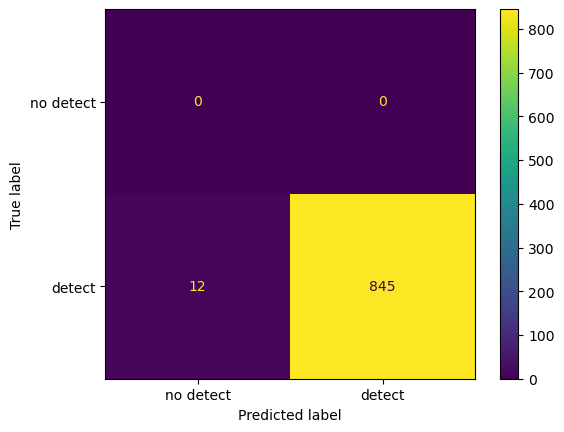

In [10]:
cm = metrics.confusion_matrix(labels_detect, predictions_detect)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no detect', 'detect'])
disp.plot()

In [11]:
threshold = 0.5

predictions_gender = list(map(lambda p: (p['gender.Man']/100, 1 if p['gender.Man']/100 >= threshold else 0) if p['bbox'] else None, all_predictions))
                
labels_gender = all_labels

labels_gender, predictions_gender = zip(*list(filter(lambda p: p[0] is not None and p[1] is not None, zip(labels_gender, predictions_gender))))
labels_gender = list(labels_gender)

In [12]:
print(metrics.classification_report(labels_gender, [p[1] for p in predictions_gender], target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.98      0.67      0.80       449
         Man       0.73      0.99      0.84       396

    accuracy                           0.82       845
   macro avg       0.85      0.83      0.82       845
weighted avg       0.86      0.82      0.82       845



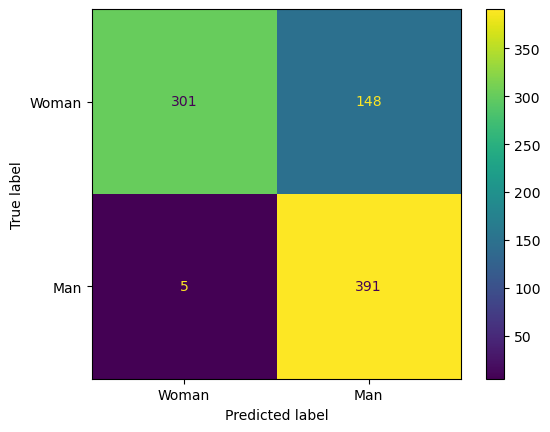

In [13]:
cm = metrics.confusion_matrix(labels_gender, [p[1] for p in predictions_gender])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Woman', 'Man'])
disp.plot()

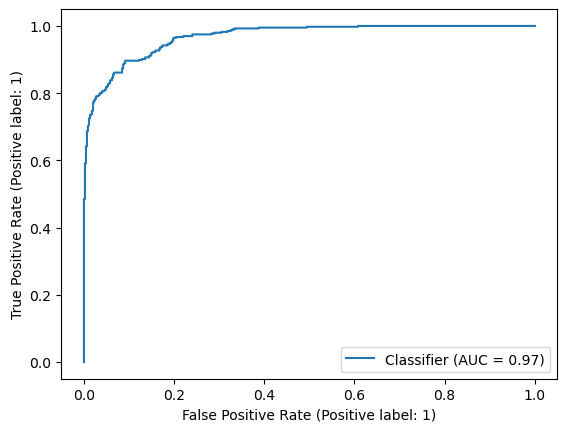

In [14]:
disp = metrics.RocCurveDisplay.from_predictions(labels_gender, [p[0] for p in predictions_gender])
disp

(array([230.,  25.,  10.,   8.,   5.,   6.,   6.,   6.,  10.,   0.,   5.,
          7.,   8.,   2.,  11.,   5.,  14.,  17.,  38., 432.]),
 array([3.70000000e-10, 5.00000004e-02, 1.00000000e-01, 1.50000000e-01,
        2.00000000e-01, 2.50000000e-01, 3.00000000e-01, 3.50000000e-01,
        4.00000000e-01, 4.50000000e-01, 5.00000000e-01, 5.50000000e-01,
        6.00000000e-01, 6.50000000e-01, 7.00000000e-01, 7.50000000e-01,
        8.00000000e-01, 8.50000000e-01, 9.00000000e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

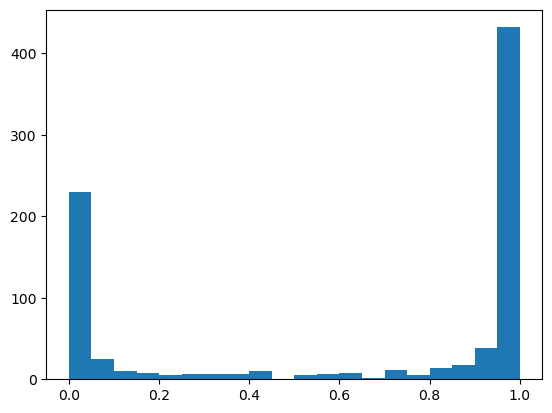

In [15]:
plt.hist([p[0] for p in predictions_gender], bins=20)

## Gender classifier calibration

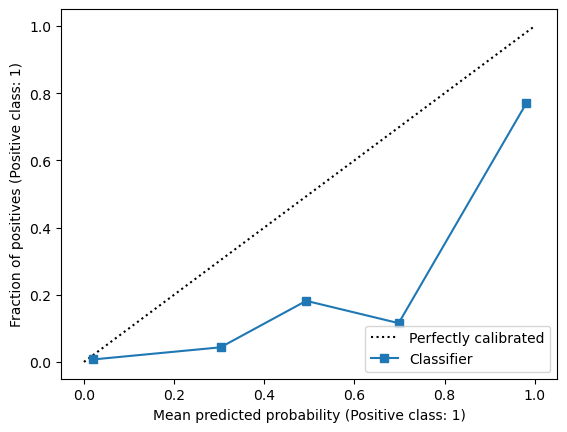

In [40]:
disp = calibration.CalibrationDisplay.from_predictions(labels_gender, [p[0] for p in predictions_gender], n_bins=5)
disp

In [41]:
predictions_gender_train, predictions_gender_test, labels_gender_train, labels_gender_test = model_selection.train_test_split(
    predictions_gender, labels_gender,
    test_size=0.33,
    stratify=labels_gender,
    random_state=42)

In [42]:
class IdentityClassifier(base.TransformerMixin, base.ClassifierMixin, base.BaseEstimator):
    def __init__(self, threshold):
        super().__init__()
        self.classes_ = np.array(range(0, 2))
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def predict_proba(self, X):
        return np.stack((1-X, X), axis=1)
    
    def predict(self, X):
        return np.array([1 if x >= self.threshold else 0 for x in X])

In [45]:
base_clf = IdentityClassifier(threshold=0.5)
pprint(base_clf.predict_proba(np.array([p[0] for p in predictions_gender_train]))[:10])
pprint(np.array([p[0] for p in predictions_gender_train])[:10])

array([[3.57628000e-07, 9.99999642e-01],
       [1.41562223e-02, 9.85843778e-01],
       [1.26599669e-02, 9.87340033e-01],
       [9.99866662e-01, 1.33338224e-04],
       [9.97317935e-01, 2.68206466e-03],
       [9.28060688e-01, 7.19393119e-02],
       [9.99404164e-01, 5.95835911e-04],
       [3.90880108e-02, 9.60911989e-01],
       [7.00950620e-05, 9.99929905e-01],
       [8.62063766e-02, 9.13793623e-01]])
array([9.99999642e-01, 9.85843778e-01, 9.87340033e-01, 1.33338224e-04,
       2.68206466e-03, 7.19393119e-02, 5.95835911e-04, 9.60911989e-01,
       9.99929905e-01, 9.13793623e-01])


In [46]:
calibrated_clf = calibration.CalibratedClassifierCV(base_estimator=base_clf, method='isotonic', cv='prefit')
calibrated_clf.fit(np.array([p[0] for p in predictions_gender_train]), np.array(labels_gender_train))

CalibratedClassifierCV(base_estimator=IdentityClassifier(threshold=0.5),
                       cv='prefit', method='isotonic')

In [47]:
print(metrics.classification_report(labels_gender_test,
                                    calibrated_clf.predict(np.array([p[0] for p in predictions_gender_test])),
                                    target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.87      0.91      0.89       148
         Man       0.89      0.85      0.87       131

    accuracy                           0.88       279
   macro avg       0.88      0.88      0.88       279
weighted avg       0.88      0.88      0.88       279



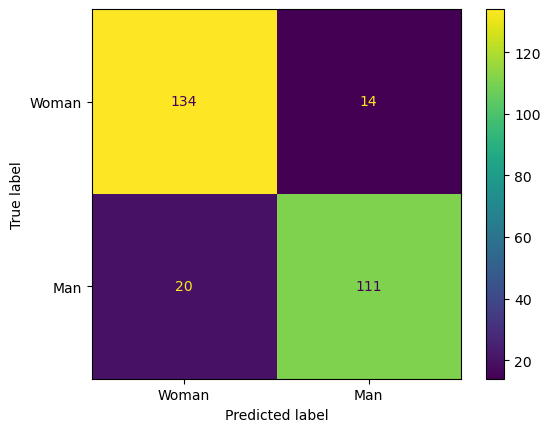

In [48]:
cm = metrics.confusion_matrix(labels_gender_test, calibrated_clf.predict(np.array([p[0] for p in predictions_gender_test])))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Woman', 'Man'])
disp.plot()

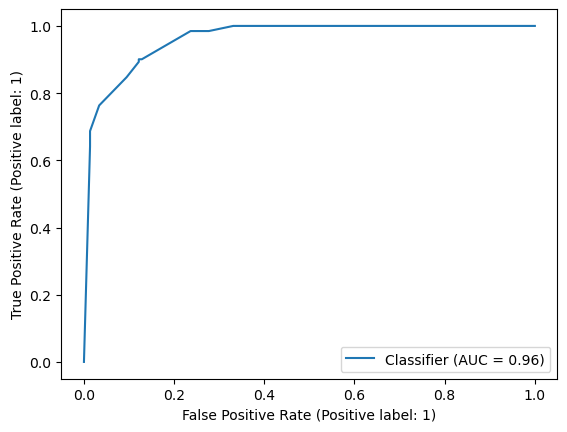

In [65]:
disp = metrics.RocCurveDisplay.from_predictions(labels_gender_test, calibrated_clf.predict_proba(np.array([p[0] for p in predictions_gender_test]))[:, 1])
disp

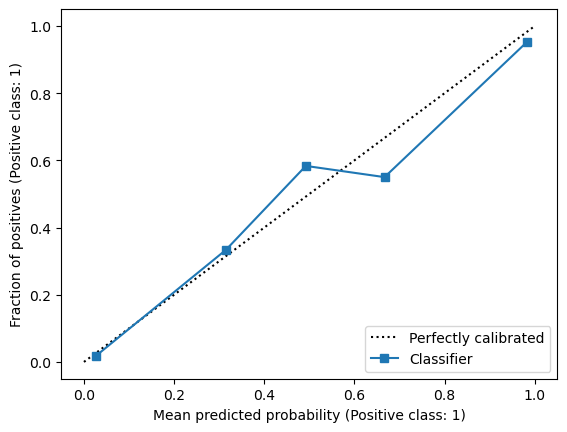

In [50]:
disp = calibration.CalibrationDisplay.from_predictions(labels_gender_test, calibrated_clf.predict_proba(np.array([p[0] for p in predictions_gender_test]))[:, 1], n_bins=5)
disp

In [51]:
calibrated_model_path = Path('./calibrated_model.joblib')

joblib.dump(calibrated_clf, calibrated_model_path)

['calibrated_model.joblib']

In [52]:
calibrated_clf = joblib.load(calibrated_model_path)

In [53]:
print(metrics.classification_report(labels_gender_test,
                                    calibrated_clf.predict(np.array([p[0] for p in predictions_gender_test])),
                                    target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.87      0.91      0.89       148
         Man       0.89      0.85      0.87       131

    accuracy                           0.88       279
   macro avg       0.88      0.88      0.88       279
weighted avg       0.88      0.88      0.88       279



In [79]:
class CalibratedGenderModel:
    
    def __init__(self, gender_model, calibrator):
        self.gender_model = gender_model
        self.calibrator = calibrator
        
    def predict(self, x):
        df_predictions = self.gender_model.predict(x)[:, 1]
        calibrated = self.calibrator.predict_proba(df_predictions)
        return calibrated

In [80]:
calibrated_gender_model = CalibratedGenderModel(
    gender_model=df_default_models['gender'],
    calibrator=calibrated_clf
)

In [83]:
kwargs = {
    'equalize': True,
    'detector_backend': 'mtcnn',
    'actions': ('gender',),
    'models': { 'gender': df_default_models['gender'] }
}

image = cv.imread(str(midjourney_ds[1][0]))
image_predictions(image, **kwargs)

1/1 [==============================] - 0s 157ms/step


{'gender': {'Woman': 68.26837658882141, 'Man': 31.731626391410828},
 'bbox': [73, 55, 138, 157]}

In [84]:
kwargs = {
    'equalize': True,
    'detector_backend': 'mtcnn',
    'actions': ('gender',),
    'models': { 'gender': calibrated_gender_model }
}

image = cv.imread(str(midjourney_ds[1][0]))
image_predictions(image, **kwargs)

1/1 [==============================] - 0s 155ms/step


{'gender': {'Woman': 94.44444444444444, 'Man': 5.555555555555555},
 'bbox': [73, 55, 138, 157]}

In [85]:
kwargs = {
    'equalize': True,
    'detector_backend': 'mtcnn',
    'actions': ('gender',),
    'models': { 'gender': calibrated_gender_model }
}

all_predictions = []

for image_path, label in tqdm(midjourney_ds):
    image = cv.imread(str(image_path))
    assert(image.shape == (256, 256, 3))
    predictions =  image_predictions(image, **kwargs)
    if predictions is None:
        predictions = {}
    predictions['image'] = image_path
    predictions['label'] = label
    all_predictions.append(predictions)

  0%|                                                                                                                   | 0/857 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


  0%|                                                                                                           | 1/857 [00:00<10:38,  1.34it/s]

1/1 [==============================] - 0s 194ms/step


  0%|▏                                                                                                          | 2/857 [00:01<10:55,  1.30it/s]

1/1 [==============================] - 0s 162ms/step


  0%|▎                                                                                                          | 3/857 [00:02<11:05,  1.28it/s]

1/1 [==============================] - 0s 179ms/step


  0%|▍                                                                                                          | 4/857 [00:03<11:11,  1.27it/s]

1/1 [==============================] - 0s 152ms/step


  1%|▌                                                                                                          | 5/857 [00:03<11:04,  1.28it/s]

1/1 [==============================] - 0s 170ms/step


  1%|▋                                                                                                          | 6/857 [00:04<10:59,  1.29it/s]

1/1 [==============================] - 0s 152ms/step


  1%|▊                                                                                                          | 7/857 [00:05<10:46,  1.31it/s]

1/1 [==============================] - 0s 154ms/step


  1%|▉                                                                                                          | 8/857 [00:06<10:39,  1.33it/s]

1/1 [==============================] - 0s 168ms/step


  1%|█                                                                                                          | 9/857 [00:06<10:33,  1.34it/s]

1/1 [==============================] - 0s 160ms/step


  1%|█▏                                                                                                        | 10/857 [00:07<10:28,  1.35it/s]

1/1 [==============================] - 0s 160ms/step


  1%|█▎                                                                                                        | 11/857 [00:08<10:22,  1.36it/s]

1/1 [==============================] - 0s 158ms/step


  1%|█▍                                                                                                        | 12/857 [00:09<10:14,  1.38it/s]

1/1 [==============================] - 0s 156ms/step


  2%|█▌                                                                                                        | 13/857 [00:09<10:14,  1.37it/s]

1/1 [==============================] - 0s 186ms/step


  2%|█▋                                                                                                        | 14/857 [00:10<10:18,  1.36it/s]

1/1 [==============================] - 0s 192ms/step


  2%|█▊                                                                                                        | 15/857 [00:11<10:43,  1.31it/s]

1/1 [==============================] - 0s 168ms/step


  2%|█▉                                                                                                        | 16/857 [00:12<10:37,  1.32it/s]

1/1 [==============================] - 0s 185ms/step


  2%|██                                                                                                        | 17/857 [00:12<10:45,  1.30it/s]

1/1 [==============================] - 0s 186ms/step


  2%|██▏                                                                                                       | 18/857 [00:13<11:00,  1.27it/s]

1/1 [==============================] - 0s 165ms/step


  2%|██▎                                                                                                       | 19/857 [00:14<11:11,  1.25it/s]

1/1 [==============================] - 0s 180ms/step


  2%|██▍                                                                                                       | 20/857 [00:15<11:23,  1.22it/s]

1/1 [==============================] - 0s 167ms/step


  2%|██▌                                                                                                       | 21/857 [00:16<11:21,  1.23it/s]

1/1 [==============================] - 0s 158ms/step


  3%|██▋                                                                                                       | 22/857 [00:16<11:02,  1.26it/s]

1/1 [==============================] - 0s 160ms/step


  3%|██▊                                                                                                       | 23/857 [00:17<10:51,  1.28it/s]

1/1 [==============================] - 0s 156ms/step


  3%|██▉                                                                                                       | 24/857 [00:18<10:37,  1.31it/s]

1/1 [==============================] - 0s 174ms/step


  3%|███                                                                                                       | 25/857 [00:19<10:41,  1.30it/s]

1/1 [==============================] - 0s 158ms/step


  3%|███▏                                                                                                      | 26/857 [00:19<10:41,  1.29it/s]

1/1 [==============================] - 0s 155ms/step


  3%|███▎                                                                                                      | 27/857 [00:20<10:23,  1.33it/s]

1/1 [==============================] - 0s 161ms/step


  3%|███▍                                                                                                      | 28/857 [00:21<10:12,  1.35it/s]

1/1 [==============================] - 0s 164ms/step


  3%|███▌                                                                                                      | 29/857 [00:22<10:02,  1.38it/s]

1/1 [==============================] - 0s 158ms/step


  4%|███▋                                                                                                      | 30/857 [00:22<10:03,  1.37it/s]

1/1 [==============================] - 0s 161ms/step


  4%|███▊                                                                                                      | 31/857 [00:23<09:59,  1.38it/s]

1/1 [==============================] - 0s 161ms/step


  4%|███▉                                                                                                      | 32/857 [00:24<09:51,  1.40it/s]

1/1 [==============================] - 0s 161ms/step


  4%|████                                                                                                      | 33/857 [00:24<09:55,  1.38it/s]

1/1 [==============================] - 0s 177ms/step


  4%|████▏                                                                                                     | 34/857 [00:25<09:54,  1.38it/s]

1/1 [==============================] - 0s 171ms/step


  4%|████▎                                                                                                     | 35/857 [00:26<09:57,  1.38it/s]

1/1 [==============================] - 0s 163ms/step


  4%|████▍                                                                                                     | 36/857 [00:27<09:59,  1.37it/s]

1/1 [==============================] - 0s 164ms/step


  4%|████▌                                                                                                     | 37/857 [00:27<09:57,  1.37it/s]

1/1 [==============================] - 0s 163ms/step


  4%|████▋                                                                                                     | 38/857 [00:28<10:06,  1.35it/s]

1/1 [==============================] - 0s 153ms/step


  5%|████▊                                                                                                     | 39/857 [00:29<10:03,  1.36it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████▉                                                                                                     | 40/857 [00:30<10:04,  1.35it/s]

1/1 [==============================] - 0s 159ms/step


  5%|█████                                                                                                     | 41/857 [00:30<10:01,  1.36it/s]

1/1 [==============================] - 0s 159ms/step


  5%|█████▏                                                                                                    | 42/857 [00:31<10:01,  1.35it/s]

1/1 [==============================] - 0s 157ms/step


  5%|█████▎                                                                                                    | 43/857 [00:32<09:56,  1.36it/s]

1/1 [==============================] - 0s 164ms/step


  5%|█████▍                                                                                                    | 44/857 [00:33<09:54,  1.37it/s]

1/1 [==============================] - 0s 156ms/step


  5%|█████▌                                                                                                    | 45/857 [00:33<09:46,  1.38it/s]

1/1 [==============================] - 0s 165ms/step


  5%|█████▋                                                                                                    | 46/857 [00:34<09:39,  1.40it/s]

1/1 [==============================] - 0s 165ms/step


  5%|█████▊                                                                                                    | 47/857 [00:35<09:36,  1.41it/s]

1/1 [==============================] - 0s 162ms/step


  6%|█████▉                                                                                                    | 48/857 [00:35<09:51,  1.37it/s]

1/1 [==============================] - 0s 162ms/step


  6%|██████                                                                                                    | 49/857 [00:36<09:49,  1.37it/s]

1/1 [==============================] - 0s 163ms/step


  6%|██████▏                                                                                                   | 50/857 [00:37<09:40,  1.39it/s]

1/1 [==============================] - 0s 158ms/step


  6%|██████▎                                                                                                   | 51/857 [00:38<09:50,  1.37it/s]

2/2 [==============================] - 0s 5ms/step


  6%|██████▍                                                                                                   | 52/857 [00:38<08:41,  1.54it/s]

1/1 [==============================] - 0s 167ms/step


  6%|██████▌                                                                                                   | 53/857 [00:39<09:01,  1.48it/s]

1/1 [==============================] - 0s 158ms/step


  6%|██████▋                                                                                                   | 54/857 [00:39<09:01,  1.48it/s]

1/1 [==============================] - 0s 161ms/step


  6%|██████▊                                                                                                   | 55/857 [00:40<09:14,  1.45it/s]

1/1 [==============================] - 0s 171ms/step


  7%|██████▉                                                                                                   | 56/857 [00:41<09:16,  1.44it/s]

1/1 [==============================] - 0s 162ms/step


  7%|███████                                                                                                   | 57/857 [00:42<09:23,  1.42it/s]

1/1 [==============================] - 0s 168ms/step


  7%|███████▏                                                                                                  | 58/857 [00:42<09:17,  1.43it/s]

1/1 [==============================] - 0s 163ms/step


  7%|███████▎                                                                                                  | 59/857 [00:43<09:20,  1.42it/s]

1/1 [==============================] - 0s 174ms/step


  7%|███████▍                                                                                                  | 60/857 [00:44<09:32,  1.39it/s]

1/1 [==============================] - 0s 161ms/step


  7%|███████▌                                                                                                  | 61/857 [00:45<09:39,  1.37it/s]

1/1 [==============================] - 0s 166ms/step


  7%|███████▋                                                                                                  | 62/857 [00:45<09:46,  1.36it/s]

1/1 [==============================] - 0s 161ms/step


  7%|███████▊                                                                                                  | 63/857 [00:46<09:44,  1.36it/s]

1/1 [==============================] - 0s 164ms/step


  7%|███████▉                                                                                                  | 64/857 [00:47<09:49,  1.35it/s]

1/1 [==============================] - 0s 162ms/step


  8%|████████                                                                                                  | 65/857 [00:48<10:35,  1.25it/s]

1/1 [==============================] - 0s 162ms/step


  8%|████████▏                                                                                                 | 66/857 [00:48<10:00,  1.32it/s]

1/1 [==============================] - 0s 174ms/step


  8%|████████▎                                                                                                 | 67/857 [00:49<09:51,  1.34it/s]

1/1 [==============================] - 0s 161ms/step


  8%|████████▍                                                                                                 | 68/857 [00:50<09:43,  1.35it/s]

1/1 [==============================] - 0s 165ms/step


  8%|████████▌                                                                                                 | 69/857 [00:51<09:38,  1.36it/s]

1/1 [==============================] - 0s 174ms/step


  8%|████████▋                                                                                                 | 70/857 [00:51<09:41,  1.35it/s]

1/1 [==============================] - 0s 163ms/step


  8%|████████▊                                                                                                 | 71/857 [00:52<09:43,  1.35it/s]

1/1 [==============================] - 0s 162ms/step


  8%|████████▉                                                                                                 | 72/857 [00:53<09:43,  1.35it/s]

1/1 [==============================] - 0s 167ms/step


  9%|█████████                                                                                                 | 73/857 [00:53<09:29,  1.38it/s]

1/1 [==============================] - 0s 173ms/step


  9%|█████████▏                                                                                                | 74/857 [00:54<09:38,  1.35it/s]

1/1 [==============================] - 0s 164ms/step


  9%|█████████▎                                                                                                | 75/857 [00:55<10:03,  1.30it/s]

1/1 [==============================] - 0s 168ms/step


  9%|█████████▍                                                                                                | 76/857 [00:56<09:44,  1.34it/s]

1/1 [==============================] - 0s 164ms/step


  9%|█████████▌                                                                                                | 77/857 [00:57<09:37,  1.35it/s]

1/1 [==============================] - 0s 167ms/step


  9%|█████████▋                                                                                                | 78/857 [00:57<09:40,  1.34it/s]

1/1 [==============================] - 0s 163ms/step


  9%|█████████▊                                                                                                | 79/857 [00:58<09:34,  1.35it/s]

1/1 [==============================] - 0s 171ms/step


  9%|█████████▉                                                                                                | 80/857 [00:59<09:37,  1.35it/s]

1/1 [==============================] - 0s 172ms/step


  9%|██████████                                                                                                | 81/857 [01:00<09:37,  1.34it/s]

1/1 [==============================] - 0s 190ms/step


 10%|██████████▏                                                                                               | 82/857 [01:00<09:43,  1.33it/s]

1/1 [==============================] - 0s 195ms/step


 10%|██████████▎                                                                                               | 83/857 [01:01<09:48,  1.32it/s]

1/1 [==============================] - 0s 172ms/step


 10%|██████████▍                                                                                               | 84/857 [01:02<09:49,  1.31it/s]

1/1 [==============================] - 0s 170ms/step


 10%|██████████▌                                                                                               | 85/857 [01:03<09:44,  1.32it/s]

1/1 [==============================] - 0s 170ms/step


 10%|██████████▋                                                                                               | 86/857 [01:03<09:34,  1.34it/s]

1/1 [==============================] - 0s 166ms/step


 10%|██████████▊                                                                                               | 87/857 [01:04<09:29,  1.35it/s]

1/1 [==============================] - 0s 169ms/step


 10%|██████████▉                                                                                               | 88/857 [01:05<09:31,  1.35it/s]

1/1 [==============================] - 0s 180ms/step


 10%|███████████                                                                                               | 89/857 [01:05<09:29,  1.35it/s]

1/1 [==============================] - 0s 169ms/step


 11%|███████████▏                                                                                              | 90/857 [01:06<09:31,  1.34it/s]

1/1 [==============================] - 0s 184ms/step


 11%|███████████▎                                                                                              | 91/857 [01:07<09:43,  1.31it/s]

1/1 [==============================] - 0s 189ms/step


 11%|███████████▍                                                                                              | 92/857 [01:08<09:39,  1.32it/s]

1/1 [==============================] - 0s 169ms/step


 11%|███████████▌                                                                                              | 93/857 [01:09<09:46,  1.30it/s]

1/1 [==============================] - 0s 159ms/step


 11%|███████████▋                                                                                              | 94/857 [01:09<09:33,  1.33it/s]

1/1 [==============================] - 0s 168ms/step


 11%|███████████▊                                                                                              | 95/857 [01:10<09:20,  1.36it/s]

1/1 [==============================] - 0s 165ms/step


 11%|███████████▊                                                                                              | 96/857 [01:11<09:22,  1.35it/s]

1/1 [==============================] - 0s 173ms/step


 11%|███████████▉                                                                                              | 97/857 [01:11<09:23,  1.35it/s]

1/1 [==============================] - 0s 176ms/step


 11%|████████████                                                                                              | 98/857 [01:12<09:19,  1.36it/s]

1/1 [==============================] - 0s 169ms/step


 12%|████████████▏                                                                                             | 99/857 [01:13<09:24,  1.34it/s]

1/1 [==============================] - 0s 166ms/step


 12%|████████████▎                                                                                            | 100/857 [01:14<09:12,  1.37it/s]

1/1 [==============================] - 0s 166ms/step


 12%|████████████▎                                                                                            | 101/857 [01:14<09:09,  1.38it/s]

1/1 [==============================] - 0s 180ms/step


 12%|████████████▍                                                                                            | 102/857 [01:15<09:10,  1.37it/s]

1/1 [==============================] - 0s 168ms/step


 12%|████████████▌                                                                                            | 103/857 [01:16<09:08,  1.37it/s]

1/1 [==============================] - 0s 164ms/step


 12%|████████████▋                                                                                            | 104/857 [01:17<09:02,  1.39it/s]

1/1 [==============================] - 0s 172ms/step


 12%|████████████▊                                                                                            | 105/857 [01:17<09:28,  1.32it/s]

1/1 [==============================] - 0s 163ms/step


 12%|████████████▉                                                                                            | 106/857 [01:18<09:26,  1.32it/s]

1/1 [==============================] - 0s 165ms/step


 12%|█████████████                                                                                            | 107/857 [01:19<09:12,  1.36it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█████████████▏                                                                                           | 108/857 [01:20<09:13,  1.35it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█████████████▎                                                                                           | 109/857 [01:20<09:15,  1.35it/s]

1/1 [==============================] - 0s 170ms/step


 13%|█████████████▍                                                                                           | 110/857 [01:21<09:17,  1.34it/s]

1/1 [==============================] - 0s 168ms/step


 13%|█████████████▌                                                                                           | 111/857 [01:22<09:19,  1.33it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█████████████▋                                                                                           | 112/857 [01:23<09:18,  1.33it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█████████████▊                                                                                           | 113/857 [01:23<09:19,  1.33it/s]

1/1 [==============================] - 0s 171ms/step


 13%|█████████████▉                                                                                           | 114/857 [01:24<09:19,  1.33it/s]

1/1 [==============================] - 0s 176ms/step


 13%|██████████████                                                                                           | 115/857 [01:25<09:13,  1.34it/s]

1/1 [==============================] - 0s 176ms/step


 14%|██████████████▏                                                                                          | 116/857 [01:26<09:15,  1.33it/s]

1/1 [==============================] - 0s 161ms/step


 14%|██████████████▎                                                                                          | 117/857 [01:26<09:08,  1.35it/s]

1/1 [==============================] - 0s 171ms/step


 14%|██████████████▍                                                                                          | 118/857 [01:27<09:04,  1.36it/s]

1/1 [==============================] - 0s 170ms/step


 14%|██████████████▌                                                                                          | 119/857 [01:28<09:11,  1.34it/s]

1/1 [==============================] - 0s 169ms/step


 14%|██████████████▋                                                                                          | 120/857 [01:29<09:04,  1.35it/s]

1/1 [==============================] - 0s 165ms/step


 14%|██████████████▊                                                                                          | 121/857 [01:29<08:58,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 14%|██████████████▉                                                                                          | 122/857 [01:30<08:08,  1.50it/s]

1/1 [==============================] - 0s 168ms/step


 14%|███████████████                                                                                          | 123/857 [01:30<08:19,  1.47it/s]

1/1 [==============================] - 0s 169ms/step


 14%|███████████████▏                                                                                         | 124/857 [01:31<08:31,  1.43it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████████▎                                                                                         | 125/857 [01:32<08:43,  1.40it/s]

1/1 [==============================] - 0s 165ms/step


 15%|███████████████▍                                                                                         | 126/857 [01:33<08:50,  1.38it/s]

1/1 [==============================] - 0s 167ms/step


 15%|███████████████▌                                                                                         | 127/857 [01:34<08:58,  1.35it/s]

1/1 [==============================] - 0s 171ms/step


 15%|███████████████▋                                                                                         | 128/857 [01:34<08:51,  1.37it/s]

1/1 [==============================] - 0s 175ms/step


 15%|███████████████▊                                                                                         | 129/857 [01:35<08:57,  1.36it/s]

1/1 [==============================] - 0s 169ms/step


 15%|███████████████▉                                                                                         | 130/857 [01:36<08:52,  1.37it/s]

1/1 [==============================] - 0s 178ms/step


 15%|████████████████                                                                                         | 131/857 [01:36<08:45,  1.38it/s]

1/1 [==============================] - 0s 170ms/step


 15%|████████████████▏                                                                                        | 132/857 [01:37<08:42,  1.39it/s]

1/1 [==============================] - 0s 172ms/step


 16%|████████████████▎                                                                                        | 133/857 [01:38<08:51,  1.36it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████████▍                                                                                        | 134/857 [01:39<08:44,  1.38it/s]

1/1 [==============================] - 0s 167ms/step


 16%|████████████████▌                                                                                        | 135/857 [01:39<08:38,  1.39it/s]

1/1 [==============================] - 0s 171ms/step


 16%|████████████████▋                                                                                        | 136/857 [01:40<08:50,  1.36it/s]

1/1 [==============================] - 0s 168ms/step


 16%|████████████████▊                                                                                        | 137/857 [01:41<08:50,  1.36it/s]

1/1 [==============================] - 0s 170ms/step


 16%|████████████████▉                                                                                        | 138/857 [01:42<08:46,  1.36it/s]

1/1 [==============================] - 0s 176ms/step


 16%|█████████████████                                                                                        | 139/857 [01:42<08:39,  1.38it/s]

1/1 [==============================] - 0s 169ms/step


 16%|█████████████████▏                                                                                       | 140/857 [01:43<08:39,  1.38it/s]

1/1 [==============================] - 0s 177ms/step


 16%|█████████████████▎                                                                                       | 141/857 [01:44<08:52,  1.35it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████████▍                                                                                       | 142/857 [01:44<08:53,  1.34it/s]

1/1 [==============================] - 0s 183ms/step


 17%|█████████████████▌                                                                                       | 143/857 [01:45<08:59,  1.32it/s]

1/1 [==============================] - 0s 177ms/step


 17%|█████████████████▋                                                                                       | 144/857 [01:46<08:54,  1.33it/s]

1/1 [==============================] - 0s 180ms/step


 17%|█████████████████▊                                                                                       | 145/857 [01:47<09:03,  1.31it/s]

1/1 [==============================] - 0s 175ms/step


 17%|█████████████████▉                                                                                       | 146/857 [01:48<09:02,  1.31it/s]

1/1 [==============================] - 0s 180ms/step


 17%|██████████████████                                                                                       | 147/857 [01:48<09:03,  1.31it/s]

1/1 [==============================] - 0s 172ms/step


 17%|██████████████████▏                                                                                      | 148/857 [01:49<08:58,  1.32it/s]

1/1 [==============================] - 0s 170ms/step


 17%|██████████████████▎                                                                                      | 149/857 [01:50<09:00,  1.31it/s]

1/1 [==============================] - 0s 177ms/step


 18%|██████████████████▍                                                                                      | 150/857 [01:51<08:58,  1.31it/s]

1/1 [==============================] - 0s 173ms/step


 18%|██████████████████▌                                                                                      | 151/857 [01:51<08:52,  1.33it/s]

1/1 [==============================] - 0s 173ms/step


 18%|██████████████████▌                                                                                      | 152/857 [01:52<09:00,  1.30it/s]

1/1 [==============================] - 0s 174ms/step


 18%|██████████████████▋                                                                                      | 153/857 [01:53<08:47,  1.33it/s]

1/1 [==============================] - 0s 187ms/step


 18%|██████████████████▊                                                                                      | 154/857 [01:54<08:56,  1.31it/s]

1/1 [==============================] - 0s 174ms/step


 18%|██████████████████▉                                                                                      | 155/857 [01:54<09:02,  1.29it/s]

1/1 [==============================] - 0s 183ms/step


 18%|███████████████████                                                                                      | 156/857 [01:55<09:04,  1.29it/s]

1/1 [==============================] - 0s 205ms/step


 18%|███████████████████▏                                                                                     | 157/857 [01:56<09:06,  1.28it/s]

1/1 [==============================] - 0s 188ms/step


 18%|███████████████████▎                                                                                     | 158/857 [01:57<09:10,  1.27it/s]

1/1 [==============================] - 0s 202ms/step


 19%|███████████████████▍                                                                                     | 159/857 [01:58<09:11,  1.27it/s]

1/1 [==============================] - 0s 177ms/step


 19%|███████████████████▌                                                                                     | 160/857 [01:58<09:19,  1.25it/s]

1/1 [==============================] - 0s 186ms/step


 19%|███████████████████▋                                                                                     | 161/857 [01:59<09:15,  1.25it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████████▊                                                                                     | 162/857 [02:00<09:13,  1.26it/s]

1/1 [==============================] - 0s 175ms/step


 19%|███████████████████▉                                                                                     | 163/857 [02:01<09:03,  1.28it/s]

1/1 [==============================] - 0s 179ms/step


 19%|████████████████████                                                                                     | 164/857 [02:02<09:00,  1.28it/s]

1/1 [==============================] - 0s 177ms/step


 19%|████████████████████▏                                                                                    | 165/857 [02:03<09:45,  1.18it/s]

1/1 [==============================] - 0s 178ms/step


 19%|████████████████████▎                                                                                    | 166/857 [02:03<09:33,  1.21it/s]

1/1 [==============================] - 0s 180ms/step


 19%|████████████████████▍                                                                                    | 167/857 [02:04<09:12,  1.25it/s]

1/1 [==============================] - 0s 177ms/step


 20%|████████████████████▌                                                                                    | 168/857 [02:05<08:58,  1.28it/s]

1/1 [==============================] - 0s 186ms/step


 20%|████████████████████▋                                                                                    | 169/857 [02:06<08:59,  1.28it/s]

1/1 [==============================] - 0s 180ms/step


 20%|████████████████████▊                                                                                    | 170/857 [02:06<08:56,  1.28it/s]

1/1 [==============================] - 0s 187ms/step


 20%|████████████████████▉                                                                                    | 171/857 [02:07<08:51,  1.29it/s]

1/1 [==============================] - 0s 189ms/step


 20%|█████████████████████                                                                                    | 172/857 [02:08<08:51,  1.29it/s]

1/1 [==============================] - 0s 189ms/step


 20%|█████████████████████▏                                                                                   | 173/857 [02:09<08:53,  1.28it/s]

1/1 [==============================] - 0s 182ms/step


 20%|█████████████████████▎                                                                                   | 174/857 [02:09<08:53,  1.28it/s]

1/1 [==============================] - 0s 180ms/step


 20%|█████████████████████▍                                                                                   | 175/857 [02:10<08:53,  1.28it/s]

1/1 [==============================] - 0s 190ms/step


 21%|█████████████████████▌                                                                                   | 176/857 [02:11<09:15,  1.23it/s]

1/1 [==============================] - 0s 184ms/step


 21%|█████████████████████▋                                                                                   | 177/857 [02:12<09:01,  1.26it/s]

1/1 [==============================] - 0s 189ms/step


 21%|█████████████████████▊                                                                                   | 178/857 [02:13<08:53,  1.27it/s]

1/1 [==============================] - 0s 182ms/step


 21%|█████████████████████▉                                                                                   | 179/857 [02:13<08:52,  1.27it/s]

1/1 [==============================] - 0s 191ms/step


 21%|██████████████████████                                                                                   | 180/857 [02:14<08:45,  1.29it/s]

1/1 [==============================] - 0s 197ms/step


 21%|██████████████████████▏                                                                                  | 181/857 [02:15<08:46,  1.28it/s]

1/1 [==============================] - 0s 213ms/step


 21%|██████████████████████▎                                                                                  | 182/857 [02:16<08:50,  1.27it/s]

1/1 [==============================] - 0s 224ms/step


 21%|██████████████████████▍                                                                                  | 183/857 [02:17<08:55,  1.26it/s]

1/1 [==============================] - 0s 212ms/step


 21%|██████████████████████▌                                                                                  | 184/857 [02:17<08:59,  1.25it/s]

1/1 [==============================] - 0s 210ms/step


 22%|██████████████████████▋                                                                                  | 185/857 [02:18<08:57,  1.25it/s]

1/1 [==============================] - 0s 219ms/step


 22%|██████████████████████▊                                                                                  | 186/857 [02:19<08:52,  1.26it/s]

1/1 [==============================] - 0s 218ms/step


 22%|██████████████████████▉                                                                                  | 187/857 [02:20<08:48,  1.27it/s]

1/1 [==============================] - 0s 221ms/step


 22%|███████████████████████                                                                                  | 188/857 [02:21<08:52,  1.26it/s]

1/1 [==============================] - 0s 222ms/step


 22%|███████████████████████▏                                                                                 | 189/857 [02:21<08:53,  1.25it/s]

1/1 [==============================] - 0s 227ms/step


 22%|███████████████████████▎                                                                                 | 190/857 [02:22<08:57,  1.24it/s]

1/1 [==============================] - 0s 226ms/step


 22%|███████████████████████▍                                                                                 | 191/857 [02:23<09:00,  1.23it/s]

1/1 [==============================] - 0s 207ms/step


 22%|███████████████████████▌                                                                                 | 192/857 [02:24<08:54,  1.25it/s]

1/1 [==============================] - 0s 236ms/step


 23%|███████████████████████▋                                                                                 | 193/857 [02:25<08:55,  1.24it/s]

1/1 [==============================] - 0s 279ms/step


 23%|███████████████████████▊                                                                                 | 194/857 [02:25<09:03,  1.22it/s]

1/1 [==============================] - 0s 348ms/step


 23%|███████████████████████▉                                                                                 | 195/857 [02:26<09:23,  1.17it/s]

1/1 [==============================] - 0s 308ms/step


 23%|████████████████████████                                                                                 | 196/857 [02:27<09:33,  1.15it/s]

1/1 [==============================] - 0s 329ms/step


 23%|████████████████████████▏                                                                                | 197/857 [02:28<09:38,  1.14it/s]

1/1 [==============================] - 0s 336ms/step


 23%|████████████████████████▎                                                                                | 198/857 [02:29<09:44,  1.13it/s]

1/1 [==============================] - 0s 334ms/step


 23%|████████████████████████▍                                                                                | 199/857 [02:30<09:50,  1.12it/s]

1/1 [==============================] - 0s 344ms/step


 23%|████████████████████████▌                                                                                | 200/857 [02:31<09:58,  1.10it/s]

1/1 [==============================] - 0s 302ms/step


 23%|████████████████████████▋                                                                                | 201/857 [02:32<09:47,  1.12it/s]

1/1 [==============================] - 0s 335ms/step


 24%|████████████████████████▋                                                                                | 202/857 [02:33<10:05,  1.08it/s]

1/1 [==============================] - 0s 340ms/step


 24%|████████████████████████▊                                                                                | 203/857 [02:34<10:07,  1.08it/s]

1/1 [==============================] - 0s 341ms/step


 24%|████████████████████████▉                                                                                | 204/857 [02:35<10:04,  1.08it/s]

1/1 [==============================] - 0s 341ms/step


 24%|█████████████████████████                                                                                | 205/857 [02:36<10:02,  1.08it/s]

1/1 [==============================] - 0s 362ms/step


 24%|█████████████████████████▏                                                                               | 206/857 [02:37<10:09,  1.07it/s]

1/1 [==============================] - 0s 334ms/step


 24%|█████████████████████████▎                                                                               | 207/857 [02:37<09:58,  1.09it/s]

1/1 [==============================] - 0s 371ms/step


 24%|█████████████████████████▍                                                                               | 208/857 [02:38<10:08,  1.07it/s]

1/1 [==============================] - 0s 345ms/step


 24%|█████████████████████████▌                                                                               | 209/857 [02:39<10:02,  1.08it/s]

1/1 [==============================] - 0s 348ms/step


 25%|█████████████████████████▋                                                                               | 210/857 [02:40<10:06,  1.07it/s]

1/1 [==============================] - 0s 364ms/step


 25%|█████████████████████████▊                                                                               | 211/857 [02:41<10:07,  1.06it/s]

1/1 [==============================] - 0s 365ms/step


 25%|█████████████████████████▉                                                                               | 212/857 [02:42<10:15,  1.05it/s]

1/1 [==============================] - 0s 331ms/step


 25%|██████████████████████████                                                                               | 213/857 [02:43<10:08,  1.06it/s]

1/1 [==============================] - 0s 346ms/step


 25%|██████████████████████████▏                                                                              | 214/857 [02:44<10:08,  1.06it/s]

1/1 [==============================] - 0s 372ms/step


 25%|██████████████████████████▎                                                                              | 215/857 [02:45<10:06,  1.06it/s]

1/1 [==============================] - 0s 366ms/step


 25%|██████████████████████████▍                                                                              | 216/857 [02:46<10:07,  1.06it/s]

1/1 [==============================] - 0s 381ms/step


 25%|██████████████████████████▌                                                                              | 217/857 [02:47<10:17,  1.04it/s]

1/1 [==============================] - 0s 374ms/step


 25%|██████████████████████████▋                                                                              | 218/857 [02:48<10:17,  1.03it/s]

1/1 [==============================] - 0s 362ms/step


 26%|██████████████████████████▊                                                                              | 219/857 [02:49<10:14,  1.04it/s]

1/1 [==============================] - 0s 377ms/step


 26%|██████████████████████████▉                                                                              | 220/857 [02:50<10:08,  1.05it/s]

1/1 [==============================] - 0s 329ms/step


 26%|███████████████████████████                                                                              | 221/857 [02:51<09:56,  1.07it/s]

1/1 [==============================] - 0s 319ms/step


 26%|███████████████████████████▏                                                                             | 222/857 [02:52<09:44,  1.09it/s]

1/1 [==============================] - 0s 376ms/step


 26%|███████████████████████████▎                                                                             | 223/857 [02:53<09:55,  1.06it/s]

1/1 [==============================] - 0s 392ms/step


 26%|███████████████████████████▍                                                                             | 224/857 [02:54<09:58,  1.06it/s]

1/1 [==============================] - 0s 358ms/step


 26%|███████████████████████████▌                                                                             | 225/857 [02:55<09:55,  1.06it/s]

1/1 [==============================] - 0s 363ms/step


 26%|███████████████████████████▋                                                                             | 226/857 [02:56<09:55,  1.06it/s]

1/1 [==============================] - 0s 377ms/step


 26%|███████████████████████████▊                                                                             | 227/857 [02:56<09:54,  1.06it/s]

1/1 [==============================] - 0s 331ms/step


 27%|███████████████████████████▉                                                                             | 228/857 [02:57<09:47,  1.07it/s]

1/1 [==============================] - 0s 331ms/step


 27%|████████████████████████████                                                                             | 229/857 [02:58<09:47,  1.07it/s]

1/1 [==============================] - 0s 397ms/step


 27%|████████████████████████████▏                                                                            | 230/857 [02:59<09:55,  1.05it/s]

1/1 [==============================] - 0s 349ms/step


 27%|████████████████████████████▎                                                                            | 231/857 [03:00<09:55,  1.05it/s]

1/1 [==============================] - 0s 412ms/step


 27%|████████████████████████████▍                                                                            | 232/857 [03:01<10:43,  1.03s/it]

1/1 [==============================] - 0s 346ms/step


 27%|████████████████████████████▌                                                                            | 233/857 [03:02<10:40,  1.03s/it]

1/1 [==============================] - 0s 374ms/step


 27%|████████████████████████████▋                                                                            | 234/857 [03:03<10:30,  1.01s/it]

1/1 [==============================] - 0s 379ms/step


 27%|████████████████████████████▊                                                                            | 235/857 [03:04<10:24,  1.00s/it]

1/1 [==============================] - 0s 375ms/step


 28%|████████████████████████████▉                                                                            | 236/857 [03:05<10:14,  1.01it/s]

1/1 [==============================] - 0s 407ms/step


 28%|█████████████████████████████                                                                            | 237/857 [03:06<10:16,  1.01it/s]

1/1 [==============================] - 0s 396ms/step


 28%|█████████████████████████████▏                                                                           | 238/857 [03:07<10:12,  1.01it/s]

1/1 [==============================] - 0s 410ms/step


 28%|█████████████████████████████▎                                                                           | 239/857 [03:08<10:19,  1.00s/it]

1/1 [==============================] - 0s 383ms/step


 28%|█████████████████████████████▍                                                                           | 240/857 [03:09<10:11,  1.01it/s]

1/1 [==============================] - 0s 358ms/step


 28%|█████████████████████████████▌                                                                           | 241/857 [03:10<10:03,  1.02it/s]

1/1 [==============================] - 0s 380ms/step


 28%|█████████████████████████████▋                                                                           | 242/857 [03:11<10:11,  1.01it/s]

1/1 [==============================] - 0s 369ms/step


 28%|█████████████████████████████▊                                                                           | 243/857 [03:12<10:02,  1.02it/s]

1/1 [==============================] - 0s 384ms/step


 28%|█████████████████████████████▉                                                                           | 244/857 [03:13<10:02,  1.02it/s]

1/1 [==============================] - 0s 402ms/step


 29%|██████████████████████████████                                                                           | 245/857 [03:14<10:07,  1.01it/s]

1/1 [==============================] - 0s 354ms/step


 29%|██████████████████████████████▏                                                                          | 246/857 [03:15<10:05,  1.01it/s]

1/1 [==============================] - 0s 442ms/step


 29%|██████████████████████████████▎                                                                          | 247/857 [03:16<10:05,  1.01it/s]

1/1 [==============================] - 0s 444ms/step


 29%|██████████████████████████████▍                                                                          | 248/857 [03:17<10:17,  1.01s/it]

1/1 [==============================] - 0s 415ms/step


 29%|██████████████████████████████▌                                                                          | 249/857 [03:18<10:20,  1.02s/it]

1/1 [==============================] - 0s 391ms/step


 29%|██████████████████████████████▋                                                                          | 250/857 [03:19<10:26,  1.03s/it]

1/1 [==============================] - 0s 411ms/step


 29%|██████████████████████████████▊                                                                          | 251/857 [03:20<10:20,  1.02s/it]

1/1 [==============================] - 0s 376ms/step


 29%|██████████████████████████████▉                                                                          | 252/857 [03:21<10:12,  1.01s/it]

1/1 [==============================] - 0s 405ms/step


 30%|██████████████████████████████▉                                                                          | 253/857 [03:22<10:06,  1.00s/it]

1/1 [==============================] - 0s 446ms/step


 30%|███████████████████████████████                                                                          | 254/857 [03:23<10:08,  1.01s/it]

1/1 [==============================] - 0s 437ms/step


 30%|███████████████████████████████▏                                                                         | 255/857 [03:24<10:09,  1.01s/it]

1/1 [==============================] - 0s 421ms/step


 30%|███████████████████████████████▎                                                                         | 256/857 [03:26<10:14,  1.02s/it]

1/1 [==============================] - 0s 421ms/step


 30%|███████████████████████████████▍                                                                         | 257/857 [03:27<10:13,  1.02s/it]

1/1 [==============================] - 0s 403ms/step


 30%|███████████████████████████████▌                                                                         | 258/857 [03:28<10:07,  1.01s/it]

1/1 [==============================] - 0s 397ms/step


 30%|███████████████████████████████▋                                                                         | 259/857 [03:29<10:15,  1.03s/it]

1/1 [==============================] - 0s 417ms/step


 30%|███████████████████████████████▊                                                                         | 260/857 [03:30<10:08,  1.02s/it]

1/1 [==============================] - 0s 427ms/step


 30%|███████████████████████████████▉                                                                         | 261/857 [03:31<10:15,  1.03s/it]

1/1 [==============================] - 0s 416ms/step


 31%|████████████████████████████████                                                                         | 262/857 [03:32<10:03,  1.01s/it]

1/1 [==============================] - 0s 397ms/step


 31%|████████████████████████████████▏                                                                        | 263/857 [03:33<10:03,  1.02s/it]

1/1 [==============================] - 0s 448ms/step


 31%|████████████████████████████████▎                                                                        | 264/857 [03:34<10:05,  1.02s/it]

1/1 [==============================] - 0s 430ms/step


 31%|████████████████████████████████▍                                                                        | 265/857 [03:35<10:52,  1.10s/it]

1/1 [==============================] - 0s 474ms/step


 31%|████████████████████████████████▌                                                                        | 266/857 [03:36<10:53,  1.11s/it]

1/1 [==============================] - 0s 426ms/step


 31%|████████████████████████████████▋                                                                        | 267/857 [03:37<10:34,  1.07s/it]

1/1 [==============================] - 0s 422ms/step


 31%|████████████████████████████████▊                                                                        | 268/857 [03:38<10:41,  1.09s/it]

1/1 [==============================] - 0s 436ms/step


 31%|████████████████████████████████▉                                                                        | 269/857 [03:39<10:31,  1.07s/it]

1/1 [==============================] - 0s 440ms/step


 32%|█████████████████████████████████                                                                        | 270/857 [03:40<10:24,  1.06s/it]

1/1 [==============================] - 0s 412ms/step


 32%|█████████████████████████████████▏                                                                       | 271/857 [03:41<10:17,  1.05s/it]

1/1 [==============================] - 0s 447ms/step


 32%|█████████████████████████████████▎                                                                       | 272/857 [03:42<10:16,  1.05s/it]

1/1 [==============================] - 0s 449ms/step


 32%|█████████████████████████████████▍                                                                       | 273/857 [03:43<10:19,  1.06s/it]

1/1 [==============================] - 0s 449ms/step


 32%|█████████████████████████████████▌                                                                       | 274/857 [03:45<10:20,  1.06s/it]

1/1 [==============================] - 0s 444ms/step


 32%|█████████████████████████████████▋                                                                       | 275/857 [03:46<10:18,  1.06s/it]

1/1 [==============================] - 0s 419ms/step


 32%|█████████████████████████████████▊                                                                       | 276/857 [03:47<10:10,  1.05s/it]

1/1 [==============================] - 0s 434ms/step


 32%|█████████████████████████████████▉                                                                       | 277/857 [03:48<10:13,  1.06s/it]

1/1 [==============================] - 0s 408ms/step


 32%|██████████████████████████████████                                                                       | 278/857 [03:49<10:08,  1.05s/it]

1/1 [==============================] - 0s 401ms/step


 33%|██████████████████████████████████▏                                                                      | 279/857 [03:50<09:55,  1.03s/it]

1/1 [==============================] - 1s 521ms/step


 33%|██████████████████████████████████▎                                                                      | 280/857 [03:51<10:07,  1.05s/it]

1/1 [==============================] - 0s 476ms/step


 33%|██████████████████████████████████▍                                                                      | 281/857 [03:52<10:09,  1.06s/it]

1/1 [==============================] - 0s 466ms/step


 33%|██████████████████████████████████▌                                                                      | 282/857 [03:53<10:24,  1.09s/it]

1/1 [==============================] - 0s 467ms/step


 33%|██████████████████████████████████▋                                                                      | 283/857 [03:54<10:20,  1.08s/it]

1/1 [==============================] - 1s 504ms/step


 33%|██████████████████████████████████▊                                                                      | 284/857 [03:55<10:23,  1.09s/it]

1/1 [==============================] - 0s 458ms/step


 33%|██████████████████████████████████▉                                                                      | 285/857 [03:56<10:19,  1.08s/it]

1/1 [==============================] - 1s 522ms/step


 33%|███████████████████████████████████                                                                      | 286/857 [03:57<10:24,  1.09s/it]

1/1 [==============================] - 0s 495ms/step


 33%|███████████████████████████████████▏                                                                     | 287/857 [03:58<10:25,  1.10s/it]

1/1 [==============================] - 0s 487ms/step


 34%|███████████████████████████████████▎                                                                     | 288/857 [04:00<10:28,  1.10s/it]

1/1 [==============================] - 0s 466ms/step


 34%|███████████████████████████████████▍                                                                     | 289/857 [04:01<10:22,  1.10s/it]

1/1 [==============================] - 0s 473ms/step


 34%|███████████████████████████████████▌                                                                     | 290/857 [04:02<10:12,  1.08s/it]

1/1 [==============================] - 0s 458ms/step


 34%|███████████████████████████████████▋                                                                     | 291/857 [04:03<10:13,  1.08s/it]

1/1 [==============================] - 1s 514ms/step


 34%|███████████████████████████████████▊                                                                     | 292/857 [04:04<10:14,  1.09s/it]

1/1 [==============================] - 1s 505ms/step


 34%|███████████████████████████████████▉                                                                     | 293/857 [04:05<10:25,  1.11s/it]

1/1 [==============================] - 1s 501ms/step


 34%|████████████████████████████████████                                                                     | 294/857 [04:06<10:31,  1.12s/it]

1/1 [==============================] - 1s 545ms/step


 34%|████████████████████████████████████▏                                                                    | 295/857 [04:07<10:40,  1.14s/it]

1/1 [==============================] - 1s 530ms/step


 35%|████████████████████████████████████▎                                                                    | 296/857 [04:09<10:43,  1.15s/it]

1/1 [==============================] - 1s 505ms/step


 35%|████████████████████████████████████▍                                                                    | 297/857 [04:10<10:32,  1.13s/it]

1/1 [==============================] - 1s 566ms/step


 35%|████████████████████████████████████▌                                                                    | 298/857 [04:11<10:58,  1.18s/it]

1/1 [==============================] - 1s 606ms/step


 35%|████████████████████████████████████▋                                                                    | 299/857 [04:12<11:14,  1.21s/it]

1/1 [==============================] - 0s 489ms/step


 35%|████████████████████████████████████▊                                                                    | 300/857 [04:13<10:58,  1.18s/it]

1/1 [==============================] - 1s 538ms/step


 35%|████████████████████████████████████▉                                                                    | 301/857 [04:15<10:58,  1.18s/it]

1/1 [==============================] - 1s 507ms/step


 35%|█████████████████████████████████████                                                                    | 302/857 [04:16<10:43,  1.16s/it]

1/1 [==============================] - 1s 563ms/step


 35%|█████████████████████████████████████                                                                    | 303/857 [04:17<10:52,  1.18s/it]

1/1 [==============================] - 1s 524ms/step


 35%|█████████████████████████████████████▏                                                                   | 304/857 [04:18<10:43,  1.16s/it]

1/1 [==============================] - 1s 510ms/step


 36%|█████████████████████████████████████▎                                                                   | 305/857 [04:19<10:43,  1.17s/it]

1/1 [==============================] - 1s 605ms/step


 36%|█████████████████████████████████████▍                                                                   | 306/857 [04:20<10:49,  1.18s/it]

1/1 [==============================] - 1s 564ms/step


 36%|█████████████████████████████████████▌                                                                   | 307/857 [04:22<10:42,  1.17s/it]

1/1 [==============================] - 1s 532ms/step


 36%|█████████████████████████████████████▋                                                                   | 308/857 [04:23<10:33,  1.15s/it]

1/1 [==============================] - 1s 544ms/step


 36%|█████████████████████████████████████▊                                                                   | 309/857 [04:24<10:35,  1.16s/it]

1/1 [==============================] - 1s 590ms/step


 36%|█████████████████████████████████████▉                                                                   | 310/857 [04:25<10:46,  1.18s/it]

1/1 [==============================] - 1s 527ms/step


 36%|██████████████████████████████████████                                                                   | 311/857 [04:26<10:36,  1.17s/it]

1/1 [==============================] - 1s 501ms/step


 36%|██████████████████████████████████████▏                                                                  | 312/857 [04:27<10:34,  1.16s/it]

1/1 [==============================] - 1s 527ms/step


 37%|██████████████████████████████████████▎                                                                  | 313/857 [04:28<10:31,  1.16s/it]

1/1 [==============================] - 1s 543ms/step


 37%|██████████████████████████████████████▍                                                                  | 314/857 [04:30<10:26,  1.15s/it]

1/1 [==============================] - 1s 547ms/step


 37%|██████████████████████████████████████▌                                                                  | 315/857 [04:31<10:22,  1.15s/it]

1/1 [==============================] - 1s 531ms/step


 37%|██████████████████████████████████████▋                                                                  | 316/857 [04:32<10:26,  1.16s/it]

1/1 [==============================] - 1s 605ms/step


 37%|██████████████████████████████████████▊                                                                  | 317/857 [04:33<10:48,  1.20s/it]

1/1 [==============================] - 1s 564ms/step


 37%|██████████████████████████████████████▉                                                                  | 318/857 [04:34<10:44,  1.20s/it]

1/1 [==============================] - 1s 600ms/step


 37%|███████████████████████████████████████                                                                  | 319/857 [04:36<10:43,  1.20s/it]

1/1 [==============================] - 1s 539ms/step


 37%|███████████████████████████████████████▏                                                                 | 320/857 [04:37<10:35,  1.18s/it]

1/1 [==============================] - 1s 535ms/step


 37%|███████████████████████████████████████▎                                                                 | 321/857 [04:38<10:30,  1.18s/it]

1/1 [==============================] - 1s 564ms/step


 38%|███████████████████████████████████████▍                                                                 | 322/857 [04:39<10:31,  1.18s/it]

1/1 [==============================] - 1s 641ms/step


 38%|███████████████████████████████████████▌                                                                 | 323/857 [04:40<10:43,  1.21s/it]

1/1 [==============================] - 1s 525ms/step


 38%|███████████████████████████████████████▋                                                                 | 324/857 [04:41<10:23,  1.17s/it]

1/1 [==============================] - 1s 598ms/step


 38%|███████████████████████████████████████▊                                                                 | 325/857 [04:43<10:37,  1.20s/it]

1/1 [==============================] - 1s 657ms/step


 38%|███████████████████████████████████████▉                                                                 | 326/857 [04:44<10:51,  1.23s/it]

1/1 [==============================] - 1s 587ms/step


 38%|████████████████████████████████████████                                                                 | 327/857 [04:45<10:45,  1.22s/it]

1/1 [==============================] - 1s 618ms/step


 38%|████████████████████████████████████████▏                                                                | 328/857 [04:47<10:53,  1.23s/it]

1/1 [==============================] - 1s 568ms/step


 38%|████████████████████████████████████████▎                                                                | 329/857 [04:48<10:52,  1.24s/it]

1/1 [==============================] - 1s 567ms/step


 39%|████████████████████████████████████████▍                                                                | 330/857 [04:49<10:46,  1.23s/it]

1/1 [==============================] - 1s 637ms/step


 39%|████████████████████████████████████████▌                                                                | 331/857 [04:50<10:49,  1.23s/it]

1/1 [==============================] - 1s 603ms/step


 39%|████████████████████████████████████████▋                                                                | 332/857 [04:51<10:53,  1.24s/it]

1/1 [==============================] - 1s 648ms/step


 39%|████████████████████████████████████████▊                                                                | 333/857 [04:53<10:53,  1.25s/it]

1/1 [==============================] - 1s 635ms/step


 39%|████████████████████████████████████████▉                                                                | 334/857 [04:54<10:53,  1.25s/it]

1/1 [==============================] - 1s 585ms/step


 39%|█████████████████████████████████████████                                                                | 335/857 [04:55<10:46,  1.24s/it]

1/1 [==============================] - 1s 662ms/step


 39%|█████████████████████████████████████████▏                                                               | 336/857 [04:56<10:52,  1.25s/it]

1/1 [==============================] - 1s 568ms/step


 39%|█████████████████████████████████████████▎                                                               | 337/857 [04:58<10:44,  1.24s/it]

1/1 [==============================] - 1s 539ms/step


 39%|█████████████████████████████████████████▍                                                               | 338/857 [04:59<10:35,  1.22s/it]

1/1 [==============================] - 1s 550ms/step


 40%|█████████████████████████████████████████▌                                                               | 339/857 [05:00<10:36,  1.23s/it]

1/1 [==============================] - 1s 548ms/step


 40%|█████████████████████████████████████████▋                                                               | 340/857 [05:01<10:43,  1.24s/it]

1/1 [==============================] - 1s 567ms/step


 40%|█████████████████████████████████████████▊                                                               | 341/857 [05:03<10:46,  1.25s/it]

1/1 [==============================] - 1s 545ms/step


 40%|█████████████████████████████████████████▉                                                               | 342/857 [05:04<10:46,  1.26s/it]

1/1 [==============================] - 1s 551ms/step


 40%|██████████████████████████████████████████                                                               | 343/857 [05:05<10:40,  1.25s/it]

1/1 [==============================] - 1s 543ms/step


 40%|██████████████████████████████████████████▏                                                              | 344/857 [05:07<11:15,  1.32s/it]

1/1 [==============================] - 1s 583ms/step


 40%|██████████████████████████████████████████▎                                                              | 345/857 [05:08<11:30,  1.35s/it]

1/1 [==============================] - 1s 650ms/step


 40%|██████████████████████████████████████████▍                                                              | 346/857 [05:09<11:20,  1.33s/it]

1/1 [==============================] - 1s 621ms/step


 40%|██████████████████████████████████████████▌                                                              | 347/857 [05:11<11:05,  1.30s/it]

1/1 [==============================] - 1s 593ms/step


 41%|██████████████████████████████████████████▋                                                              | 348/857 [05:12<10:52,  1.28s/it]

1/1 [==============================] - 1s 618ms/step


 41%|██████████████████████████████████████████▊                                                              | 349/857 [05:13<10:47,  1.28s/it]

1/1 [==============================] - 1s 625ms/step


 41%|██████████████████████████████████████████▉                                                              | 350/857 [05:14<10:46,  1.28s/it]

1/1 [==============================] - 1s 644ms/step


 41%|███████████████████████████████████████████                                                              | 351/857 [05:16<10:43,  1.27s/it]

1/1 [==============================] - 1s 644ms/step


 41%|███████████████████████████████████████████▏                                                             | 352/857 [05:17<10:47,  1.28s/it]

1/1 [==============================] - 1s 713ms/step


 41%|███████████████████████████████████████████▏                                                             | 353/857 [05:18<10:53,  1.30s/it]

1/1 [==============================] - 1s 619ms/step


 41%|███████████████████████████████████████████▎                                                             | 354/857 [05:19<10:44,  1.28s/it]

1/1 [==============================] - 1s 648ms/step


 41%|███████████████████████████████████████████▍                                                             | 355/857 [05:21<10:40,  1.28s/it]

1/1 [==============================] - 1s 606ms/step


 42%|███████████████████████████████████████████▌                                                             | 356/857 [05:22<10:37,  1.27s/it]

1/1 [==============================] - 1s 657ms/step


 42%|███████████████████████████████████████████▋                                                             | 357/857 [05:23<10:41,  1.28s/it]

1/1 [==============================] - 1s 654ms/step


 42%|███████████████████████████████████████████▊                                                             | 358/857 [05:25<10:44,  1.29s/it]

1/1 [==============================] - 1s 650ms/step


 42%|███████████████████████████████████████████▉                                                             | 359/857 [05:26<10:42,  1.29s/it]

1/1 [==============================] - 1s 608ms/step


 42%|████████████████████████████████████████████                                                             | 360/857 [05:27<10:35,  1.28s/it]

1/1 [==============================] - 1s 652ms/step


 42%|████████████████████████████████████████████▏                                                            | 361/857 [05:28<10:35,  1.28s/it]

1/1 [==============================] - 1s 691ms/step


 42%|████████████████████████████████████████████▎                                                            | 362/857 [05:30<10:38,  1.29s/it]

1/1 [==============================] - 1s 679ms/step


 42%|████████████████████████████████████████████▍                                                            | 363/857 [05:31<10:45,  1.31s/it]

1/1 [==============================] - 1s 669ms/step


 42%|████████████████████████████████████████████▌                                                            | 364/857 [05:32<10:43,  1.30s/it]

1/1 [==============================] - 1s 587ms/step


 43%|████████████████████████████████████████████▋                                                            | 365/857 [05:34<11:03,  1.35s/it]

1/1 [==============================] - 1s 702ms/step


 43%|████████████████████████████████████████████▊                                                            | 366/857 [05:35<10:54,  1.33s/it]

1/1 [==============================] - 1s 621ms/step


 43%|████████████████████████████████████████████▉                                                            | 367/857 [05:36<10:41,  1.31s/it]

1/1 [==============================] - 1s 655ms/step


 43%|█████████████████████████████████████████████                                                            | 368/857 [05:38<10:49,  1.33s/it]

1/1 [==============================] - 1s 707ms/step


 43%|█████████████████████████████████████████████▏                                                           | 369/857 [05:39<10:48,  1.33s/it]

1/1 [==============================] - 1s 635ms/step


 43%|█████████████████████████████████████████████▎                                                           | 370/857 [05:40<10:45,  1.33s/it]

1/1 [==============================] - 1s 604ms/step


 43%|█████████████████████████████████████████████▍                                                           | 371/857 [05:42<10:29,  1.29s/it]

1/1 [==============================] - 1s 659ms/step


 43%|█████████████████████████████████████████████▌                                                           | 372/857 [05:43<10:29,  1.30s/it]

1/1 [==============================] - 1s 589ms/step


 44%|█████████████████████████████████████████████▋                                                           | 373/857 [05:44<10:15,  1.27s/it]

1/1 [==============================] - 1s 579ms/step


 44%|█████████████████████████████████████████████▊                                                           | 374/857 [05:45<10:15,  1.27s/it]

1/1 [==============================] - 1s 586ms/step


 44%|█████████████████████████████████████████████▉                                                           | 375/857 [05:47<10:07,  1.26s/it]

1/1 [==============================] - 1s 657ms/step


 44%|██████████████████████████████████████████████                                                           | 376/857 [05:48<10:16,  1.28s/it]

1/1 [==============================] - 1s 567ms/step


 44%|██████████████████████████████████████████████▏                                                          | 377/857 [05:49<09:57,  1.25s/it]

1/1 [==============================] - 1s 642ms/step


 44%|██████████████████████████████████████████████▎                                                          | 378/857 [05:51<10:06,  1.27s/it]

1/1 [==============================] - 1s 640ms/step


 44%|██████████████████████████████████████████████▍                                                          | 379/857 [05:52<10:01,  1.26s/it]

1/1 [==============================] - 1s 593ms/step


 44%|██████████████████████████████████████████████▌                                                          | 380/857 [05:53<09:55,  1.25s/it]

1/1 [==============================] - 1s 680ms/step


 44%|██████████████████████████████████████████████▋                                                          | 381/857 [05:54<09:57,  1.25s/it]

1/1 [==============================] - 1s 632ms/step


 45%|██████████████████████████████████████████████▊                                                          | 382/857 [05:56<09:59,  1.26s/it]

1/1 [==============================] - 1s 619ms/step


 45%|██████████████████████████████████████████████▉                                                          | 383/857 [05:57<10:02,  1.27s/it]

1/1 [==============================] - 1s 670ms/step


 45%|███████████████████████████████████████████████                                                          | 384/857 [05:58<10:07,  1.29s/it]

1/1 [==============================] - 1s 693ms/step


 45%|███████████████████████████████████████████████▏                                                         | 385/857 [05:59<10:14,  1.30s/it]

1/1 [==============================] - 1s 676ms/step


 45%|███████████████████████████████████████████████▎                                                         | 386/857 [06:01<10:18,  1.31s/it]

1/1 [==============================] - 1s 727ms/step


 45%|███████████████████████████████████████████████▍                                                         | 387/857 [06:02<10:28,  1.34s/it]

1/1 [==============================] - 1s 719ms/step


 45%|███████████████████████████████████████████████▌                                                         | 388/857 [06:04<10:28,  1.34s/it]

1/1 [==============================] - 1s 755ms/step


 45%|███████████████████████████████████████████████▋                                                         | 389/857 [06:05<10:32,  1.35s/it]

1/1 [==============================] - 1s 701ms/step


 46%|███████████████████████████████████████████████▊                                                         | 390/857 [06:06<10:20,  1.33s/it]

1/1 [==============================] - 1s 662ms/step


 46%|███████████████████████████████████████████████▉                                                         | 391/857 [06:08<10:19,  1.33s/it]

1/1 [==============================] - 1s 703ms/step


 46%|████████████████████████████████████████████████                                                         | 392/857 [06:09<10:17,  1.33s/it]

1/1 [==============================] - 1s 707ms/step


 46%|████████████████████████████████████████████████▏                                                        | 393/857 [06:10<10:16,  1.33s/it]

1/1 [==============================] - 1s 694ms/step


 46%|████████████████████████████████████████████████▎                                                        | 394/857 [06:12<10:19,  1.34s/it]

1/1 [==============================] - 1s 704ms/step


 46%|████████████████████████████████████████████████▍                                                        | 395/857 [06:13<10:20,  1.34s/it]

1/1 [==============================] - 1s 706ms/step


 46%|████████████████████████████████████████████████▌                                                        | 396/857 [06:14<10:22,  1.35s/it]

1/1 [==============================] - 1s 735ms/step


 46%|████████████████████████████████████████████████▋                                                        | 397/857 [06:16<10:25,  1.36s/it]

1/1 [==============================] - 1s 746ms/step


 46%|████████████████████████████████████████████████▊                                                        | 398/857 [06:17<10:36,  1.39s/it]

1/1 [==============================] - 1s 703ms/step


 47%|████████████████████████████████████████████████▉                                                        | 399/857 [06:19<10:38,  1.40s/it]

1/1 [==============================] - 1s 717ms/step


 47%|█████████████████████████████████████████████████                                                        | 400/857 [06:20<10:37,  1.40s/it]

1/1 [==============================] - 1s 746ms/step


 47%|█████████████████████████████████████████████████▏                                                       | 401/857 [06:21<10:34,  1.39s/it]

1/1 [==============================] - 1s 753ms/step


 47%|█████████████████████████████████████████████████▎                                                       | 402/857 [06:23<10:34,  1.39s/it]

1/1 [==============================] - 1s 827ms/step


 47%|█████████████████████████████████████████████████▍                                                       | 403/857 [06:24<10:45,  1.42s/it]

1/1 [==============================] - 1s 741ms/step


 47%|█████████████████████████████████████████████████▍                                                       | 404/857 [06:26<10:38,  1.41s/it]

1/1 [==============================] - 1s 713ms/step


 47%|█████████████████████████████████████████████████▌                                                       | 405/857 [06:27<10:25,  1.38s/it]

1/1 [==============================] - 1s 958ms/step


 47%|█████████████████████████████████████████████████▋                                                       | 406/857 [06:28<10:52,  1.45s/it]

1/1 [==============================] - 1s 762ms/step


 47%|█████████████████████████████████████████████████▊                                                       | 407/857 [06:30<10:48,  1.44s/it]

1/1 [==============================] - 1s 781ms/step


 48%|█████████████████████████████████████████████████▉                                                       | 408/857 [06:31<10:53,  1.46s/it]

1/1 [==============================] - 1s 738ms/step


 48%|██████████████████████████████████████████████████                                                       | 409/857 [06:33<10:48,  1.45s/it]

1/1 [==============================] - 1s 823ms/step


 48%|██████████████████████████████████████████████████▏                                                      | 410/857 [06:34<10:54,  1.46s/it]

1/1 [==============================] - 1s 713ms/step


 48%|██████████████████████████████████████████████████▎                                                      | 411/857 [06:36<10:40,  1.44s/it]

1/1 [==============================] - 1s 713ms/step


 48%|██████████████████████████████████████████████████▍                                                      | 412/857 [06:37<10:39,  1.44s/it]

1/1 [==============================] - 1s 746ms/step


 48%|██████████████████████████████████████████████████▌                                                      | 413/857 [06:39<10:28,  1.42s/it]

1/1 [==============================] - 1s 789ms/step


 48%|██████████████████████████████████████████████████▋                                                      | 414/857 [06:40<10:30,  1.42s/it]

1/1 [==============================] - 1s 833ms/step


 48%|██████████████████████████████████████████████████▊                                                      | 415/857 [06:41<10:33,  1.43s/it]

1/1 [==============================] - 1s 836ms/step


 49%|██████████████████████████████████████████████████▉                                                      | 416/857 [06:43<10:40,  1.45s/it]

1/1 [==============================] - 1s 775ms/step


 49%|███████████████████████████████████████████████████                                                      | 417/857 [06:44<10:33,  1.44s/it]

1/1 [==============================] - 1s 790ms/step


 49%|███████████████████████████████████████████████████▏                                                     | 418/857 [06:46<10:37,  1.45s/it]

1/1 [==============================] - 1s 852ms/step


 49%|███████████████████████████████████████████████████▎                                                     | 419/857 [06:47<10:44,  1.47s/it]

1/1 [==============================] - 1s 762ms/step


 49%|███████████████████████████████████████████████████▍                                                     | 420/857 [06:49<10:38,  1.46s/it]

1/1 [==============================] - 1s 728ms/step


 49%|███████████████████████████████████████████████████▌                                                     | 421/857 [06:50<10:22,  1.43s/it]

1/1 [==============================] - 1s 835ms/step


 49%|███████████████████████████████████████████████████▋                                                     | 422/857 [06:52<10:27,  1.44s/it]

1/1 [==============================] - 1s 798ms/step


 49%|███████████████████████████████████████████████████▊                                                     | 423/857 [06:53<10:25,  1.44s/it]

1/1 [==============================] - 1s 757ms/step


 49%|███████████████████████████████████████████████████▉                                                     | 424/857 [06:54<10:26,  1.45s/it]

1/1 [==============================] - 1s 740ms/step


 50%|████████████████████████████████████████████████████                                                     | 425/857 [06:56<10:18,  1.43s/it]

1/1 [==============================] - 1s 802ms/step


 50%|████████████████████████████████████████████████████▏                                                    | 426/857 [06:57<10:25,  1.45s/it]

1/1 [==============================] - 1s 793ms/step


 50%|████████████████████████████████████████████████████▎                                                    | 427/857 [06:59<10:24,  1.45s/it]

1/1 [==============================] - 1s 706ms/step


 50%|████████████████████████████████████████████████████▍                                                    | 428/857 [07:00<10:18,  1.44s/it]

1/1 [==============================] - 1s 645ms/step


 50%|████████████████████████████████████████████████████▌                                                    | 429/857 [07:02<09:59,  1.40s/it]

1/1 [==============================] - 1s 811ms/step


 50%|████████████████████████████████████████████████████▋                                                    | 430/857 [07:03<10:08,  1.43s/it]

1/1 [==============================] - 1s 888ms/step


 50%|████████████████████████████████████████████████████▊                                                    | 431/857 [07:05<10:20,  1.46s/it]

1/1 [==============================] - 1s 855ms/step


 50%|████████████████████████████████████████████████████▉                                                    | 432/857 [07:06<10:24,  1.47s/it]

1/1 [==============================] - 1s 710ms/step


 51%|█████████████████████████████████████████████████████                                                    | 433/857 [07:07<10:12,  1.44s/it]

1/1 [==============================] - 1s 768ms/step


 51%|█████████████████████████████████████████████████████▏                                                   | 434/857 [07:09<10:04,  1.43s/it]

1/1 [==============================] - 1s 857ms/step


 51%|█████████████████████████████████████████████████████▎                                                   | 435/857 [07:10<10:11,  1.45s/it]

1/1 [==============================] - 1s 774ms/step


 51%|█████████████████████████████████████████████████████▍                                                   | 436/857 [07:12<10:02,  1.43s/it]

1/1 [==============================] - 1s 795ms/step


 51%|█████████████████████████████████████████████████████▌                                                   | 437/857 [07:13<09:59,  1.43s/it]

1/1 [==============================] - 1s 818ms/step


 51%|█████████████████████████████████████████████████████▋                                                   | 438/857 [07:15<10:02,  1.44s/it]

1/1 [==============================] - 1s 798ms/step


 51%|█████████████████████████████████████████████████████▊                                                   | 439/857 [07:16<10:06,  1.45s/it]

1/1 [==============================] - 1s 829ms/step


 51%|█████████████████████████████████████████████████████▉                                                   | 440/857 [07:18<10:06,  1.45s/it]

1/1 [==============================] - 1s 854ms/step


 51%|██████████████████████████████████████████████████████                                                   | 441/857 [07:19<10:22,  1.50s/it]

1/1 [==============================] - 1s 857ms/step


 52%|██████████████████████████████████████████████████████▏                                                  | 442/857 [07:21<10:26,  1.51s/it]

1/1 [==============================] - 1s 824ms/step


 52%|██████████████████████████████████████████████████████▎                                                  | 443/857 [07:22<10:20,  1.50s/it]

1/1 [==============================] - 1s 881ms/step


 52%|██████████████████████████████████████████████████████▍                                                  | 444/857 [07:24<10:26,  1.52s/it]

1/1 [==============================] - 1s 817ms/step


 52%|██████████████████████████████████████████████████████▌                                                  | 445/857 [07:25<10:15,  1.50s/it]

1/1 [==============================] - 1s 894ms/step


 52%|██████████████████████████████████████████████████████▋                                                  | 446/857 [07:27<10:21,  1.51s/it]

1/1 [==============================] - 1s 867ms/step


 52%|██████████████████████████████████████████████████████▊                                                  | 447/857 [07:28<10:29,  1.54s/it]

1/1 [==============================] - 1s 724ms/step


 52%|██████████████████████████████████████████████████████▉                                                  | 448/857 [07:30<10:03,  1.48s/it]

1/1 [==============================] - 1s 710ms/step


 52%|███████████████████████████████████████████████████████                                                  | 449/857 [07:31<09:39,  1.42s/it]

1/1 [==============================] - 1s 716ms/step


 53%|███████████████████████████████████████████████████████▏                                                 | 450/857 [07:32<09:22,  1.38s/it]

1/1 [==============================] - 1s 860ms/step


 53%|███████████████████████████████████████████████████████▎                                                 | 451/857 [07:34<09:45,  1.44s/it]

1/1 [==============================] - 1s 797ms/step


 53%|███████████████████████████████████████████████████████▍                                                 | 452/857 [07:35<09:45,  1.45s/it]

1/1 [==============================] - 1s 856ms/step


 53%|███████████████████████████████████████████████████████▌                                                 | 453/857 [07:37<10:00,  1.49s/it]

1/1 [==============================] - 1s 936ms/step


 53%|███████████████████████████████████████████████████████▌                                                 | 454/857 [07:38<10:09,  1.51s/it]

1/1 [==============================] - 1s 929ms/step


 53%|███████████████████████████████████████████████████████▋                                                 | 455/857 [07:40<10:12,  1.52s/it]

1/1 [==============================] - 1s 887ms/step


 53%|███████████████████████████████████████████████████████▊                                                 | 456/857 [07:42<10:13,  1.53s/it]

1/1 [==============================] - 1s 812ms/step


 53%|███████████████████████████████████████████████████████▉                                                 | 457/857 [07:43<09:57,  1.49s/it]

1/1 [==============================] - 1s 935ms/step


 53%|████████████████████████████████████████████████████████                                                 | 458/857 [07:45<10:09,  1.53s/it]

1/1 [==============================] - 1s 859ms/step


 54%|████████████████████████████████████████████████████████▏                                                | 459/857 [07:46<10:06,  1.52s/it]

1/1 [==============================] - 1s 890ms/step


 54%|████████████████████████████████████████████████████████▎                                                | 460/857 [07:48<10:03,  1.52s/it]

1/1 [==============================] - 1s 901ms/step


 54%|████████████████████████████████████████████████████████▍                                                | 461/857 [07:49<10:07,  1.53s/it]

1/1 [==============================] - 1s 888ms/step


 54%|████████████████████████████████████████████████████████▌                                                | 462/857 [07:51<10:15,  1.56s/it]

1/1 [==============================] - 1s 882ms/step


 54%|████████████████████████████████████████████████████████▋                                                | 463/857 [07:52<10:11,  1.55s/it]

1/1 [==============================] - 1s 888ms/step


 54%|████████████████████████████████████████████████████████▊                                                | 464/857 [07:54<10:16,  1.57s/it]

1/1 [==============================] - 1s 926ms/step


 54%|████████████████████████████████████████████████████████▉                                                | 465/857 [07:56<10:43,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████████████████████████████████████████                                                | 466/857 [07:57<10:51,  1.67s/it]

1/1 [==============================] - 1s 874ms/step


 54%|█████████████████████████████████████████████████████████▏                                               | 467/857 [07:59<10:26,  1.61s/it]

1/1 [==============================] - 1s 978ms/step


 55%|█████████████████████████████████████████████████████████▎                                               | 468/857 [08:01<10:28,  1.62s/it]

1/1 [==============================] - 1s 964ms/step


 55%|█████████████████████████████████████████████████████████▍                                               | 469/857 [08:02<10:30,  1.62s/it]

1/1 [==============================] - 1s 842ms/step


 55%|█████████████████████████████████████████████████████████▌                                               | 470/857 [08:04<10:16,  1.59s/it]

1/1 [==============================] - 1s 779ms/step


 55%|█████████████████████████████████████████████████████████▋                                               | 471/857 [08:05<10:07,  1.57s/it]

1/1 [==============================] - 1s 922ms/step


 55%|█████████████████████████████████████████████████████████▊                                               | 472/857 [08:07<10:13,  1.59s/it]

1/1 [==============================] - 1s 852ms/step


 55%|█████████████████████████████████████████████████████████▉                                               | 473/857 [08:08<10:06,  1.58s/it]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████████████████████                                               | 474/857 [08:09<08:09,  1.28s/it]

1/1 [==============================] - 1s 885ms/step


 55%|██████████████████████████████████████████████████████████▏                                              | 475/857 [08:11<08:43,  1.37s/it]

1/1 [==============================] - 1s 747ms/step


 56%|██████████████████████████████████████████████████████████▎                                              | 476/857 [08:12<08:42,  1.37s/it]

1/1 [==============================] - 0s 28ms/step


 56%|██████████████████████████████████████████████████████████▍                                              | 477/857 [08:13<07:12,  1.14s/it]

1/1 [==============================] - 1s 799ms/step


 56%|██████████████████████████████████████████████████████████▌                                              | 478/857 [08:14<07:46,  1.23s/it]

1/1 [==============================] - 1s 876ms/step


 56%|██████████████████████████████████████████████████████████▋                                              | 479/857 [08:15<08:18,  1.32s/it]

1/1 [==============================] - 1s 831ms/step


 56%|██████████████████████████████████████████████████████████▊                                              | 480/857 [08:17<08:45,  1.39s/it]

1/1 [==============================] - 1s 883ms/step


 56%|██████████████████████████████████████████████████████████▉                                              | 481/857 [08:19<09:02,  1.44s/it]

1/1 [==============================] - 1s 903ms/step


 56%|███████████████████████████████████████████████████████████                                              | 482/857 [08:20<09:17,  1.49s/it]

1/1 [==============================] - 1s 874ms/step


 56%|███████████████████████████████████████████████████████████▏                                             | 483/857 [08:22<09:25,  1.51s/it]

1/1 [==============================] - 1s 889ms/step


 56%|███████████████████████████████████████████████████████████▎                                             | 484/857 [08:23<09:30,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████████████████████▍                                             | 485/857 [08:25<09:44,  1.57s/it]

1/1 [==============================] - 1s 990ms/step


 57%|███████████████████████████████████████████████████████████▌                                             | 486/857 [08:27<09:55,  1.60s/it]

1/1 [==============================] - 1s 975ms/step


 57%|███████████████████████████████████████████████████████████▋                                             | 487/857 [08:28<09:56,  1.61s/it]

1/1 [==============================] - 1s 778ms/step


 57%|███████████████████████████████████████████████████████████▊                                             | 488/857 [08:30<09:35,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 57%|███████████████████████████████████████████████████████████▉                                             | 489/857 [08:30<07:33,  1.23s/it]

1/1 [==============================] - 1s 870ms/step


 57%|████████████████████████████████████████████████████████████                                             | 490/857 [08:32<08:05,  1.32s/it]

1/1 [==============================] - 1s 801ms/step


 57%|████████████████████████████████████████████████████████████▏                                            | 491/857 [08:33<08:20,  1.37s/it]

1/1 [==============================] - 1s 785ms/step


 57%|████████████████████████████████████████████████████████████▎                                            | 492/857 [08:35<08:28,  1.39s/it]

1/1 [==============================] - 1s 821ms/step


 58%|████████████████████████████████████████████████████████████▍                                            | 493/857 [08:36<08:31,  1.41s/it]

1/1 [==============================] - 1s 766ms/step


 58%|████████████████████████████████████████████████████████████▌                                            | 494/857 [08:38<08:32,  1.41s/it]

1/1 [==============================] - 1s 788ms/step


 58%|████████████████████████████████████████████████████████████▋                                            | 495/857 [08:39<08:31,  1.41s/it]

1/1 [==============================] - 1s 794ms/step


 58%|████████████████████████████████████████████████████████████▊                                            | 496/857 [08:40<08:29,  1.41s/it]

1/1 [==============================] - 1s 813ms/step


 58%|████████████████████████████████████████████████████████████▉                                            | 497/857 [08:42<08:33,  1.43s/it]

1/1 [==============================] - 1s 844ms/step


 58%|█████████████████████████████████████████████████████████████                                            | 498/857 [08:43<08:42,  1.46s/it]

1/1 [==============================] - 1s 800ms/step


 58%|█████████████████████████████████████████████████████████████▏                                           | 499/857 [08:45<08:32,  1.43s/it]

1/1 [==============================] - 1s 837ms/step


 58%|█████████████████████████████████████████████████████████████▎                                           | 500/857 [08:46<08:32,  1.44s/it]

1/1 [==============================] - 1s 848ms/step


 58%|█████████████████████████████████████████████████████████████▍                                           | 501/857 [08:48<08:30,  1.43s/it]

1/1 [==============================] - 1s 976ms/step


 59%|█████████████████████████████████████████████████████████████▌                                           | 502/857 [08:49<08:58,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████████████████████████████████████████████████████████████▋                                           | 503/857 [08:51<09:25,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████████████████████████████████████████████████████████████▊                                           | 504/857 [08:53<09:30,  1.62s/it]

1/1 [==============================] - 1s 994ms/step


 59%|█████████████████████████████████████████████████████████████▊                                           | 505/857 [08:55<09:42,  1.65s/it]

1/1 [==============================] - 1s 991ms/step


 59%|█████████████████████████████████████████████████████████████▉                                           | 506/857 [08:56<09:40,  1.65s/it]

1/1 [==============================] - 1s 953ms/step


 59%|██████████████████████████████████████████████████████████████                                           | 507/857 [08:58<09:38,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 59%|██████████████████████████████████████████████████████████████▏                                          | 508/857 [08:59<09:39,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 59%|██████████████████████████████████████████████████████████████▎                                          | 509/857 [09:01<09:48,  1.69s/it]

1/1 [==============================] - 0s 39ms/step


 60%|██████████████████████████████████████████████████████████████▍                                          | 510/857 [09:02<07:59,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████████████████████████████████████████████████████████████▌                                          | 511/857 [09:04<08:29,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████████████████████████████████████████████████████████████▋                                          | 512/857 [09:05<08:54,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████████████████████████████████████████████████████████████▊                                          | 513/857 [09:07<09:01,  1.57s/it]

1/1 [==============================] - 1s 980ms/step


 60%|██████████████████████████████████████████████████████████████▉                                          | 514/857 [09:09<09:06,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 60%|███████████████████████████████████████████████████████████████                                          | 515/857 [09:10<09:24,  1.65s/it]

1/1 [==============================] - 1s 998ms/step


 60%|███████████████████████████████████████████████████████████████▏                                         | 516/857 [09:12<09:26,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 60%|███████████████████████████████████████████████████████████████▎                                         | 517/857 [09:14<09:31,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 60%|███████████████████████████████████████████████████████████████▍                                         | 518/857 [09:16<09:34,  1.69s/it]

1/1 [==============================] - 1s 945ms/step


 61%|███████████████████████████████████████████████████████████████▌                                         | 519/857 [09:17<09:26,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 61%|███████████████████████████████████████████████████████████████▋                                         | 520/857 [09:19<09:37,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 61%|███████████████████████████████████████████████████████████████▊                                         | 521/857 [09:21<09:38,  1.72s/it]

1/1 [==============================] - 1s 987ms/step


 61%|███████████████████████████████████████████████████████████████▉                                         | 522/857 [09:22<09:41,  1.73s/it]

1/1 [==============================] - 1s 951ms/step


 61%|████████████████████████████████████████████████████████████████                                         | 523/857 [09:24<09:30,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 61%|████████████████████████████████████████████████████████████████▏                                        | 524/857 [09:26<09:34,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 61%|████████████████████████████████████████████████████████████████▎                                        | 525/857 [09:28<09:32,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 61%|████████████████████████████████████████████████████████████████▍                                        | 526/857 [09:29<09:36,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 61%|████████████████████████████████████████████████████████████████▌                                        | 527/857 [09:31<09:40,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████████████████████████████████████████████▋                                        | 528/857 [09:33<09:42,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████████████████████████████████████████████▊                                        | 529/857 [09:35<09:33,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████████████████████████████████████████████▉                                        | 530/857 [09:36<09:21,  1.72s/it]

1/1 [==============================] - 1s 1s/step


 62%|█████████████████████████████████████████████████████████████████                                        | 531/857 [09:38<09:14,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 62%|█████████████████████████████████████████████████████████████████▏                                       | 532/857 [09:40<09:28,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 62%|█████████████████████████████████████████████████████████████████▎                                       | 533/857 [09:42<09:28,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 62%|█████████████████████████████████████████████████████████████████▍                                       | 534/857 [09:43<09:25,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 62%|█████████████████████████████████████████████████████████████████▌                                       | 535/857 [09:45<09:17,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 63%|█████████████████████████████████████████████████████████████████▋                                       | 536/857 [09:47<09:23,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 63%|█████████████████████████████████████████████████████████████████▊                                       | 537/857 [09:49<09:26,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 63%|█████████████████████████████████████████████████████████████████▉                                       | 538/857 [09:50<09:23,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████████████████████████████████████████████████████████████████                                       | 539/857 [09:52<09:27,  1.79s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████████████████████████████████████████████████████████████████▏                                      | 540/857 [09:54<09:38,  1.82s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████████████████████████████████████████████████████████████████▎                                      | 541/857 [09:56<09:31,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████████████████████████████████████████████████████████████████▍                                      | 542/857 [09:58<09:24,  1.79s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████████████████████████████████████████████████████████████████▌                                      | 543/857 [10:00<09:31,  1.82s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████████████████████████████████████████████████████████████████▋                                      | 544/857 [10:01<09:19,  1.79s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████████████████████████████████████████████████████████████████▊                                      | 545/857 [10:03<09:14,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████████████████████████████████████████████████████████████████▉                                      | 546/857 [10:05<09:12,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 64%|███████████████████████████████████████████████████████████████████                                      | 547/857 [10:07<09:12,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 64%|███████████████████████████████████████████████████████████████████▏                                     | 548/857 [10:08<09:05,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 64%|███████████████████████████████████████████████████████████████████▎                                     | 549/857 [10:10<09:00,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 64%|███████████████████████████████████████████████████████████████████▍                                     | 550/857 [10:12<09:02,  1.77s/it]

1/1 [==============================] - 1s 997ms/step


 64%|███████████████████████████████████████████████████████████████████▌                                     | 551/857 [10:14<08:52,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 64%|███████████████████████████████████████████████████████████████████▋                                     | 552/857 [10:15<09:00,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 65%|███████████████████████████████████████████████████████████████████▊                                     | 553/857 [10:17<09:02,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 65%|███████████████████████████████████████████████████████████████████▉                                     | 554/857 [10:19<08:57,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 65%|███████████████████████████████████████████████████████████████████▉                                     | 555/857 [10:21<09:05,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 65%|████████████████████████████████████████████████████████████████████                                     | 556/857 [10:23<09:25,  1.88s/it]

1/1 [==============================] - 1s 1s/step


 65%|████████████████████████████████████████████████████████████████████▏                                    | 557/857 [10:25<09:15,  1.85s/it]

1/1 [==============================] - 1s 1s/step


 65%|████████████████████████████████████████████████████████████████████▎                                    | 558/857 [10:26<09:07,  1.83s/it]

1/1 [==============================] - 1s 1s/step


 65%|████████████████████████████████████████████████████████████████████▍                                    | 559/857 [10:28<09:07,  1.84s/it]

1/1 [==============================] - 1s 1s/step


 65%|████████████████████████████████████████████████████████████████████▌                                    | 560/857 [10:30<09:06,  1.84s/it]

1/1 [==============================] - 1s 1s/step


 65%|████████████████████████████████████████████████████████████████████▋                                    | 561/857 [10:32<09:06,  1.85s/it]

1/1 [==============================] - 1s 1s/step


 66%|████████████████████████████████████████████████████████████████████▊                                    | 562/857 [10:34<09:01,  1.83s/it]

1/1 [==============================] - 1s 1s/step


 66%|████████████████████████████████████████████████████████████████████▉                                    | 563/857 [10:36<09:06,  1.86s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████████████████████████                                    | 564/857 [10:38<09:06,  1.87s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████████████████████████▏                                   | 565/857 [10:40<09:21,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████████████████████████▎                                   | 566/857 [10:41<09:08,  1.88s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████████████████████████▍                                   | 567/857 [10:43<09:06,  1.88s/it]

1/1 [==============================] - 1s 1s/step


 66%|█████████████████████████████████████████████████████████████████████▌                                   | 568/857 [10:45<08:50,  1.83s/it]

1/1 [==============================] - 1s 956ms/step


 66%|█████████████████████████████████████████████████████████████████████▋                                   | 569/857 [10:47<08:24,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 67%|█████████████████████████████████████████████████████████████████████▊                                   | 570/857 [10:48<08:24,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 67%|█████████████████████████████████████████████████████████████████████▉                                   | 571/857 [10:50<08:20,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████                                   | 572/857 [10:52<08:27,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████▏                                  | 573/857 [10:54<08:21,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████▎                                  | 574/857 [10:56<08:23,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████▍                                  | 575/857 [10:57<08:25,  1.79s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████▌                                  | 576/857 [10:59<08:30,  1.82s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████▋                                  | 577/857 [11:01<08:49,  1.89s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████▊                                  | 578/857 [11:03<08:43,  1.87s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████████████████████████████████████████████████████████████████████▉                                  | 579/857 [11:05<08:38,  1.87s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████                                  | 580/857 [11:07<08:35,  1.86s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████████████████████▏                                 | 581/857 [11:07<06:50,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████▎                                 | 582/857 [11:09<07:28,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████▍                                 | 583/857 [11:11<08:01,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████▌                                 | 584/857 [11:13<08:06,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████▋                                 | 585/857 [11:15<08:17,  1.83s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████▊                                 | 586/857 [11:17<08:28,  1.88s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████████████████████▉                                 | 587/857 [11:19<08:32,  1.90s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████                                 | 588/857 [11:21<08:29,  1.90s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▏                                | 589/857 [11:23<08:33,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▎                                | 590/857 [11:25<08:35,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▍                                | 591/857 [11:27<08:34,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▌                                | 592/857 [11:29<08:34,  1.94s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▋                                | 593/857 [11:31<08:33,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▊                                | 594/857 [11:33<08:29,  1.94s/it]

1/1 [==============================] - 1s 1s/step


 69%|████████████████████████████████████████████████████████████████████████▉                                | 595/857 [11:35<08:19,  1.91s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████                                | 596/857 [11:37<08:31,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▏                               | 597/857 [11:39<08:36,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▎                               | 598/857 [11:41<08:22,  1.94s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▍                               | 599/857 [11:43<08:21,  1.94s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 600/857 [11:44<08:19,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 601/857 [11:46<08:19,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▊                               | 602/857 [11:48<08:10,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████████████████████▉                               | 603/857 [11:50<08:10,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████████████████████████████████████████████████████████████████████████                               | 604/857 [11:52<08:07,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████                               | 605/857 [11:54<07:57,  1.89s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▏                              | 606/857 [11:56<08:00,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▎                              | 607/857 [11:58<08:03,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▍                              | 608/857 [12:00<08:00,  1.93s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▌                              | 609/857 [12:02<07:53,  1.91s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▋                              | 610/857 [12:04<07:48,  1.90s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 611/857 [12:06<07:52,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 71%|██████████████████████████████████████████████████████████████████████████▉                              | 612/857 [12:08<08:04,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████                              | 613/857 [12:10<08:10,  2.01s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▏                             | 614/857 [12:12<08:15,  2.04s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▎                             | 615/857 [12:14<08:16,  2.05s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▍                             | 616/857 [12:16<07:54,  1.97s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▌                             | 617/857 [12:18<07:51,  1.97s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▋                             | 618/857 [12:20<07:54,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▊                             | 619/857 [12:22<07:53,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████████████████████▉                             | 620/857 [12:24<07:58,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 72%|████████████████████████████████████████████████████████████████████████████                             | 621/857 [12:26<07:51,  2.00s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▏                            | 622/857 [12:28<07:42,  1.97s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▎                            | 623/857 [12:30<07:35,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▍                            | 624/857 [12:32<07:50,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▌                            | 625/857 [12:34<07:52,  2.04s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▋                            | 626/857 [12:36<08:02,  2.09s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▊                            | 627/857 [12:38<07:47,  2.03s/it]

1/1 [==============================] - 1s 1s/step


 73%|████████████████████████████████████████████████████████████████████████████▉                            | 628/857 [12:40<07:40,  2.01s/it]

1/1 [==============================] - 1s 1s/step


 73%|█████████████████████████████████████████████████████████████████████████████                            | 629/857 [12:42<07:26,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▏                           | 630/857 [12:44<07:21,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 631/857 [12:46<07:26,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 632/857 [12:48<07:18,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 633/857 [12:50<07:18,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▋                           | 634/857 [12:51<07:12,  1.94s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 635/857 [12:54<07:25,  2.01s/it]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████████████████████████████████████████████████████▉                           | 636/857 [12:55<07:17,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 74%|██████████████████████████████████████████████████████████████████████████████                           | 637/857 [12:57<07:09,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 74%|██████████████████████████████████████████████████████████████████████████████▏                          | 638/857 [12:59<07:16,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 639/857 [13:01<07:15,  2.00s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 640/857 [13:03<07:06,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 641/857 [13:05<07:03,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 642/857 [13:07<07:05,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 643/857 [13:09<06:59,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 644/857 [13:11<07:02,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████████████████████████████████████████████████████████████████████████████                          | 645/857 [13:13<07:00,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 646/857 [13:15<07:01,  2.00s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████████████████████████████████████████████████████████████████████████████▎                         | 647/857 [13:17<06:57,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 648/857 [13:19<07:05,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 649/857 [13:22<07:14,  2.09s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 650/857 [13:24<07:08,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 651/857 [13:26<07:13,  2.10s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████████████████████████████████████████████████████████████████████████████▉                         | 652/857 [13:28<07:07,  2.09s/it]

1/1 [==============================] - 1s 1s/step


 76%|████████████████████████████████████████████████████████████████████████████████                         | 653/857 [13:30<06:59,  2.05s/it]

1/1 [==============================] - 1s 1s/step


 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 654/857 [13:32<06:51,  2.03s/it]

1/1 [==============================] - 1s 1s/step


 76%|████████████████████████████████████████████████████████████████████████████████▎                        | 655/857 [13:34<06:53,  2.05s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████████████████████████▎                        | 656/857 [13:36<06:52,  2.05s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 657/857 [13:38<06:51,  2.06s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 658/857 [13:40<06:53,  2.08s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 659/857 [13:42<06:50,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 660/857 [13:44<06:53,  2.10s/it]

1/1 [==============================] - 1s 1s/step


 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 661/857 [13:47<06:56,  2.13s/it]

1/1 [==============================] - 1s 1s/step


 77%|█████████████████████████████████████████████████████████████████████████████████                        | 662/857 [13:49<06:54,  2.12s/it]

1/1 [==============================] - 1s 1s/step


 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 663/857 [13:51<06:48,  2.11s/it]

1/1 [==============================] - 1s 1s/step


 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 664/857 [13:53<06:43,  2.09s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 665/857 [13:55<06:55,  2.16s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▌                       | 666/857 [13:57<06:41,  2.10s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 667/857 [13:59<06:33,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 668/857 [14:01<06:15,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 78%|█████████████████████████████████████████████████████████████████████████████████▉                       | 669/857 [14:03<06:13,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 78%|██████████████████████████████████████████████████████████████████████████████████                       | 670/857 [14:05<06:10,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 671/857 [14:07<06:09,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 672/857 [14:09<06:12,  2.01s/it]

1/1 [==============================] - 1s 1s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▍                      | 673/857 [14:11<06:15,  2.04s/it]

1/1 [==============================] - 1s 1s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 674/857 [14:13<06:09,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 675/857 [14:15<06:04,  2.00s/it]

1/1 [==============================] - 1s 1s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 676/857 [14:17<06:02,  2.00s/it]

1/1 [==============================] - 1s 1s/step


 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 677/857 [14:19<05:54,  1.97s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████████████████████████████████████████████████████████████████████████████████                      | 678/857 [14:21<06:01,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 679/857 [14:23<05:59,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 680/857 [14:25<06:02,  2.05s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 681/857 [14:27<06:10,  2.10s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 682/857 [14:29<06:06,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 683/857 [14:32<06:10,  2.13s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 684/857 [14:34<06:13,  2.16s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 685/857 [14:36<06:12,  2.17s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 686/857 [14:38<06:15,  2.20s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████████████████████████████████████████████████████████████████████████████████▏                    | 687/857 [14:40<06:08,  2.17s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 688/857 [14:43<06:08,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 689/857 [14:45<06:10,  2.20s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 690/857 [14:47<06:07,  2.20s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 691/857 [14:49<06:09,  2.23s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 692/857 [14:52<06:05,  2.22s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 693/857 [14:54<06:01,  2.20s/it]

1/1 [==============================] - 1s 1s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 694/857 [14:56<05:57,  2.19s/it]

1/1 [==============================] - 1s 1s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 695/857 [14:58<05:55,  2.19s/it]

1/1 [==============================] - 1s 1s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 696/857 [15:00<05:50,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 697/857 [15:02<05:45,  2.16s/it]

1/1 [==============================] - 2s 2s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 698/857 [15:05<05:55,  2.23s/it]

1/1 [==============================] - 1s 1s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 699/857 [15:07<05:52,  2.23s/it]

1/1 [==============================] - 1s 1s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 700/857 [15:09<05:49,  2.23s/it]

1/1 [==============================] - 2s 2s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 701/857 [15:12<05:55,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 702/857 [15:14<05:56,  2.30s/it]

1/1 [==============================] - 1s 1s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 703/857 [15:16<05:46,  2.25s/it]

1/1 [==============================] - 1s 1s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 704/857 [15:18<05:42,  2.24s/it]

1/1 [==============================] - 1s 1s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 705/857 [15:20<05:29,  2.17s/it]

1/1 [==============================] - 1s 1s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 706/857 [15:23<05:31,  2.19s/it]

1/1 [==============================] - 1s 1s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 707/857 [15:25<05:33,  2.22s/it]

1/1 [==============================] - 1s 1s/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 708/857 [15:27<05:30,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 709/857 [15:29<05:24,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 710/857 [15:32<05:30,  2.25s/it]

1/1 [==============================] - 1s 1s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 711/857 [15:34<05:29,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 712/857 [15:36<05:32,  2.29s/it]

1/1 [==============================] - 1s 1s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 713/857 [15:38<05:25,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▍                 | 714/857 [15:41<05:15,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 715/857 [15:43<05:14,  2.22s/it]

1/1 [==============================] - 1s 1s/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 716/857 [15:45<05:11,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                 | 717/857 [15:47<05:05,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 718/857 [15:49<05:03,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 719/857 [15:51<04:59,  2.17s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 720/857 [15:54<04:57,  2.17s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 721/857 [15:56<04:58,  2.20s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 722/857 [15:58<04:57,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 723/857 [16:00<05:00,  2.25s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████▋                | 724/857 [16:02<04:53,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 725/857 [16:05<04:54,  2.23s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 726/857 [16:07<04:50,  2.22s/it]

1/1 [==============================] - 1s 1s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 727/857 [16:09<04:51,  2.24s/it]

1/1 [==============================] - 1s 1s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 728/857 [16:12<04:53,  2.28s/it]

1/1 [==============================] - 1s 1s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 729/857 [16:14<04:52,  2.29s/it]

1/1 [==============================] - 1s 1s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▍               | 730/857 [16:16<04:51,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 731/857 [16:19<04:52,  2.32s/it]

1/1 [==============================] - 1s 1s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 732/857 [16:21<04:50,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 733/857 [16:23<04:48,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 734/857 [16:26<04:46,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 735/857 [16:28<04:44,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 736/857 [16:30<04:42,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 737/857 [16:33<04:39,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 738/857 [16:35<04:34,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 739/857 [16:37<04:26,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 740/857 [16:39<04:22,  2.24s/it]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 741/857 [16:41<04:20,  2.25s/it]

1/1 [==============================] - 1s 1s/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 742/857 [16:44<04:20,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 743/857 [16:46<04:17,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 744/857 [16:48<04:19,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 745/857 [16:51<04:17,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▍             | 746/857 [16:53<04:12,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 747/857 [16:55<04:10,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 748/857 [16:58<04:10,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 749/857 [17:00<04:12,  2.34s/it]

1/1 [==============================] - 1s 1s/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 750/857 [17:02<04:05,  2.29s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████             | 751/857 [17:05<04:03,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 752/857 [17:07<04:01,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 753/857 [17:09<03:58,  2.30s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 754/857 [17:11<03:54,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 755/857 [17:14<03:55,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 756/857 [17:16<03:52,  2.30s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 757/857 [17:18<03:47,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 758/857 [17:21<03:45,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 759/857 [17:23<03:46,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 760/857 [17:25<03:44,  2.31s/it]

1/1 [==============================] - 2s 2s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▏           | 761/857 [17:28<03:43,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 762/857 [17:30<03:35,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 763/857 [17:32<03:33,  2.27s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 764/857 [17:34<03:33,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 765/857 [17:37<03:40,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 766/857 [17:39<03:32,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 767/857 [17:42<03:33,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 768/857 [17:44<03:32,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 769/857 [17:46<03:24,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 770/857 [17:49<03:24,  2.35s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 771/857 [17:51<03:18,  2.30s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 772/857 [17:53<03:12,  2.27s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 773/857 [17:55<03:10,  2.27s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 774/857 [17:57<03:03,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 775/857 [17:59<02:57,  2.16s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████          | 776/857 [18:02<02:57,  2.19s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 777/857 [18:04<02:57,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 778/857 [18:06<02:59,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 779/857 [18:09<03:03,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 780/857 [18:11<03:00,  2.34s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 781/857 [18:13<02:55,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 782/857 [18:16<02:50,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 783/857 [18:18<02:47,  2.27s/it]

1/1 [==============================] - 2s 2s/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████         | 784/857 [18:20<02:49,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 785/857 [18:23<02:50,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 786/857 [18:25<02:49,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▍        | 787/857 [18:27<02:40,  2.29s/it]

1/1 [==============================] - 0s 56ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 788/857 [18:28<02:05,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 789/857 [18:30<02:15,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 790/857 [18:33<02:24,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 791/857 [18:36<02:30,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 792/857 [18:38<02:35,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 793/857 [18:41<02:33,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 794/857 [18:43<02:33,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 795/857 [18:46<02:31,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 796/857 [18:48<02:27,  2.42s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 797/857 [18:50<02:20,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 798/857 [18:53<02:20,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 799/857 [18:55<02:18,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 800/857 [18:57<02:15,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 801/857 [19:00<02:15,  2.42s/it]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 802/857 [19:00<01:43,  1.87s/it]

1/1 [==============================] - 0s 56ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 803/857 [19:01<01:21,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 804/857 [19:04<01:36,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 805/857 [19:06<01:46,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 806/857 [19:09<01:50,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 807/857 [19:11<01:52,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 808/857 [19:14<01:54,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 809/857 [19:16<01:53,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 810/857 [19:18<01:51,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 811/857 [19:21<01:49,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 812/857 [19:23<01:46,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 813/857 [19:26<01:45,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 814/857 [19:28<01:42,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 815/857 [19:30<01:39,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 816/857 [19:33<01:38,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 817/857 [19:35<01:36,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 818/857 [19:38<01:34,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 819/857 [19:40<01:32,  2.44s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 820/857 [19:43<01:29,  2.42s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 821/857 [19:45<01:28,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 822/857 [19:48<01:27,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 823/857 [19:50<01:24,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 824/857 [19:53<01:21,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 825/857 [19:55<01:19,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 826/857 [19:58<01:16,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 827/857 [20:00<01:14,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 828/857 [20:03<01:12,  2.51s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 829/857 [20:05<01:11,  2.55s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 830/857 [20:08<01:08,  2.55s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 831/857 [20:10<01:05,  2.50s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 832/857 [20:13<01:02,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 833/857 [20:15<01:00,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 834/857 [20:18<00:56,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 835/857 [20:20<00:54,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/857 [20:23<00:51,  2.47s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/857 [20:25<00:49,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 838/857 [20:28<00:46,  2.45s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 839/857 [20:30<00:44,  2.45s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 840/857 [20:33<00:43,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 841/857 [20:35<00:40,  2.51s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 842/857 [20:38<00:37,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 843/857 [20:40<00:35,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 844/857 [20:43<00:33,  2.54s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 845/857 [20:45<00:29,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 846/857 [20:48<00:27,  2.50s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 847/857 [20:50<00:25,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 848/857 [20:53<00:22,  2.51s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 849/857 [20:55<00:20,  2.50s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 850/857 [20:58<00:17,  2.50s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 851/857 [21:00<00:15,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 852/857 [21:03<00:12,  2.53s/it]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 853/857 [21:05<00:10,  2.51s/it]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 854/857 [21:08<00:07,  2.51s/it]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 855/857 [21:10<00:05,  2.53s/it]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 856/857 [21:13<00:02,  2.59s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [21:16<00:00,  1.49s/it]


In [86]:
predictions_path = Path('./deepface_predictions_calibrated.csv')

if not predictions_path.exists():
    pd.json_normalize(all_predictions).to_csv(str(predictions_path), index=False)

In [87]:
all_predictions = json.loads(pd.read_csv(str(predictions_path)).to_json(orient='records'))
all_labels = list(map(lambda p: p['label'], all_predictions))

In [90]:
threshold = 0.5

predictions_gender = list(map(lambda p: (p['gender.Man']/100, 1 if p['gender.Man']/100 >= threshold else 0) if p['bbox'] else None, all_predictions))
                
labels_gender = all_labels

labels_gender, predictions_gender = zip(*list(filter(lambda p: p[0] is not None and p[1] is not None, zip(labels_gender, predictions_gender))))
labels_gender = list(labels_gender)

In [92]:
print(metrics.classification_report(labels_gender, [p[1] for p in predictions_gender], target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.90      0.91      0.91       449
         Man       0.90      0.89      0.89       396

    accuracy                           0.90       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.90      0.90      0.90       845



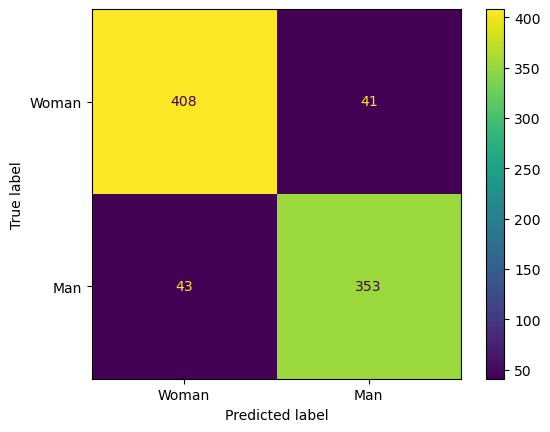

In [91]:
cm = metrics.confusion_matrix(labels_gender, [p[1] for p in predictions_gender])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Woman', 'Man'])
disp.plot()

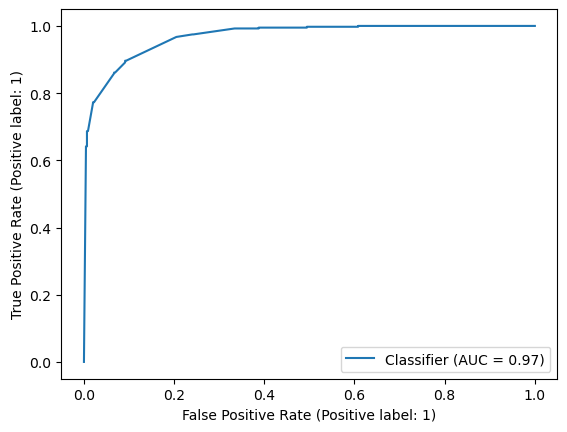

In [93]:
disp = metrics.RocCurveDisplay.from_predictions(labels_gender, [p[0] for p in predictions_gender])
disp